# Optical pumping tests
including blowaway and depumping. For blowaway tests earlier than 2024.04.26, I used blowaway.ipynb.

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## 2024.06.14
Yesterday we replaced the double pass AOM with the ATM350-A0,2-800. The Brimrose one has a defect which made it difficult to align correctly (we found that I had aligned the second order pass incorrectly).

In [19]:
fnames = get_files_by_criteria(date_filters=["2024-06-14"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 47 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014866-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014869-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\07\000014869-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014870-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014870-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-14\08\000014872-GeneralVariableScan.h5) scanned over dummy_variable
file 6 (C:\Networking Experiment\artiq codes

### D1 F=1 to F=1 resonance scan
I am doing experiments with D1_off_in_OP_phase set to True, such that in the OP phase, there is only pumping repump, and the atom ends up in F=1. Then I am doing a frequency scan of the double pass AOM by manually adjusting it before each iteration. This is why the scans are over dummy_variable, since the D1 DP is controlled by an HP RF supply. Then, the depump phase should depump the atoms from F=1 into F=2 if the light is resonant, and then those atoms are blown away with a resonant unidirectional D2 pulse from MOT6. In this way, I should see a dip of order the linewidth of the excited state if I am not too power broadened. 

The data isn't really trustworthy, because either the HP RF source does not keep a constant RF power, the AOM changes efficiency vs frequency, or thermalization in the AOM changing is enough to change the fiber coupling. Whatever the cause, the optical power on the TTI changes over the frequency scan by a factor 2. The higher retention at larger red detuning corresponds to lower optical power.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


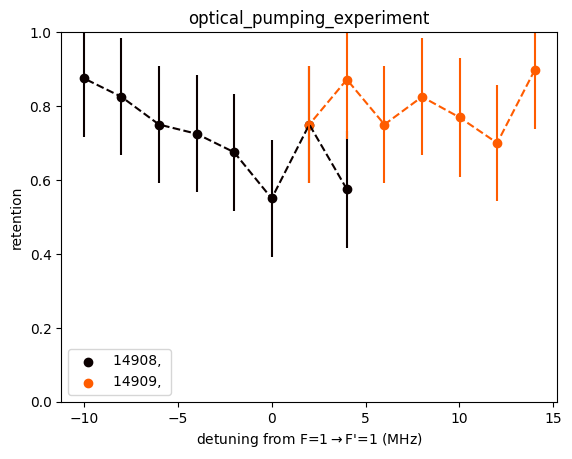

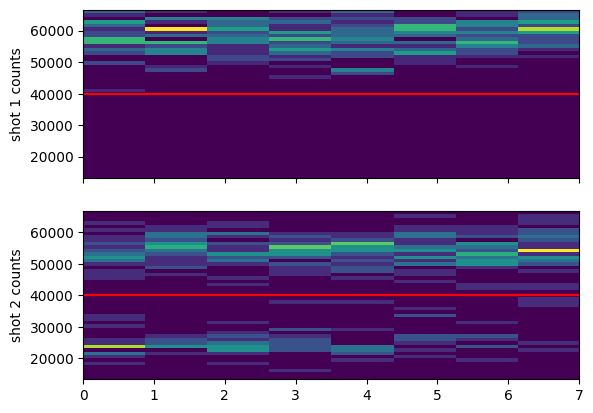

In [20]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    38: '',
    40: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [21]:
np.linspace(0,10,10)*kHz +334.682*MHz

array([3.34682000e+08, 3.34683111e+08, 3.34684222e+08, 3.34685333e+08,
       3.34686444e+08, 3.34687556e+08, 3.34688667e+08, 3.34689778e+08,
       3.34690889e+08, 3.34692000e+08])

### OP with intentionally wrong bias
If I set the coils to intentionially provide a bias orthogonal to the D1 light, there shouldn't be a dark state, so I should be able to get more depumping into F=2.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


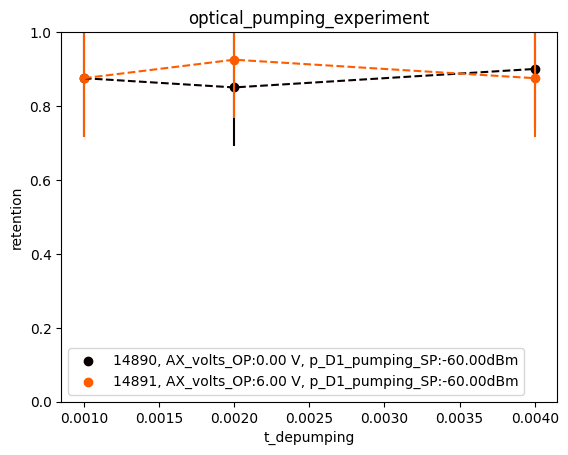

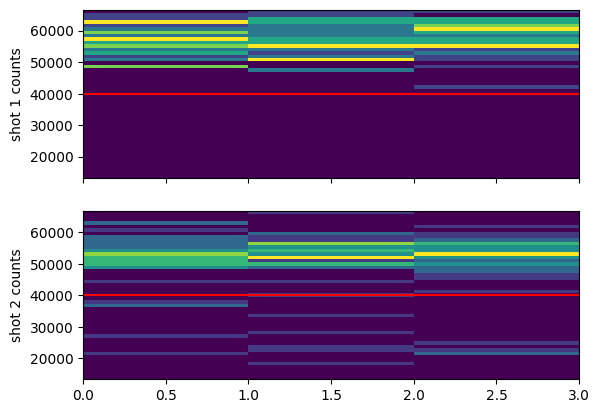

In [15]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    # 15: '' # comparison between depumping to F=2 with and without AX bias field
    17: '',
    19: ''
    
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AX_volts_OP:{AX_volts_OP:.2f} V, p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
xsteps_xform = lambda x: x # do nothing

# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    cutoff1=cutoff2 = 40000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### D1 SP AOM power scans - off resonance
By scanning the power with detuned light, I should be able to find an AOM power for which the D1 light is no longer substantially transferring population, which should the spectrum isn't too power broadened. Then I can park the AOM at that power and do a frequency scan.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0


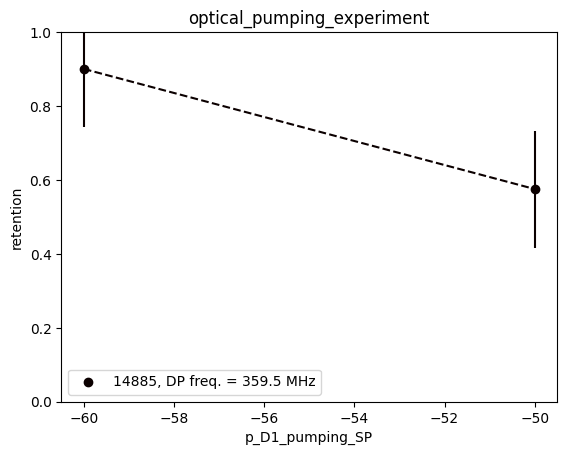

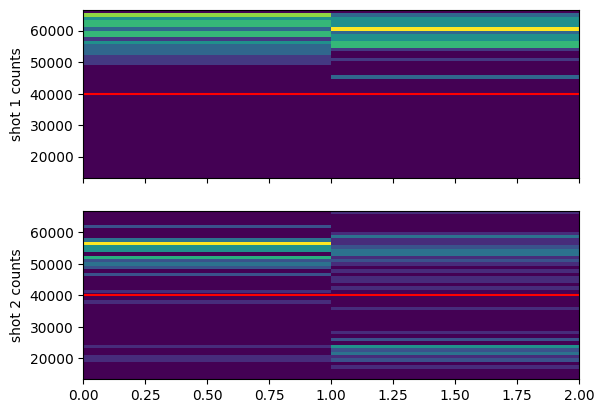

In [8]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    10: 'DP freq. = 359.5 MHz',
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
xsteps_xform = lambda x: x # do nothing

# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    cutoff1=cutoff2 = 40000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### D1 SP AOM power scans - on resonance
The AOMs are set for resonance with F=1 to F'=1

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


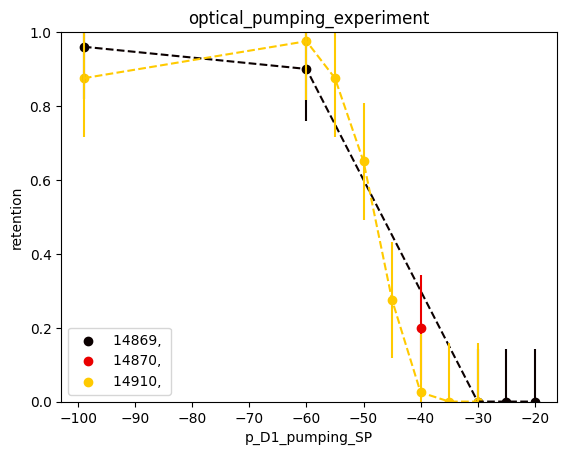

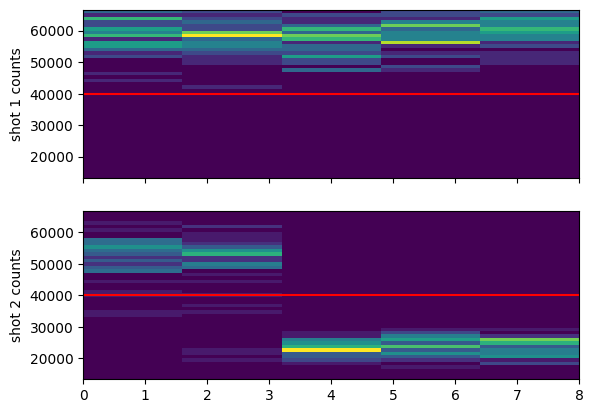

In [18]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    2: '',
    4: '',
    42: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
xsteps_xform = lambda x: x # do nothing

# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)
    cutoff1=cutoff2 = 40000*t_SPCM_first_shot

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.09

In [198]:
fnames = get_files_by_criteria(date_filters=["2024-06-09"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 63 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\14\000014729-GeneralVariableScan.h5) scanned over t_depumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\14\000014730-GeneralVariableScan.h5) scanned over t_depumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\14\000014731-GeneralVariableScan.h5) scanned over t_depumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\14\000014732-GeneralVariableScan.h5) scanned over t_depumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\14\000014734-GeneralVariableScan.h5) scanned over t_depumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\15\000014738-GeneralVariableScan.h5) scanned over t_depumping
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-09\15\000014738-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5)

### D1 SP AOM power scans
I realigned the double pass AOM because the second pass seemed to be aligned to the wrong order, which may have been the main problem. This another experiment in which D1 light is only on during the depumping phase, and there is a fixed pumping time.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0


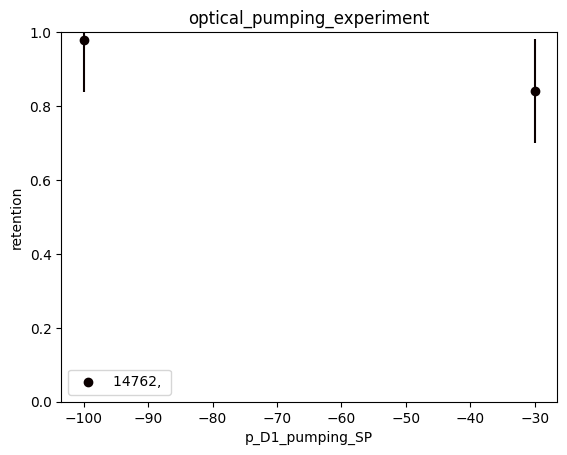

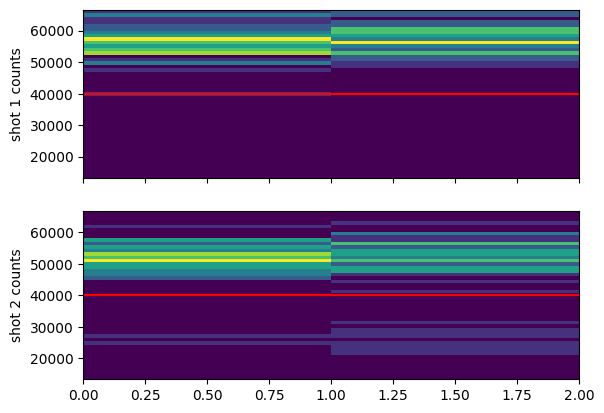

In [197]:
compare = True # compare multiple files in the same retention and loading plots

# these have t_depumping = 3 ms
file_indices = {
    9: '',
    14: ''
} # the files to plot

# these have t_depumping = 4 ms
file_indices = {
    24: '',
    26: '',
    28: '',
    30: ''
} # the files to plot

# these have t_depumping = 5 ms
file_indices = {
    33: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        # ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.08

In [174]:
fnames = get_files_by_criteria(date_filters=["2024-06-08"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 54 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014645-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014645-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014646-GeneralVariableScan.h5) scanned over p_D1_pumping_SP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014646-GeneralVariableScan_optical_pumping_scan_over_p_D1_pumping_SP.h5) scanned over p_D1_pumping_SP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014648-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-08\15\000014650-GeneralVariableScan.h5) scanned over dummy_variable
file 6 (C:\Networking Experiment\artiq codes\

### D1 F=1 to F=1 resonance scan
I am doing experiments with D1_off_in_OP_phase set to True, such that in the OP phase, there is only pumping repump, and the atom ends up in F=1. Then I am doing a frequency scan of the double pass AOM by manually adjusting it before each iteration. This is why the scans are over dummy_variable, since the D1 DP is controlled by an HP RF supply. Then, the depump phase should depump the atoms from F=1 into F=2 if the light is resonant, and then those atoms are blown away with a resonant unidirectional D2 pulse from MOT6. In this way, I should see a dip of order the linewidth of the excited state if I am not too power broadened. 

The data isn't really trustworthy, because either the HP RF source does not keep a constant RF power, the AOM changes efficiency vs frequency, or thermalization in the AOM changing is enough to change the fiber coupling. Whatever the cause, the optical power on the TTI changes over the frequency scan by a factor 2. The higher retention at larger red detuning corresponds to lower optical power.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0


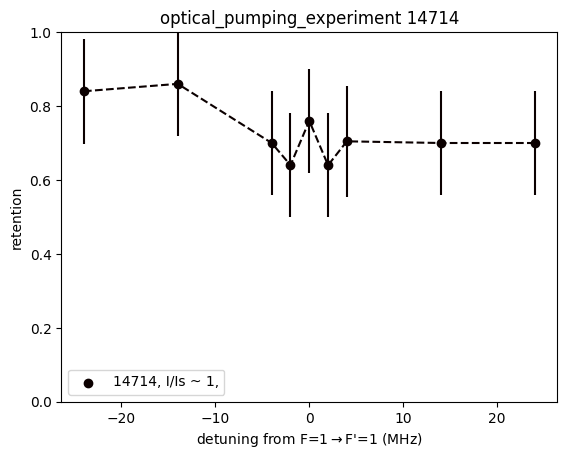

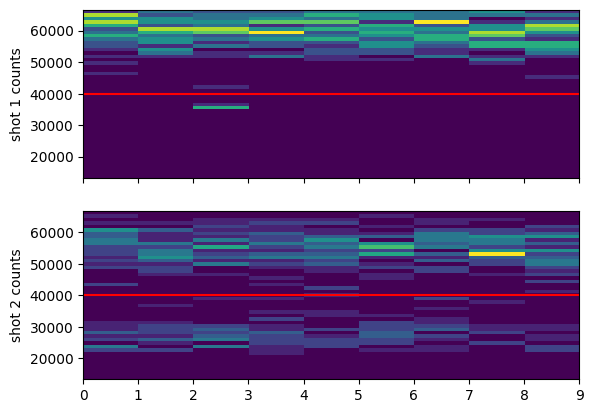

In [178]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    53: 'I/Is ~ 1,' # for this, there should be about 30 uW before the GRIN fiber, so we might get ~ 1 Isat at the atom if the butt coupling efficiency is 50%
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### check depumping dependence on power
Same as the depump experiment below, but vs power instead of time

experiment: optical_pumping_experiment
AY_volts_OP: 0.0


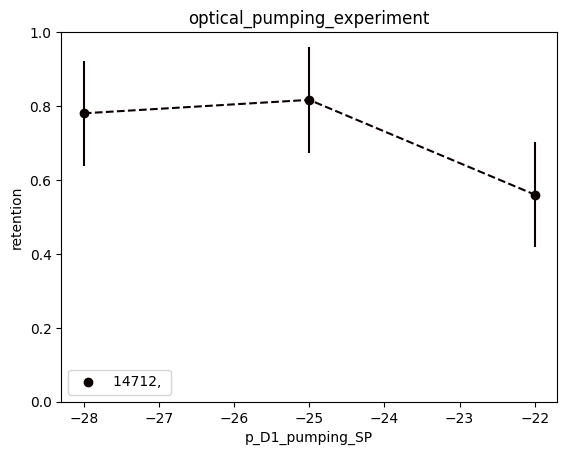

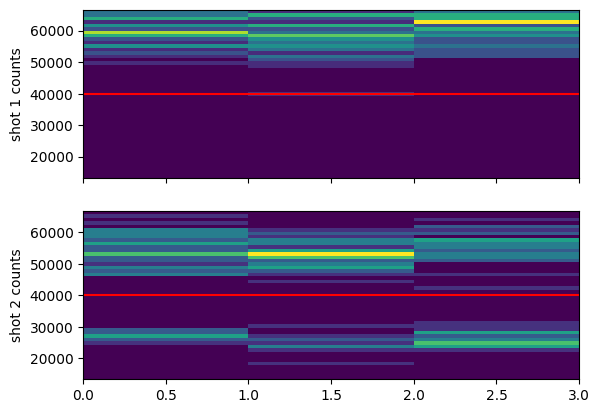

In [173]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    # 49: '' # I think this is one I aborted mid-iteration. don't trust it
    51: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: ''#f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
xsteps_xform = lambda x: x # do nothing

# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### measure depumping into F=2 vs time
Same as the trap chop experiment below, but now there is D1 light on during the depump phase. 

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


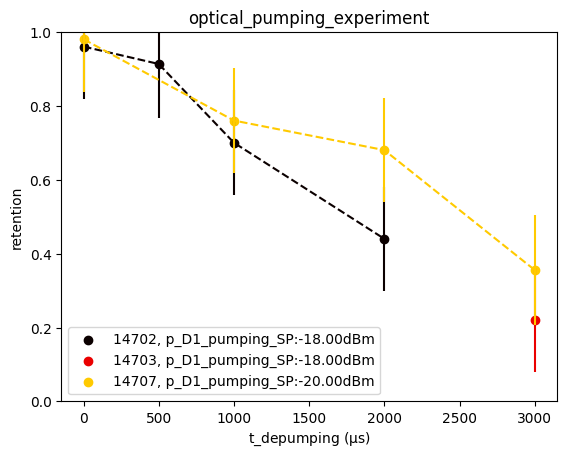

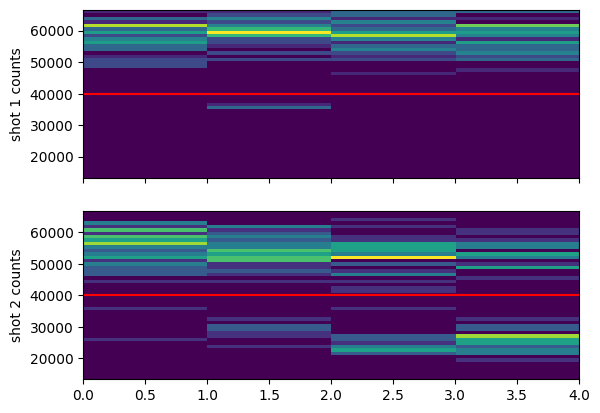

In [165]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    37: '',
    39: '',
    44: ''
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

loc=(1.05,-0.05)
loc='lower left' 

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=loc)
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [161]:
p_D1_pumping_SP

-18.0

### check that chopping is not causing any loss
By pumping into F=1 with OP repump alone, scanning the depump time without any D1 light, and doing a blowaway, we can see if the trap chopping is causing any loss.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0


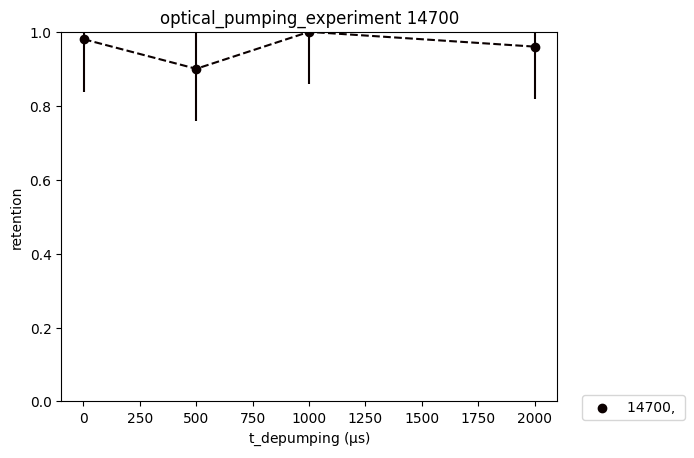

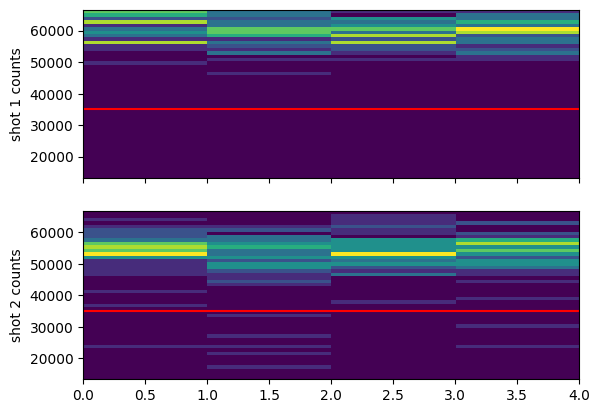

In [156]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    34: '',
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f''

cutoff1=cutoff2 = 35000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"t_depumping $(\rm{\mu s})$"
xsteps_xform = lambda x: x*1e6 # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
if not compare:
    ax_ret.set_title(experiment_function+' '+str(rid))
else:
    ax_ret.set_title(experiment_function)


if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### D1 power scans -- seeing how much power is need to depump into F=2 for 500 us pumping.

At -5 dBm to the SP AOM, the width of the depumping dip (see the power scan below) must be at least 30 MHz wide based on tuning the DP away from the resonance and trying to see the retention go back up. 
see how much power it takes to fully depump the atoms into F=2 after 10 us of pumping into F=1 with OP repumper alone (D1 light off in the OP stage). Even 24 MHz away (DP = 350 MHz) at -12 dBm to the SP, there is insignificant retention improvement. 

Double check that D1 laser is really locked correctly. Yes, it's locked correctly. Set the AOM to -17 dBm.

In [144]:
362+np.arange(-12,14,2)

array([350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374])

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


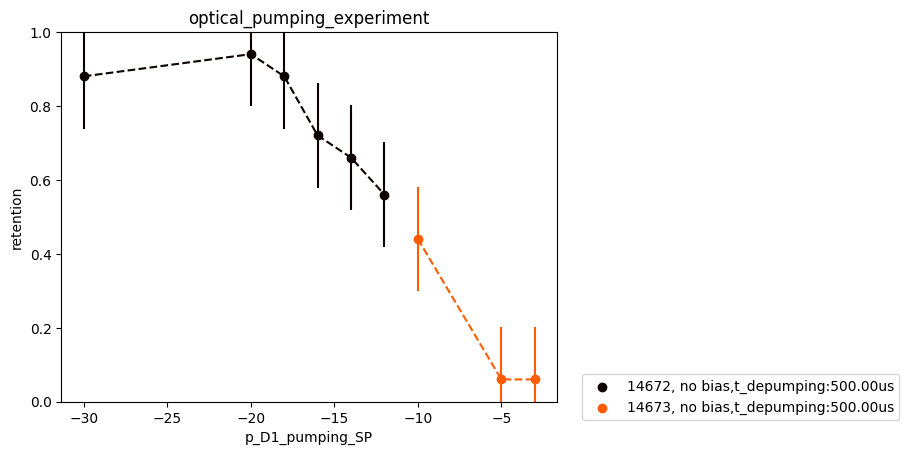

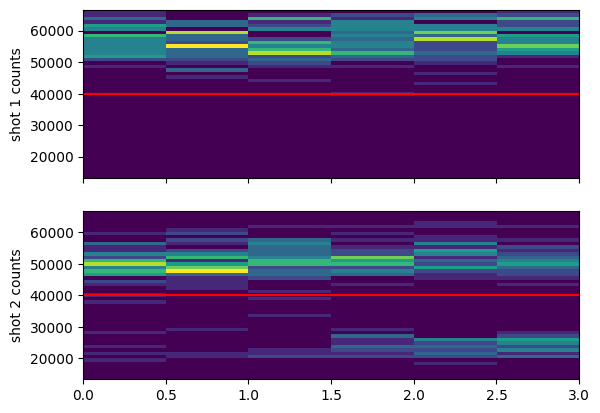

In [141]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    # 11: '',
    15: '', # too lossy
    17: ''#'I/Is ~ 1,' # for this, there about 30 uW before the GRIN fiber, so we might get ~ 1 Isat at the atom if the butt connection is 50%
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [145]:
362+np.arange(-8,9,1)

array([354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
       367, 368, 369, 370])

### D1 power scan
see how much power it takes to fully depump the atoms into F=2 after 10 us of pumping into F=1 with OP repumper alone (D1 light off in the OP stage)

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


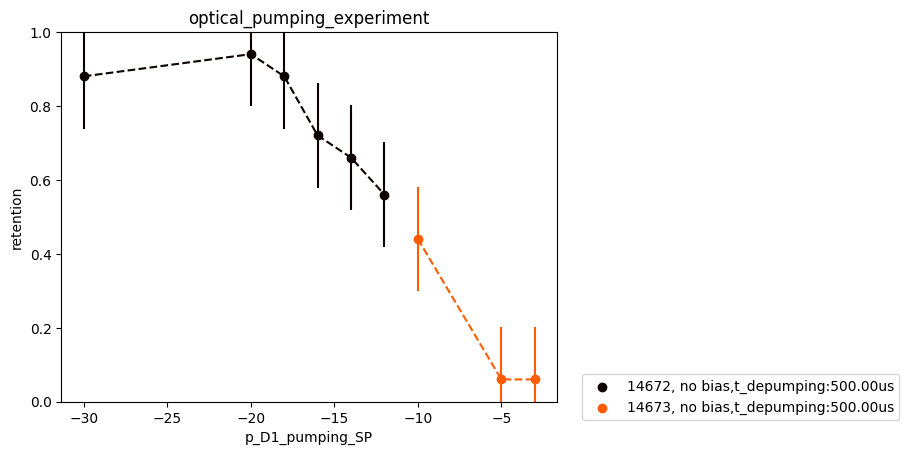

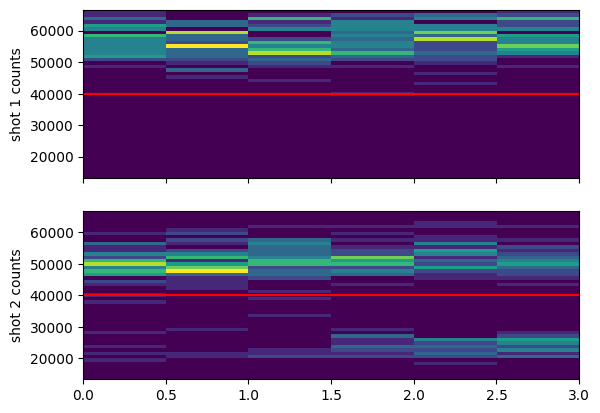

In [141]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    # 11: '',
    15: '', # too lossy
    17: ''#'I/Is ~ 1,' # for this, there about 30 uW before the GRIN fiber, so we might get ~ 1 Isat at the atom if the butt connection is 50%
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us' #,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.07

In [101]:
fnames = get_files_by_criteria(date_filters=["2024-06-07"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 17 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014598-GeneralVariableScan.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014599-GeneralVariableScan.h5) scanned over dummy_variable
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014601-GeneralVariableScan.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014602-GeneralVariableScan.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014603-GeneralVariableScan.h5) scanned over dummy_variable
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014604-GeneralVariableScan.h5) scanned over dummy_variable
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-07\11\000014607-GeneralVariableScan.h5) scanned over dummy_

### D1 F=1 to F=1 resonance scan
I am doing experiments with D1_off_in_OP_phase set to True, such that in the OP phase, there is only pumping repump, and the atom ends up in F=1. Then I am doing a frequency scan of the double pass AOM by manually adjusting it before each iteration. This is why the scans are over dummy_variable, since the D1 DP is controlled by an HP RF supply. I could probably set up GPIB but haven't. Then, the depump phase should depump the atoms from F=1 into F=2 if the light is resonant, and then those atoms are blown away with a resonant unidirectional D2 pulse from MOT6. In this way, I should see a dip of order the linewidth of the excited state if I am not too power broadened. 

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


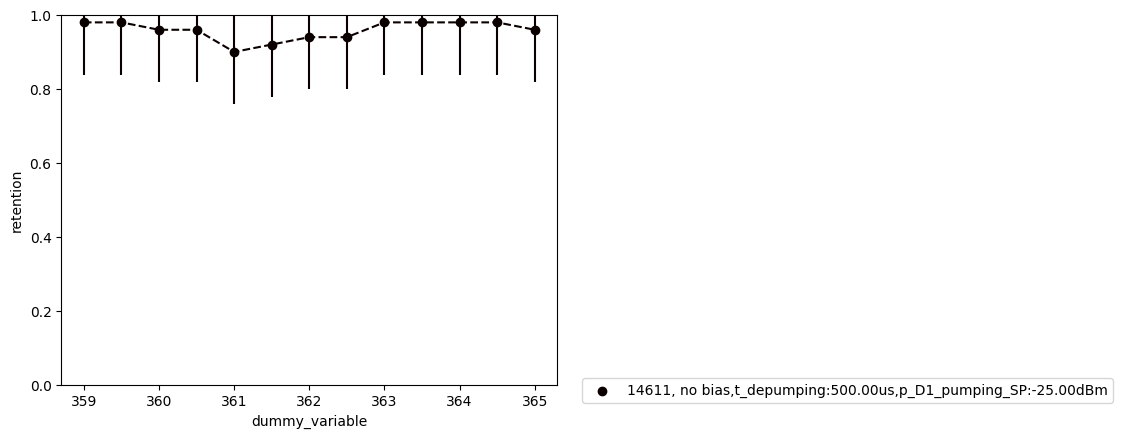

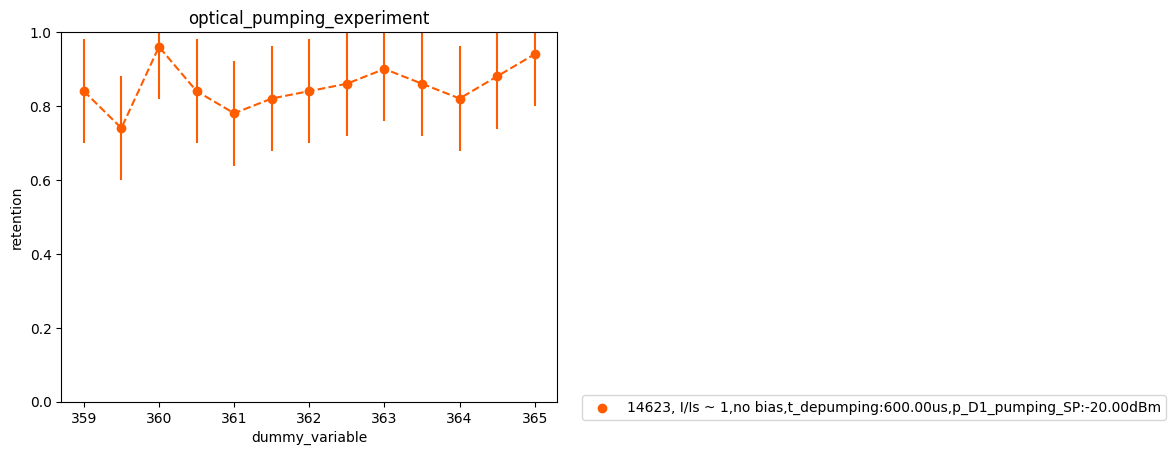

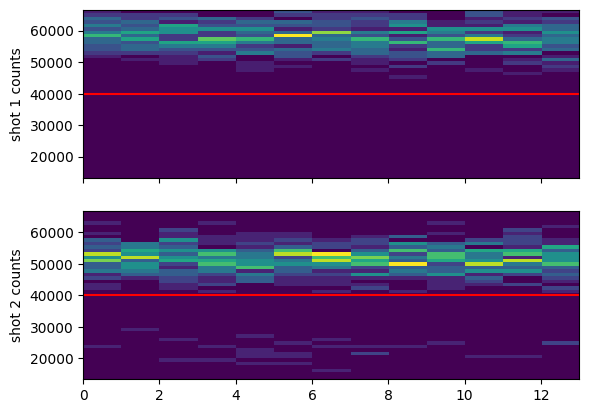

In [135]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    11: '',
    # 14: 'I/Is ~ 0.5,', # too lossy
    16: 'I/Is ~ 1,' # for this, there about 30 uW before the GRIN fiber, so we might get ~ 1 Isat at the atom if the butt connection is 50%
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))
        # ax_ret.set_ylim((0.6,1))


        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


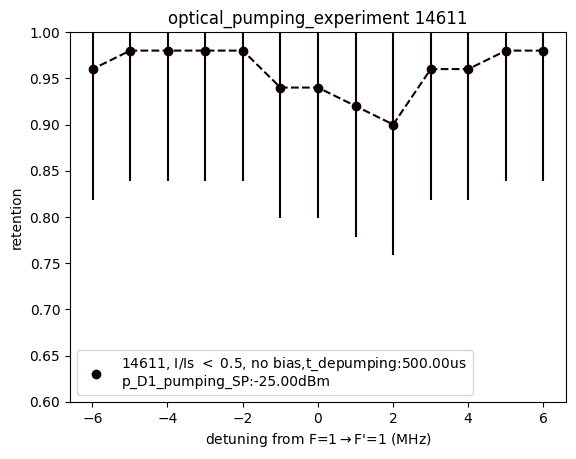

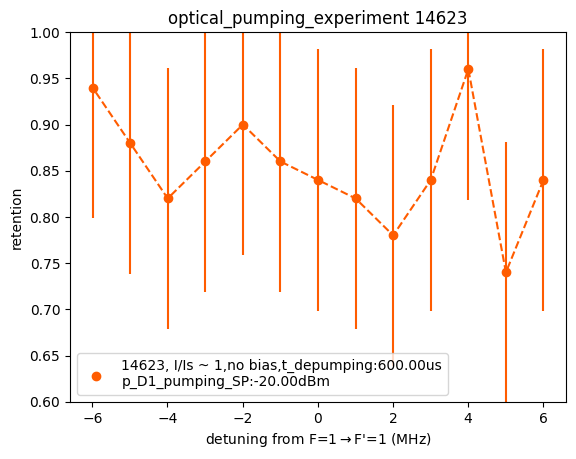

In [134]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    11: r'I/Is $<$ 0.5, ',
    # 14: 'I/Is ~ 0.5,', # too lossy
    16: 'I/Is ~ 1,' # for this, there about 30 uW before the GRIN fiber, so we might get ~ 1 Isat at the atom if the butt connection is 50%
} # the files to plot


showhist = True
showloading = False
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f},t_depumping:{t_depump*1e6:.2f}us,p_D1_pumping_SP:{p_D1_SP:.2f}dBm'
f_comment_func = lambda azt,azb,ax,ay,t_depump,p_D1_SP: f'no bias,t_depumping:{t_depump*1e6:.2f}us\np_D1_pumping_SP:{p_D1_SP:.2f}dBm'
legend_loc = (1.05,-0.05)
legend_loc = 'lower left'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = True
xlabel = r"detuning from F=1$\rightarrow$F'=1 (MHz)"
xsteps_xform = lambda x: x # do nothing
xsteps_xform = lambda x: 816.656 - 2*x - 92.65

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP,t_depumping,p_D1_pumping_SP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.set_ylim((0,1))
        ax_ret.set_ylim((0.6,1))

        # sec_ax = ax_ret.secondary_xaxis('top', functions=(lambda x: x, lambda x: 816.656 - 2*x - 92.65))
        # sec_ax.set_xlabel("detuning from F=1->F'=1 (MHz)")

        if not showloading:
            if custom_xlabel:
                ax_ret.set_xlabel(xlabel)
            else:
                ax_ret.set_xlabel(scan_variable1_name)
        ax_ret.set_ylabel("retention")
        
        ax_ret.legend(loc=legend_loc)
    
    ax_ret.set_title(experiment_function +' '+ str(rid))
plt.show()

In [108]:
1/np.sqrt(100)

0.1

In [91]:
errs

array([0.14142136, 0.14142136, 0.14142136, 0.14142136, 0.14142136,
       0.14142136, 0.14142136, 0.14142136, 0.14142136, 0.14142136,
       0.14142136, 0.14142136, 0.14142136])

In [93]:
1/np.sqrt(50)

0.1414213562373095

## 2024.06.06

In [99]:
fnames = get_files_by_criteria(date_filters=["2024-06-05"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\18\000014499-GeneralVariableScan_optical_pumping_scan_over_AZ_top_volts_OP.h5, which is corrupt
found 26 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\09\000014455-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\09\000014456-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\09\000014456-GeneralVariableScan_optical_pumping_scan_over_AZ_top_volts_OP.h5) scanned over AZ_top_volts_OP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\09\000014457-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-05\09\000014458-GeneralVariableScan.h5) scanned over AZ_top_volts_OP
file 5 (C:\Networking Experiment\artiq codes\artiq-mas

### various diagnostics after fixing the fiber polarization to the slow axis
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. after I fixed this, and installed a monitor on a tiny breadboard from Akbar, I ran several diagnostic scans.

24
experiment: optical_pumping_experiment
AY_volts_OP: -9.6
25
experiment: optical_pumping_experiment
AY_volts_OP: -9.6


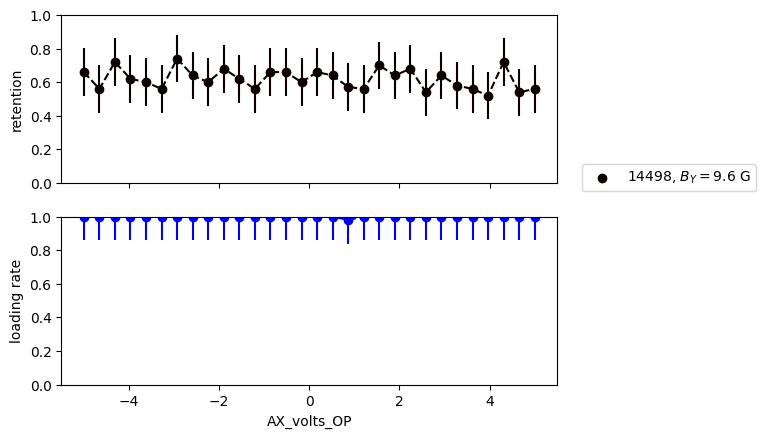

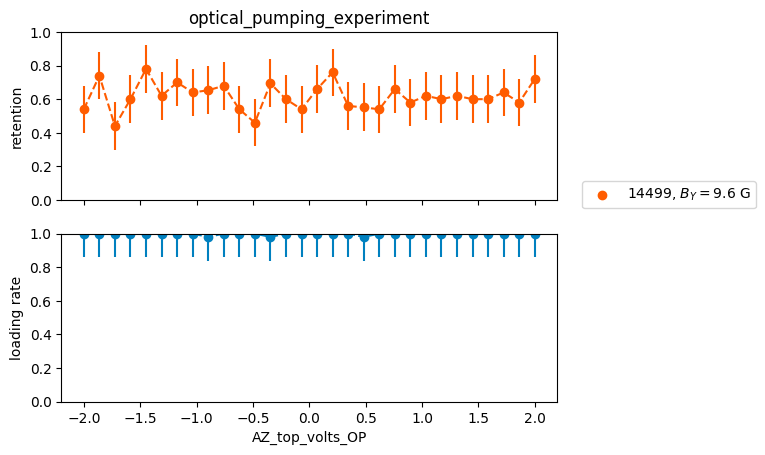

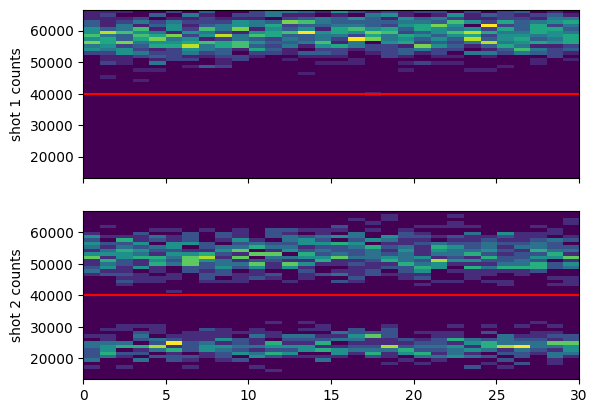

In [100]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    24: r'$B_{Y} = 9.6$ G', # 
    25: r'$B_{Y} = 9.6$ G', # 
} # the files to plot


showhist = True
showloading = True
f_comment_func = lambda azt,azb,ax,ay: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f}'
f_comment_func = lambda azt,azb,ax,ay: ''

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    print(f_idx)
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.04
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. This applies to all OP experiments before this was fixed.

In [69]:
fnames = get_files_by_criteria(date_filters=["2024-06-04"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\13\000014439-GeneralVariableScan_microwave_Rabi_scan_over_f_microwaves_dds.h5, which is corrupt
found 17 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014434-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014434-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014435-GeneralVariableScan.h5) scanned over t_microwave_pulse
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014435-GeneralVariableScan_microwave_Rabi_scan_over_t_microwave_pulse.h5) scanned over t_microwave_pulse
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-04\11\000014438-GeneralVariableScan.h5) scanned over f_microwaves_dds
f

### various diagnostics after fixing the fiber polarization to the slow axis
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. after I fixed this, and installed a monitor on a tiny breadboard from Akbar, I ran several diagnostic scans.

experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2


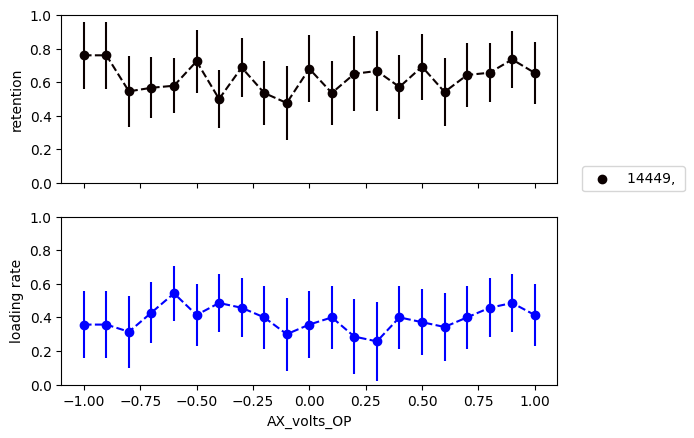

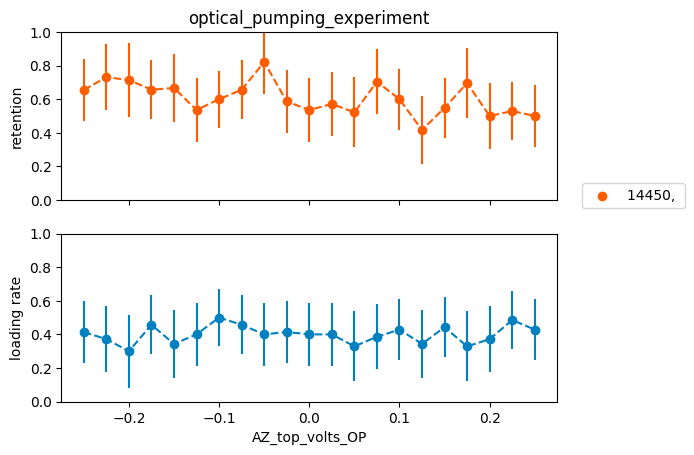

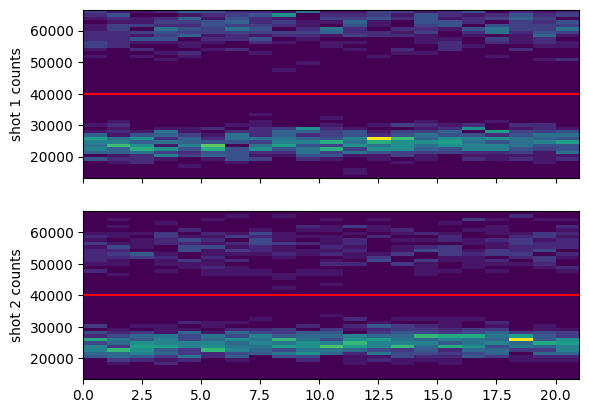

In [68]:
compare = False # compare multiple files in the same retention and loading plots
file_indices = {
    14: '', # broad scan over AX
    15: '' # broad scan over AX
} # the files to plot


showhist = True
showloading = True
f_comment_func = lambda azt,azb,ax,ay: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f}'
f_comment_func = lambda azt,azb,ax,ay: ''

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.06.03
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. This applies to all OP experiments before this was fixed.

In [63]:
fnames = get_files_by_criteria(date_filters=["2024-06-03"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 8 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014416-GeneralVariableScan.h5) scanned over t_depumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014416-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014417-GeneralVariableScan.h5) scanned over t_depumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014417-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014418-GeneralVariableScan.h5) scanned over t_depumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-06-03\11\000014418-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 6 (C:\Networking Experiment\artiq

### various diagnostics after fixing the fiber polarization to the slow axis
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. after I fixed this, and installed a monitor on a tiny breadboard from Akbar, I ran several diagnostic scans.

experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


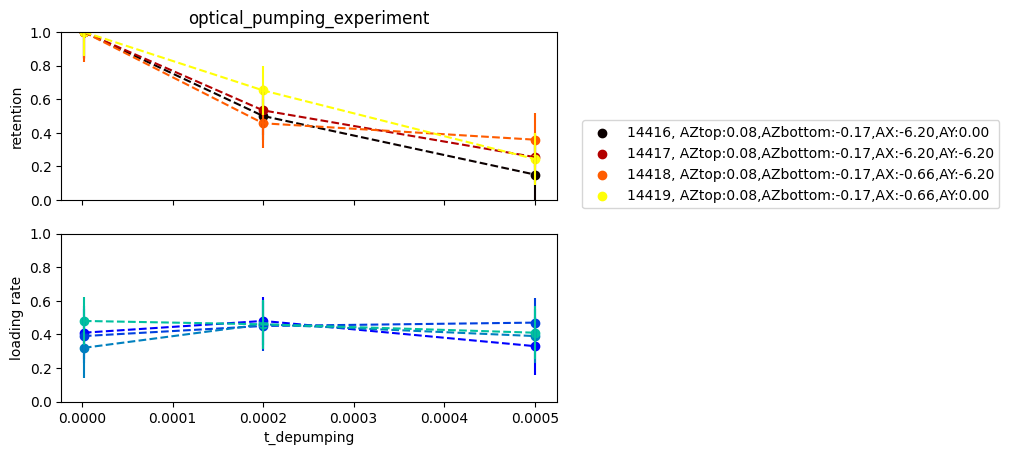

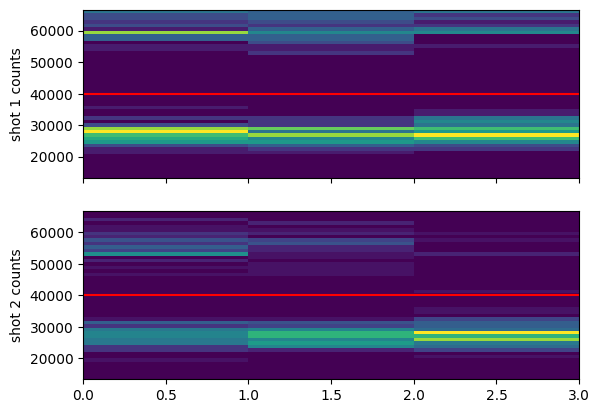

In [64]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    1: '', # no integrator though
    3: '',
    5: '',
    7: '',
} # the files to plot


showhist = True
showloading = True
f_comment_func = lambda azt,azb,ax,ay: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f}'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.05.31
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. This applies to all OP experiments before this was fixed.

## optimizing optical pumping coil settings
The optical pumping does not look like it depends on the coil settings.

In [59]:
fnames = get_files_by_criteria(date_filters=["2024-05-31"], # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\10\000014381-GeneralVariableScan_optical_pumping_scan_over_AX_volts_OP_and_AY_volts_OP.h5, which is corrupt
found 29 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\09\000014375-GeneralVariableScan_optical_pumping_scan_over_AY_volts_OP.h5) scanned over AY_volts_OP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\09\000014377-GeneralVariableScan.h5) scanned over AY_volts_OP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\09\000014377-GeneralVariableScan_optical_pumping_scan_over_AY_volts_OP.h5) scanned over AY_volts_OP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\10\000014379-GeneralVariableScan.h5) scanned over AX_volts_OP, AY_volts_OP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-31\10\000014379-GeneralVariableScan_optical_pumping_scan_over_AX_volts_OP_and_AY

### various diagnostics after fixing the fiber polarization to the slow axis
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over. after I fixed this, and installed a monitor on a tiny breadboard from Akbar, I ran several diagnostic scans. However, it is likely the laser was unlocked for these. We are not yet monitoring that.

experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: 0.0
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: 0.0


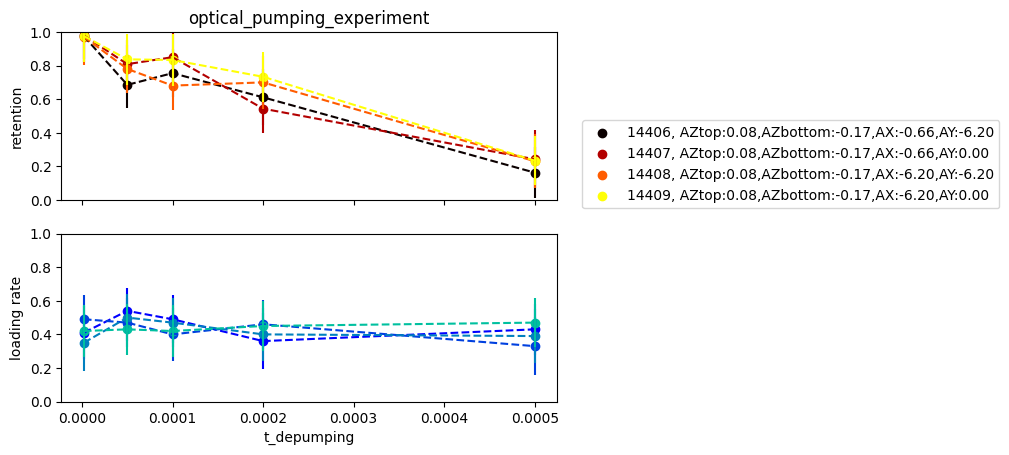

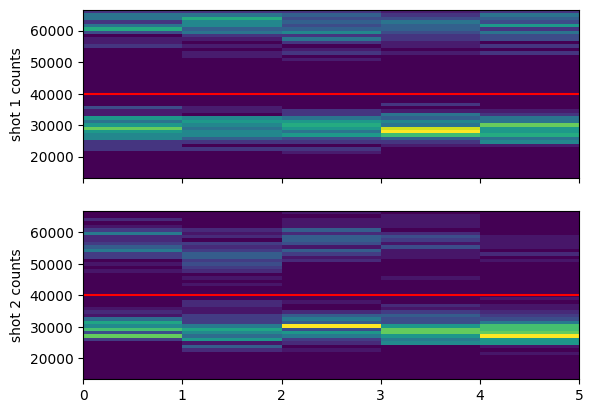

In [62]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    21: '', # no integrator though
    23: '',
    25: '',
    27: '',
} # the files to plot


showhist = True
showloading = True
f_comment_func = lambda azt,azb,ax,ay: f'AZtop:{azt:.2f},AZbottom:{azb:.2f},AX:{ax:.2f},AY:{ay:.2f}'

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    f_comment += f_comment_func(AZ_top_volts_OP,AZ_bottom_volts_OP,AX_volts_OP,AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### comparing depumping curves with and without the laser locked
optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over.

experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2


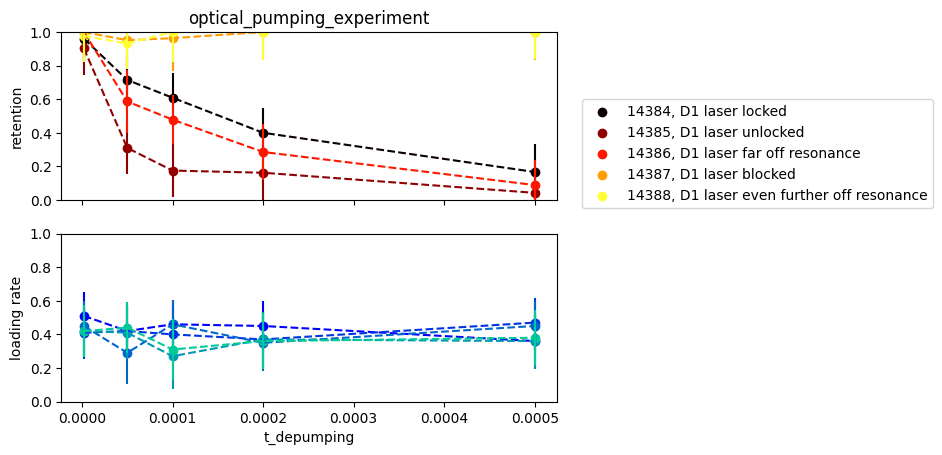

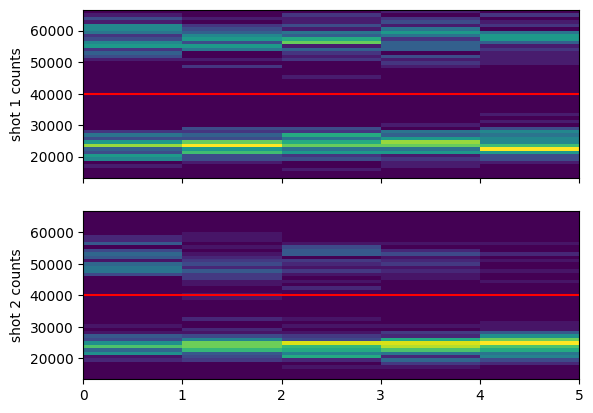

In [58]:
compare = True # compare multiple files in the same retention and loading plots
file_indices = {
    10: 'D1 laser locked', # no integrator though
    12: 'D1 laser unlocked',
    14: 'D1 laser far off resonance',
    16: 'D1 laser blocked',
    18: 'D1 laser even further off resonance'
} # the files to plot


showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['hot']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

### comparing pumping with different coil settings - no major change
attention: optical pumping experiments before 000014406 can not be trusted. The polarization was not aligned to the slow axis of the fiber carrying the D1 light to the box, so the power at the atoms must have been drifting all over.

experiment: optical_pumping_experiment


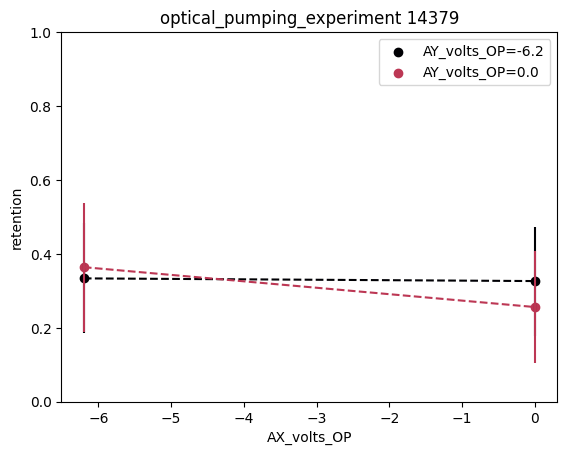

experiment: optical_pumping_experiment


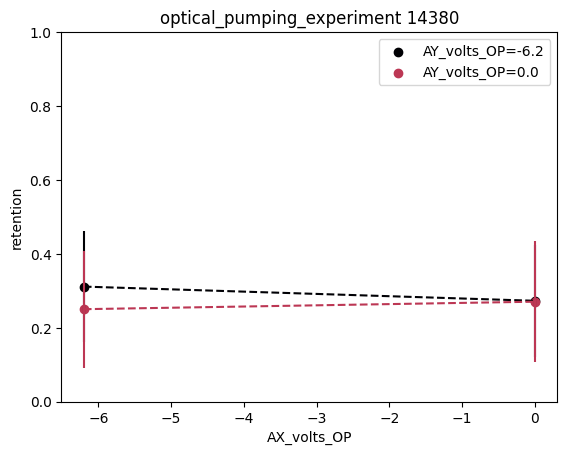

experiment: optical_pumping_experiment


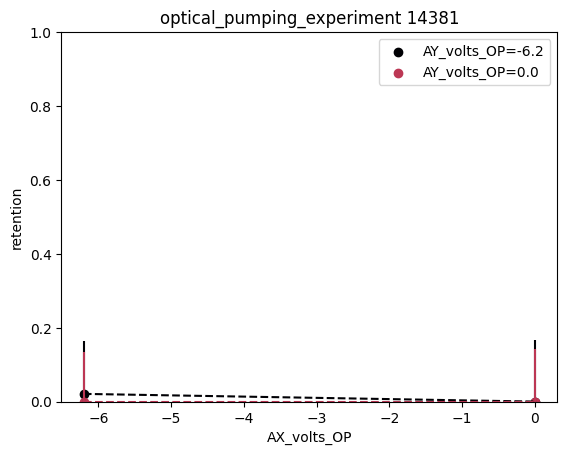

In [42]:
file_indices = [
    # 0 # with and without AY_volts_OP on, shows little difference in a depump measurement
    3, # with D1 laser "locked", no integrator
    5, # same as above, but laser scanning around resonance
    7, # laser scanning away from resonance 
] # the files to plot

showhist = False
showloading = False

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    if scan_variable2_name != '':
        scan_is_2D = True
    else:
        scan_sequence2 = np.zeros(1)
        scan_is_2D = False
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
        for i, ax in enumerate(axes.flat):
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            # ax.set_ylabel("occurences")
            # ax.set_xlabel("photons")
            ax.set_xticks([])
            ax.set_yticks([])
        if scan_is_2D: # todo
            axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
            [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
            [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
            [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
        fig.text(0.45,-0.5, scan_variable2_name)
        fig.text(0.05,0.35, scan_variable1_name,rotation=90)
        plt.subplots_adjust(bottom=-0.4)
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
        plt.ylim((0,1))
    
    
    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+' '+str(rid))
    plt.show()

## 2024.05.30

## optimizing optical pumping coil settings
There is around 1.3 mW before the AOM fiber and 0.6 mW in the box, as measured with the AOM on continuously. The fiber coupling has been optimized with the optical pumping experiment, i.e. when the AOM is chopping. The DP AOM was being run at -6.4 dBm, which was much less than maximum efficiency, so it has now been reset to 3.6 dBm which is what Eunji used originally when she aligned the D1 setup. The SP AOM has been decreased to -14 dBm to compensate.

The coils are not optimized currently, so I can easily check whether there is sufficient D1 light at the atoms: with no D1 light, a depumping phase has no effect on the number of atoms retained, because population remains in F=1. This is easy to check by physically blocking the D1 light. By unblocking the light, if the coils are sufficiently suboptimal and the depump time is long enough, the retention goes to zero (all population ends up in F=2 and is blown away). See experiment 14315. 

In [67]:
fnames = get_files_by_criteria(date_filters=["2024-05-30"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 13 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\09\000014289-GeneralVariableScan_optical_pumping_scan_over_AY_volts_OP.h5) scanned over AY_volts_OP
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\09\000014294-GeneralVariableScan_optical_pumping_scan_over_AZ_top_volts_OP.h5) scanned over AZ_top_volts_OP
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\09\000014297-GeneralVariableScan_optical_pumping_scan_over_AX_volts_OP.h5) scanned over AX_volts_OP
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\10\000014301-GeneralVariableScan_optical_pumping_scan_over_AX_volts_OP.h5) scanned over AX_volts_OP
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\10\000014312-GeneralVariableScan_optical_pumping_scan_over_AY_volts_OP.h5) scanned over AY_volts_OP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-30\10\000014313-Ge

experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2
experiment: optical_pumping_experiment
AY_volts_OP: -6.2


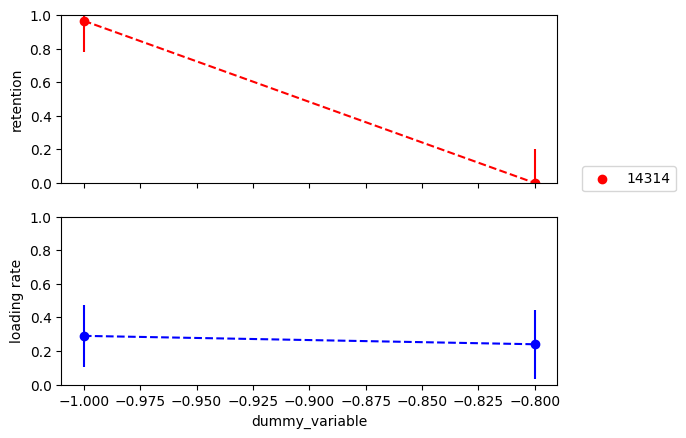

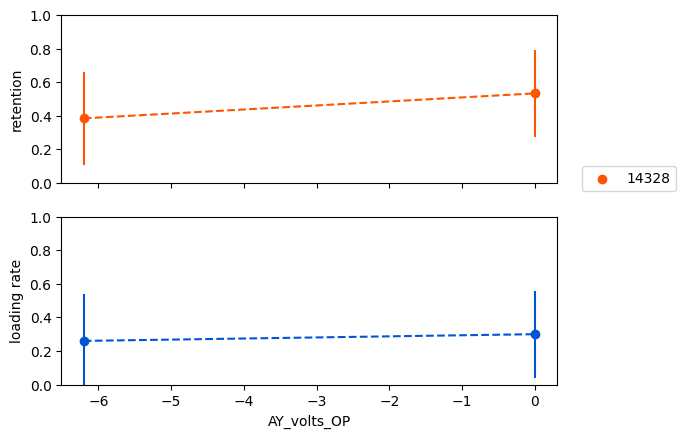

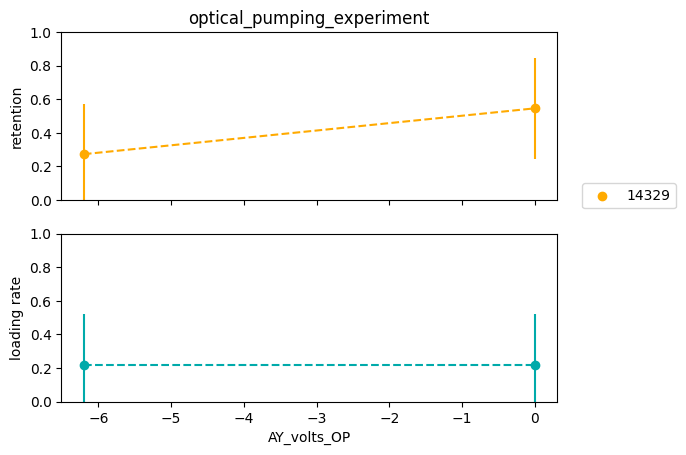

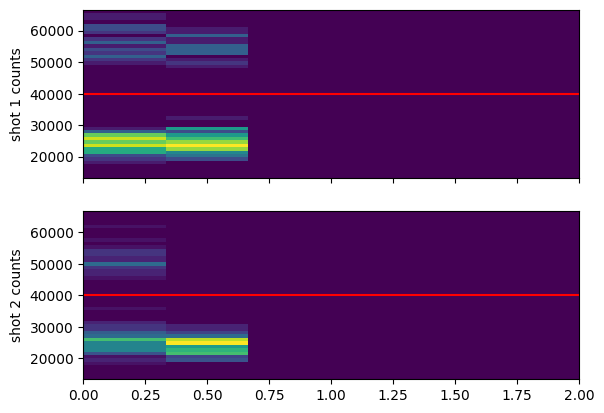

In [68]:

# files 1 (14232) and 2 (14235) show that the depumping measurement indicates near perfect optical pumping, even with the AY coil set to 0! (this is the main coil for setting the 3.2 G bias field). 
# the results below are consistent with almost no D1 light getting to the atoms. In that case, the depump phase will not move any population from F=1 to F=2 and it will appear as though the OP
# fidelity is near perfect. We found that the D1 laser was unlocked, which explains this.

compare = False # compare multiple files in the same retention and loading plots
file_indices = [
    6, # dummy variable scan. the 1st (2nd) iteration has the D1 light (un)blocked, showing that retention is near 1 (0)
    11, # shows no apparent difference in pumping, with and without the bias field
    12, # same as 11, but other coils set to 0. again, not convincing that the coils have an effect. the retention is better without the Y coil on!
    13, # dummy variable scan. the 2nd iteration has the D1 light blocked. we expect retetion = 1 but the loading
] # the files to plot

showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if not compare:
            if showloading:
                fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## 2024.05.29

## computing pumping fidelity - we learned there was not enough D1 power at the atoms
I swapped the pumping repump fiber connection from going into only MOT 5 and 6 to going to all MOT beams, by plugging it into the 75:25 blue input. See experiments 14229, 14230 for pumping and depumping measurements.

In [60]:
fnames = get_files_by_criteria(date_filters=["2024-05-29"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 21 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\09\000014231-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\09\000014232-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\09\000014235-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\10\000014237-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\10\000014238-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-29\11\000014241-GeneralVar

KeyError: 'Unable to synchronously open object (bad object header version number)'

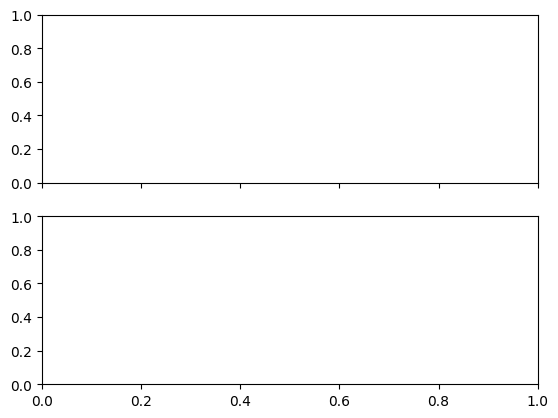

In [61]:
# compare multiple files in the same retention and loading plots

# files 1 (14232) and 2 (14235) show that the depumping measurement indicates near perfect optical pumping, even with the AY coil set to 0! (this is the main coil for setting the 3.2 G bias field). 
# the results below are consistent with almost no D1 light getting to the atoms. In that case, the depump phase will not move any population from F=1 to F=2 and it will appear as though the OP
# fidelity is near perfect. We found that the D1 laser was unlocked, which explains this.
file_indices = [
    1, # shows ~ no depumping out to 3 ms
    2, # sanity check depumping measurement with AY_volts_OP = 0.0 and yet we still see no decrease in retention out to 3 ms
    3, # D1 OP physically blocked, same result
    4 # pumping RP physically blocked, retention is 0, meaning all of the atoms are in F=2 and get blown away
] # the files to plot

#
file_indices = [
    6, # depumping with D1 relocked
    7, # depumping with AZ_volts_OP set to 0.0, which degrades the pumping fidelity
    # 8  # depumping with AY_volts_OP set to 0.0, which degrades the pumping fidelity
    11 # depumping with AY_volts_OP set to 0.0, which should degrade the pumping fidelity
] # the files to plot

# scans over D1 single pass power, with intentionally wrong bias field. 
# When the D1 optical power at atoms is negligible, the retention during a depump experiment stays near 1. 
# When """ is high, then the atoms should be quickly depumped into F=2 since the bias field is wrong. 
file_indices = [
    18, # 200 us depumping, AY OP coil = 0.0
    19 # 200 us depumping, AY OP coil = 0.0
] # the files to plot

showhist = True
showloading = True

cutoff1=cutoff2 = 40000*t_SPCM_first_shot

if showloading:
    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
    ax_ret, ax_ldng = axes
else:
    fig_ret,ax_ret = plt.subplots(nrows=2, sharex=True)
ret_cmap = mpl.colormaps['autumn']
ldng_cmap = mpl.colormaps['winter']

custom_xlabel = False
xlabel = r"$\rm{f\_microwaves\_dds} - 334.682 (\rm Hz)$"
xsteps_xform = lambda x: x # do nothing
# xsteps_xform = lambda x: (x - 334.682e6)*1e-3 # offset from the dds freq. for bare resonance and convert to kHz

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

for idx,f_idx in enumerate(file_indices):
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    print("AY_volts_OP:",AY_volts_OP)
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
        retention_array[i] = retention_fraction

    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        # fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        # for i, ax in enumerate(axes.flat):
        #     print("trying but failing")
        #     shot1 = photocounts[i*measurements:(i+1)*measurements]
        #     shot2 = photocounts2[i*measurements:(i+1)*measurements]
        #     ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        #     ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        #     ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        #     ax.axvline(cutoff1,color='grey',linestyle='--')
        #     # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        # plt.show()
        # # fig.tight_layout()
        # # plt.show()

        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        # ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color=ret_cmap(idx/len(file_indices)))
        # ax_ret.scatter(xsteps_xform(scan_sequence1), retention,label=rid, color=ret_cmap(idx/len(file_indices)))
        # errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        # ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
        ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=rid, color=ret_cmap(idx/len(file_indices)))
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
        ax_ret.set_ylim((0,1))

        if not showloading:
            ax_ret.set_xlabel(xlabel) #scan_variable1_name)
        ax_ret.set_ylabel("retention")
        ax_ret.legend(loc=(1.05,-0.05))
    
        if showloading:
            # for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            if custom_xlabel:
                ax_ldng.set_xlabel(xlabel)
            else:
                ax_ldng.set_xlabel(scan_variable1_name)
            ax_ldng.set_ylabel("loading rate")
            # ax_ldng.legend(loc=(1.05,0.01))
ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## computing pumping fidelity
I swapped the pumping repump fiber connection from going into only MOT 5 and 6 to going to all MOT beams, by plugging it into the 75:25 blue input. See experiments 14229, 14230 for pumping and depumping measurements.

In [33]:
fnames = get_files_by_criteria(date_filters=["2024-05-28"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 5 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-28\17\000014225-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-28\17\000014226-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-28\17\000014228-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-28\18\000014229-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-28\18\000014230-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping


experiment: optical_pumping_experiment
Pumping light off? False


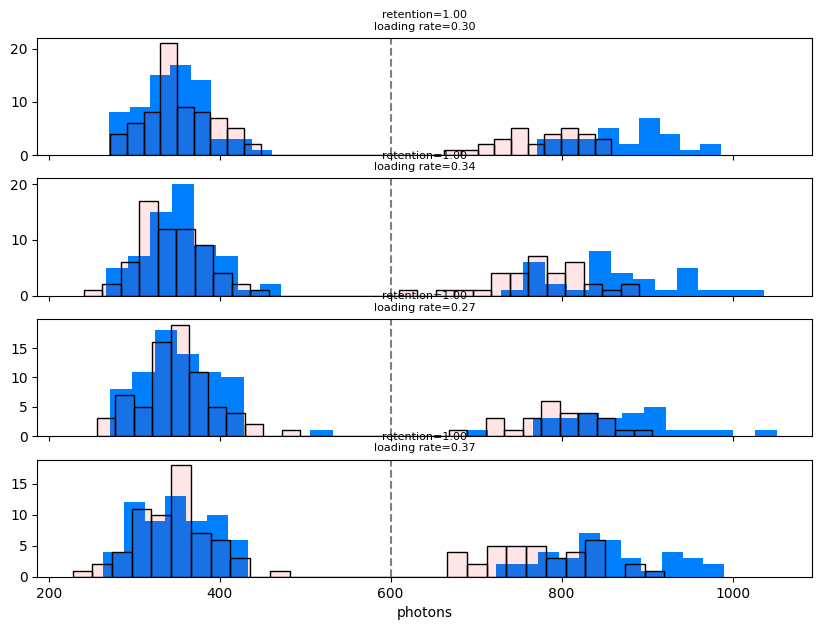

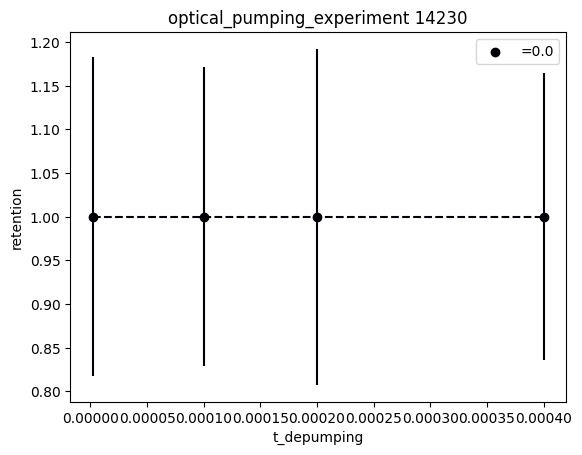

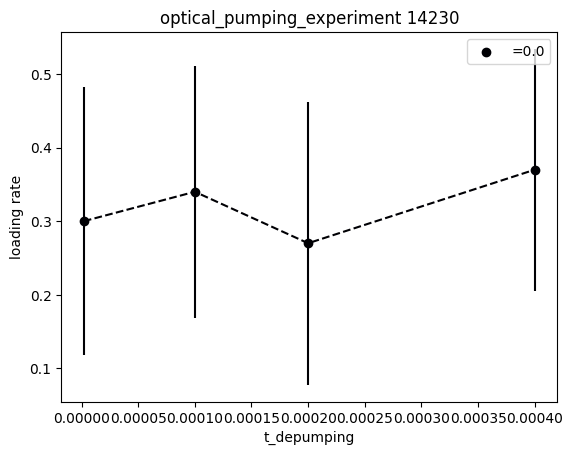

experiment: optical_pumping_experiment
Pumping light off? False


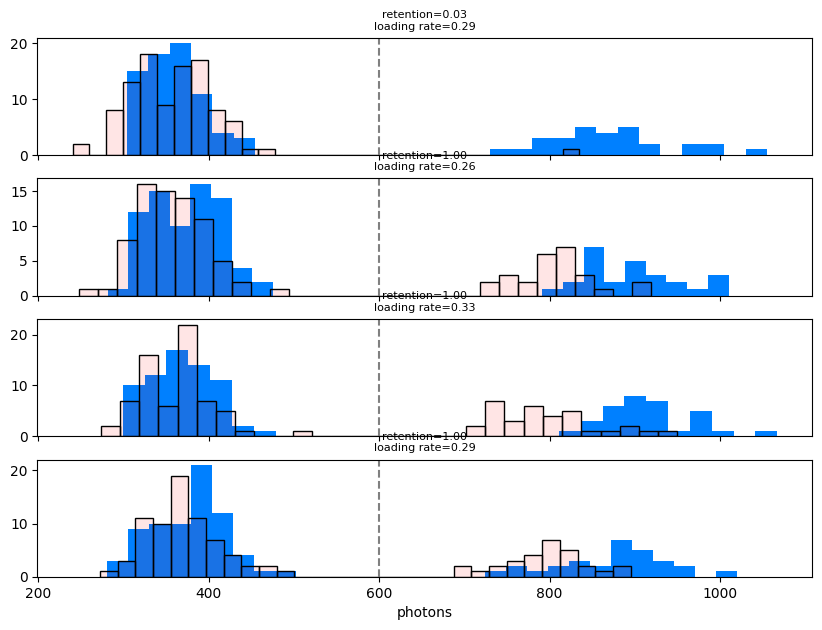

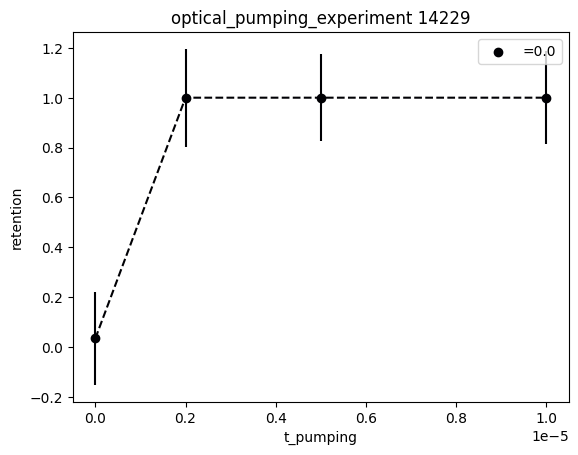

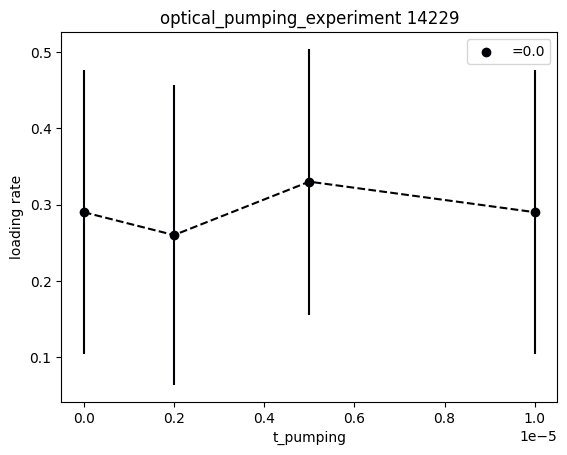

In [35]:
showhist = True
showloading = True
cutoff1=cutoff2 = 40000*t_SPCM_first_shot

depump_file = fnames[4]
pump_file = fnames[3]

for fidx, fname in enumerate([depump_file,pump_file]):

    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    if t_FORT_drop > 0:
        print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
    scan_is_2D = True if scan_variable2_name != '' else False
    iterations = len(scan_sequence1)*len(scan_sequence2)
    
    # print("MOT AOMs on the whole time?", control_experiment)
    # print("Blow-away light off?", blowaway_light_off)
    print("Pumping light off?", pumping_light_off)
    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    # cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    # cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    # units = None
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            ax.axvline(cutoff1,color='grey',linestyle='--')
            # ax.set_ylabel("occurences")
        ax.set_xlabel("photons")
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            plt.xlabel(scan_variable1_name)
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function+f' {rid}')
            plt.show()

    if fidx == 0:
        depump_retention = retention_array
        depump_error = errs
        t_pts_depump = scan_sequence1
    elif fidx == 1:
        pump_retention = retention_array
        t_pts_pump = scan_sequence1
        pump_error = errs


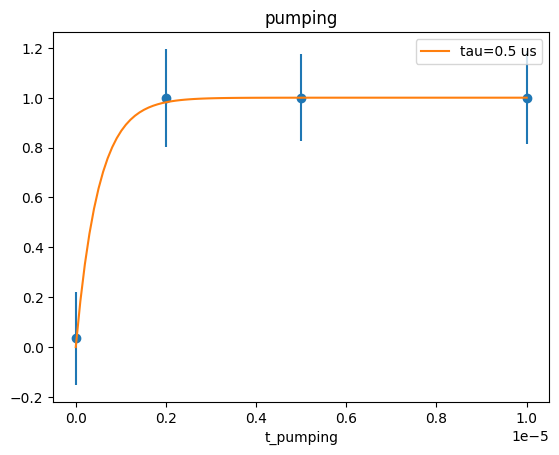

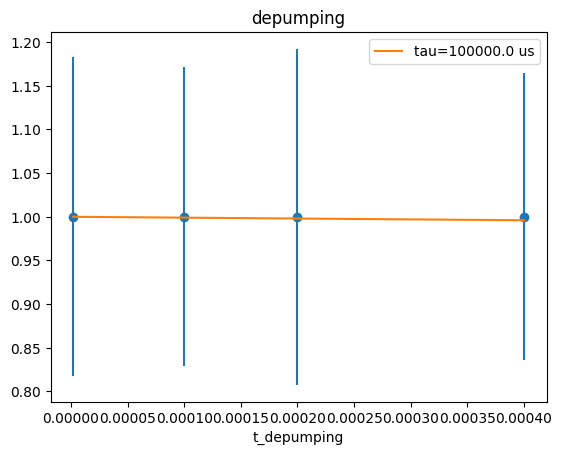

fidelity =  0.9999949989945147


In [41]:
def pump_model(t_pts, r0, tau):
    return r0*(1 - np.exp(-t_pts/tau))

def depump_model(t_pts, r0, tau):
    return r0*np.exp(-t_pts/tau)

# guesses for the fit params
# plt.scatter(t_pts_pump, pump_retention)
# plt.plot(t_pts_pump, pump_model(t_pts_pump, 0.95, 5e-6))
# plt.show()


# plt.scatter(t_pts_depump, depump_retention)
# plt.plot(t_pts_depump, depump_model(t_pts_depump, 0.95, 200e-6))
# plt.show()

popt, pcov = curve_fit(pump_model, t_pts_pump, pump_retention, p0=[0.95,2e-6], 
                           bounds=[[0.8,0.5e-6],[1,10e-6]])
r0_pump, tau_pump = popt

popt, pcov = curve_fit(depump_model, t_pts_depump, depump_retention, p0=[0.95,200e-6], 
                           bounds=[[0.8,50e-6],[1,100000e-6]])
r0_depump, tau_depump = popt

# guesses for the fit params
plt.scatter(t_pts_pump, pump_retention)
plt.errorbar(t_pts_pump, pump_retention, pump_error, ls='none')
t_pts_fit = np.linspace(t_pts_pump[0], t_pts_pump[-1], 100)
plt.plot(t_pts_fit, pump_model(t_pts_fit, r0_pump, tau_pump),label=f'tau={tau_pump*1e6:.1f} us')
plt.xlabel("t_pumping")
plt.title("pumping")
plt.legend()
plt.show()

plt.scatter(t_pts_depump, depump_retention)
plt.errorbar(t_pts_depump, depump_retention, depump_error, ls='none')
t_pts_fit = np.linspace(t_pts_depump[0], t_pts_depump[-1], 100)
plt.plot(t_pts_fit, depump_model(t_pts_fit, r0_depump, tau_depump),label=f'tau={tau_depump*1e6:.1f} us')
plt.xlabel("t_depumping")
plt.title("depumping")
plt.legend()
plt.show()

# subtract 20us for slow shut off of pumping repump AOM
print("fidelity = ",1-tau_pump/(tau_depump-20e-6))

## 2024.05.20

## re-optimizing optical pumping
The coil values are set to give around 3.2 G at the atoms during pumping now, but for experiments before 13965 I accidentally had the optical pumping laser unlocked so disregard those results.

In [29]:
fnames = get_files_by_criteria(date_filters=["2024-05-20"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 10 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\10\000013953-GeneralVariableScan_optical_pumping_scan_over_dummy_variable.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\11\000013955-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\11\000013956-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\13\000013960-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\14\000013962-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-05-20\14\000013965-GeneralVaria

experiment: optical_pumping_experiment
Pumping light off? False


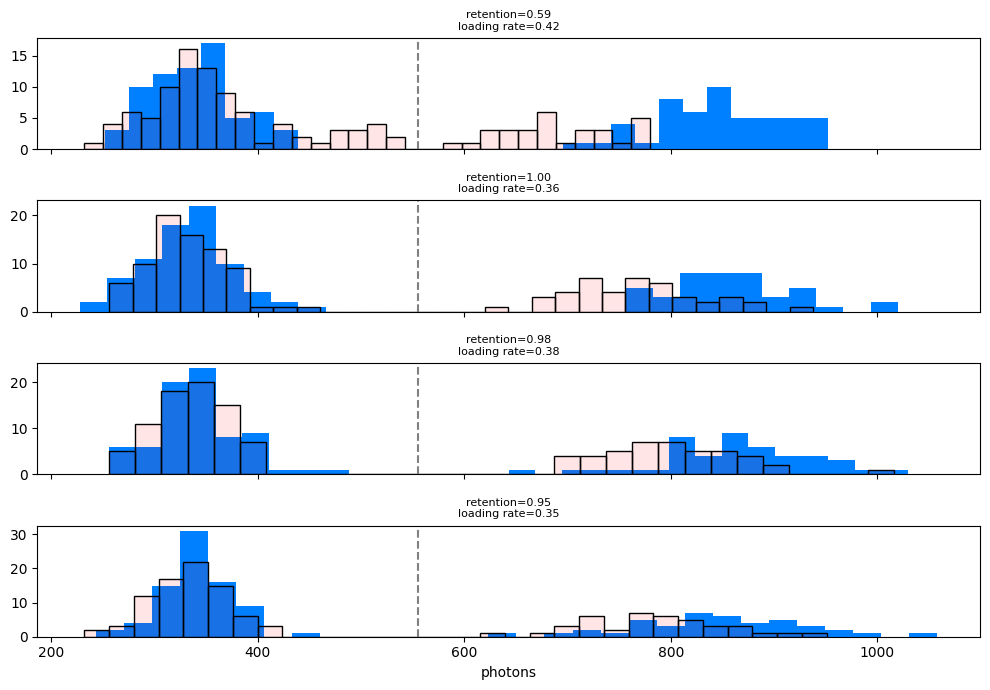

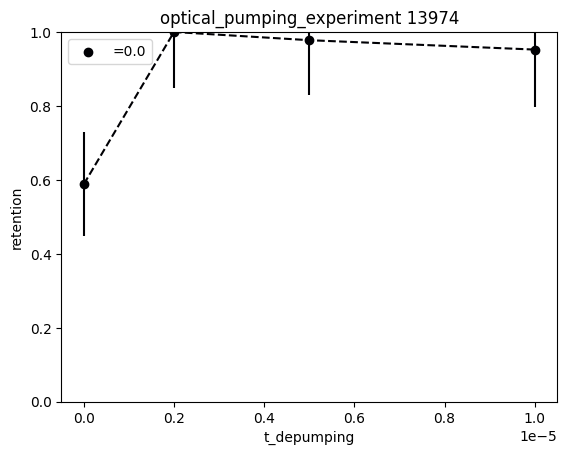

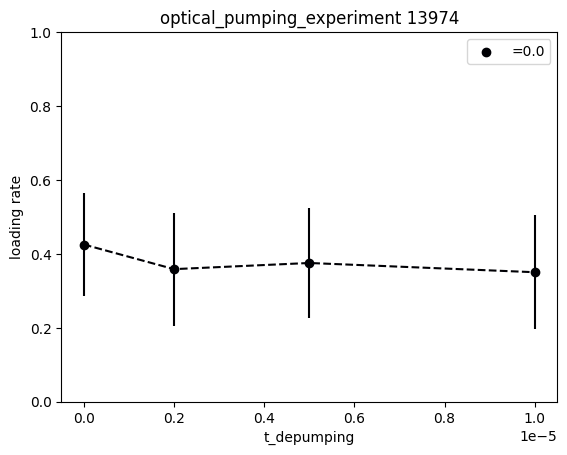

In [32]:
showhist = True
showloading = True

units = None

cutoff1=cutoff2 = 37000*t_SPCM_first_shot

i = 9 # shows that just a small amount of depump period makes the retention after OP almost perfect!

f = h5py.File(os.path.join(results, fnames[i]))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

print("Pumping light off?", pumping_light_off)

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    fig.tight_layout()
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    plt.ylim((0,1))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
        plt.ylim((0,1))
        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

experiment: optical_pumping_experiment
Pumping light off? False


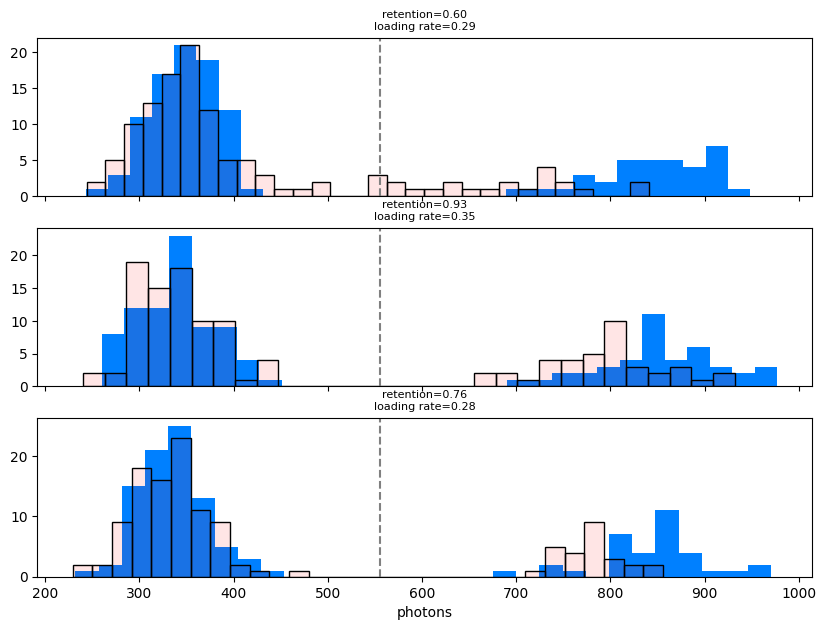

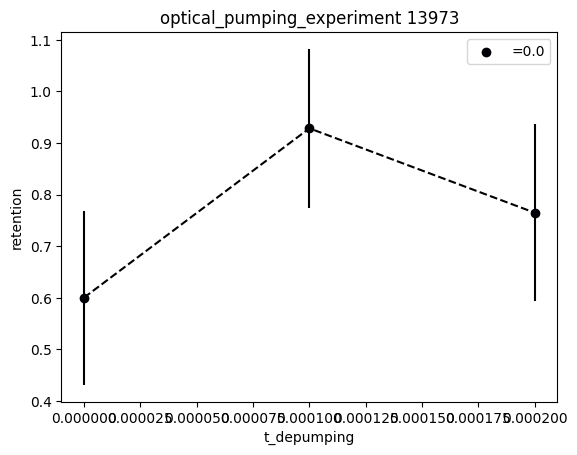

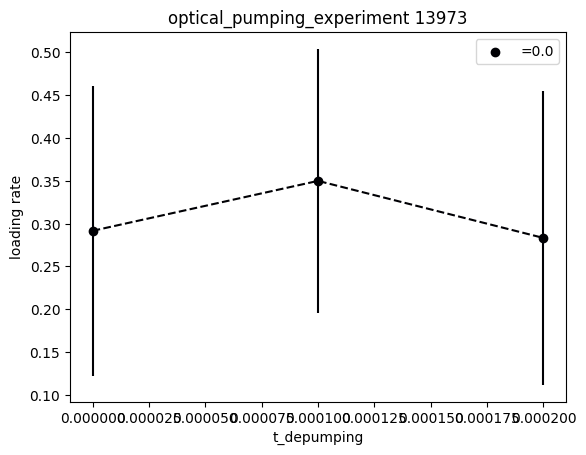

experiment: optical_pumping_experiment
Pumping light off? False


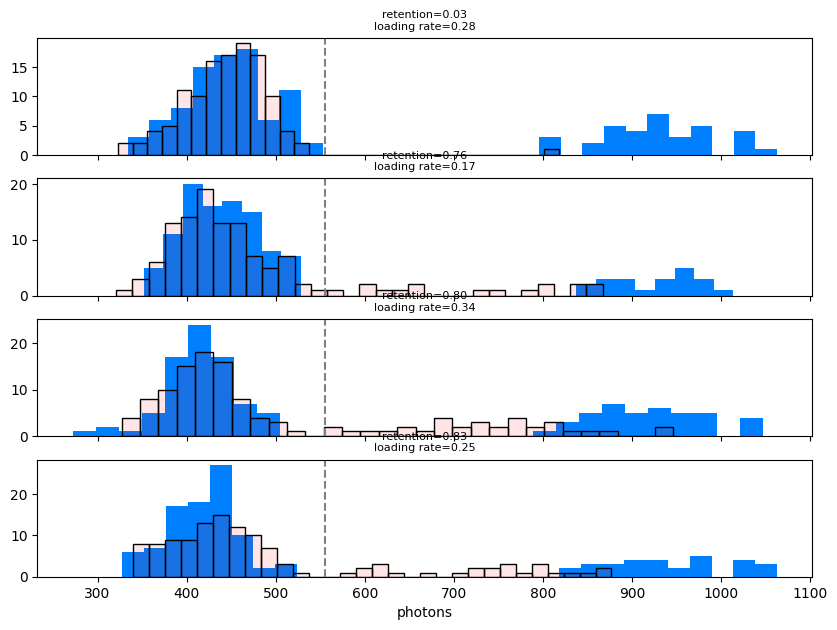

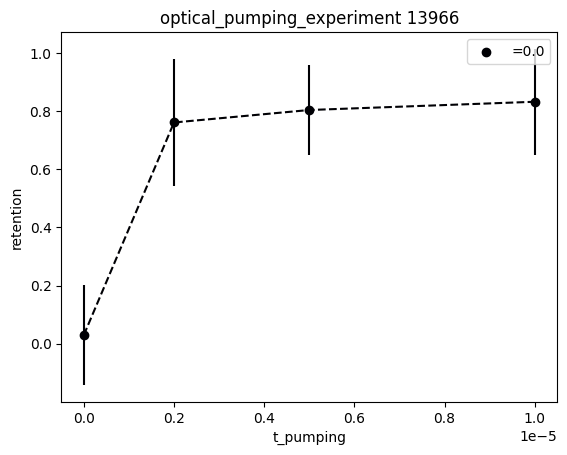

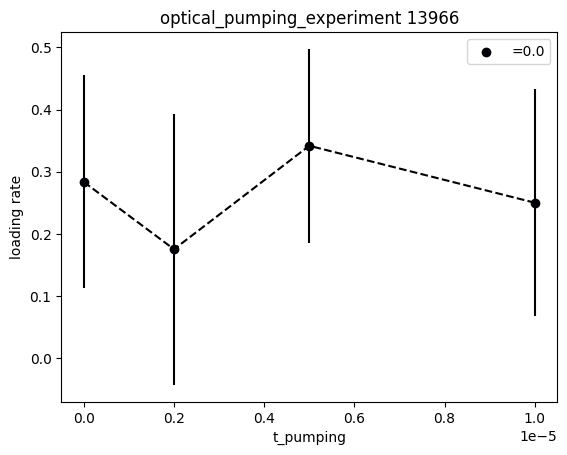

In [24]:
showhist = True
showloading = True

units = None


cutoff1=cutoff2 = 37000*t_SPCM_first_shot

# before running the optimizer on optical pumping
depump_file = fnames[7]
pump_file = fnames[6]

# after running the optimizer on optical pumping
depump_file = fnames[8]
# pump_file = fnames[6]

for fidx, fname in enumerate([depump_file,pump_file]):

    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    if t_FORT_drop > 0:
        print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
    scan_is_2D = True if scan_variable2_name != '' else False
    iterations = len(scan_sequence1)*len(scan_sequence2)
    
    # print("MOT AOMs on the whole time?", control_experiment)
    # print("Blow-away light off?", blowaway_light_off)
    print("Pumping light off?", pumping_light_off)
    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    # cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    # cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            ax.axvline(cutoff1,color='grey',linestyle='--')
            # ax.set_ylabel("occurences")
        ax.set_xlabel("photons")
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            plt.xlabel(scan_variable1_name)
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function+f' {rid}')
            plt.show()

    if fidx == 0:
        depump_retention = retention_array
        depump_error = errs
        t_pts_depump = scan_sequence1
    elif fidx == 1:
        pump_retention = retention_array
        t_pts_pump = scan_sequence1
        pump_error = errs

## 2024.04.30

## computing pumping fidelity
The pumping seems to be good after fixing the chopping sequence and optimizing the shims with the optimizer.

In [382]:
fnames = get_files_by_criteria(date_filters=["2024-04-30"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-30\08\000012705-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-30\09\000012707-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-30\09\000012708-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping


experiment: optical_pumping_experiment
Pumping light off? False


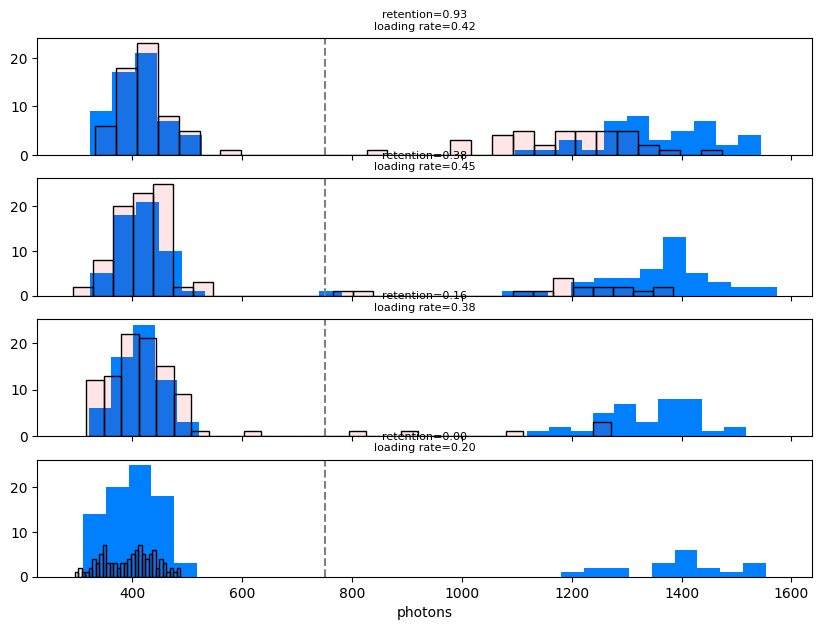

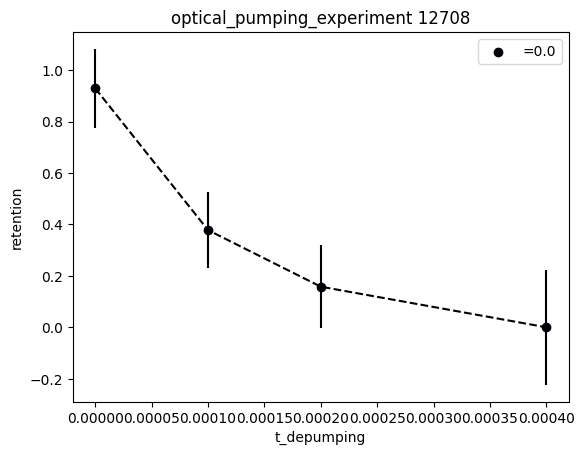

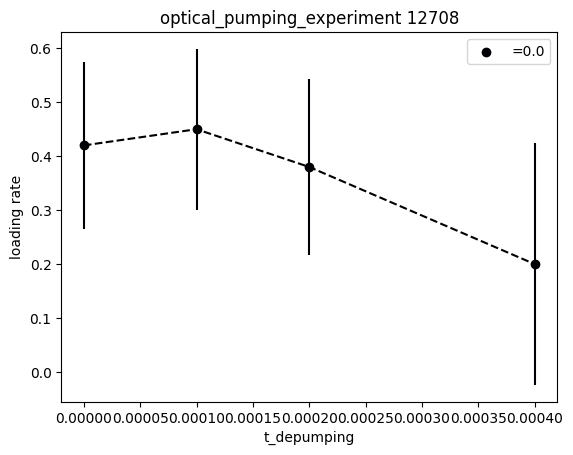

experiment: optical_pumping_experiment
Pumping light off? False


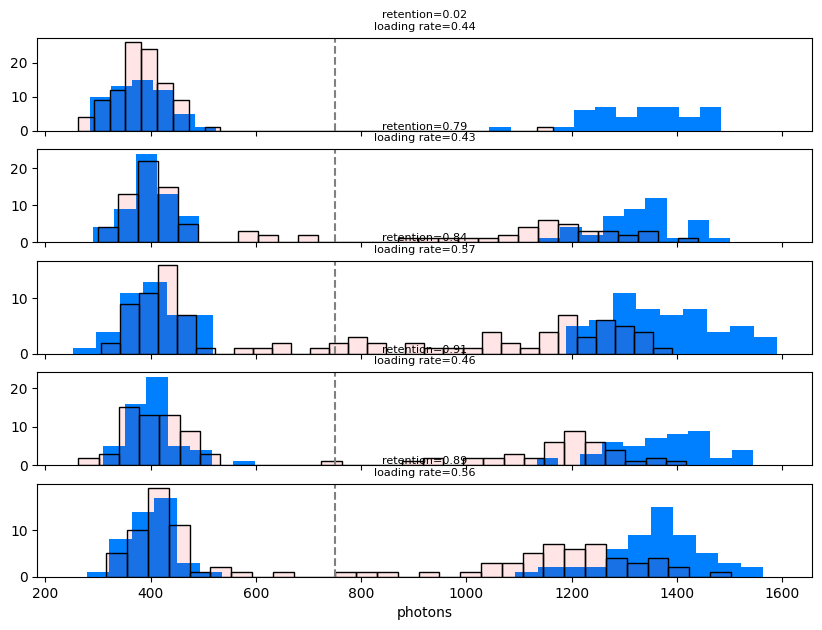

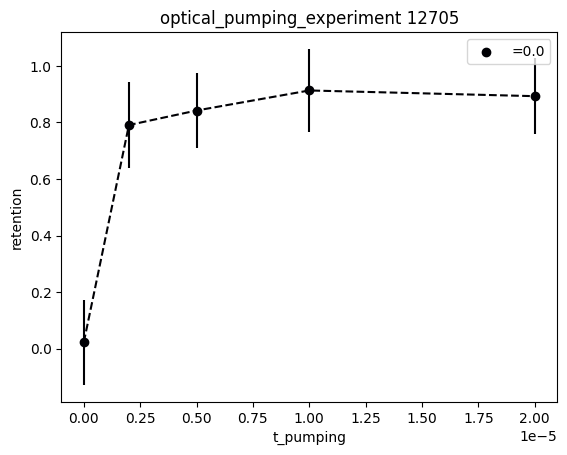

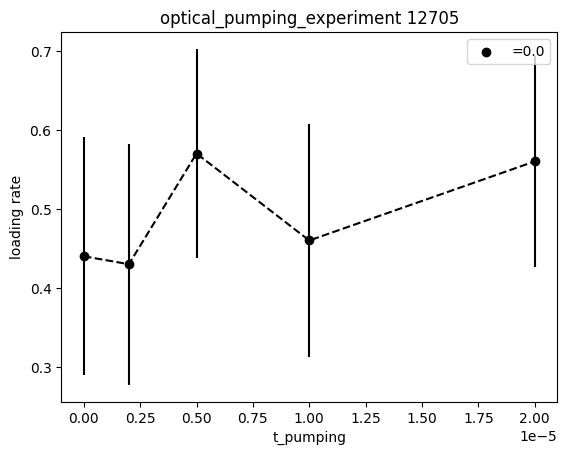

In [383]:
showhist = True
showloading = True

depump_file = fnames[2]
pump_file = fnames[0]

for fidx, fname in enumerate([depump_file,pump_file]):

    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    if t_FORT_drop > 0:
        print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
    scan_is_2D = True if scan_variable2_name != '' else False
    iterations = len(scan_sequence1)*len(scan_sequence2)
    
    # print("MOT AOMs on the whole time?", control_experiment)
    # print("Blow-away light off?", blowaway_light_off)
    print("Pumping light off?", pumping_light_off)
    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    # cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    # cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    cutoff1=cutoff2 = 50000*t_SPCM_first_shot
    # units = None
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            ax.axvline(cutoff1,color='grey',linestyle='--')
            # ax.set_ylabel("occurences")
        ax.set_xlabel("photons")
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            plt.xlabel(scan_variable1_name)
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function+f' {rid}')
            plt.show()

    if fidx == 0:
        depump_retention = retention_array
        depump_error = errs
        t_pts_depump = scan_sequence1
    elif fidx == 1:
        pump_retention = retention_array
        t_pts_pump = scan_sequence1
        pump_error = errs


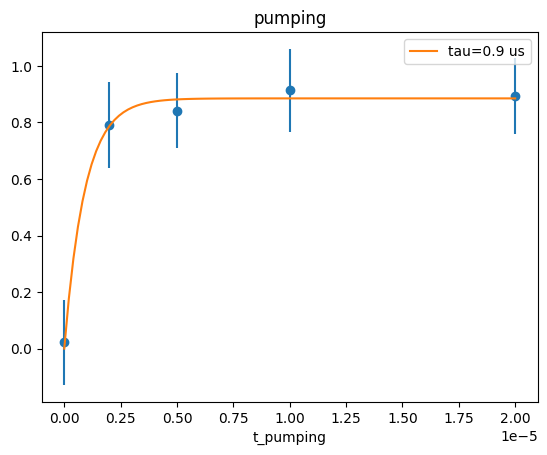

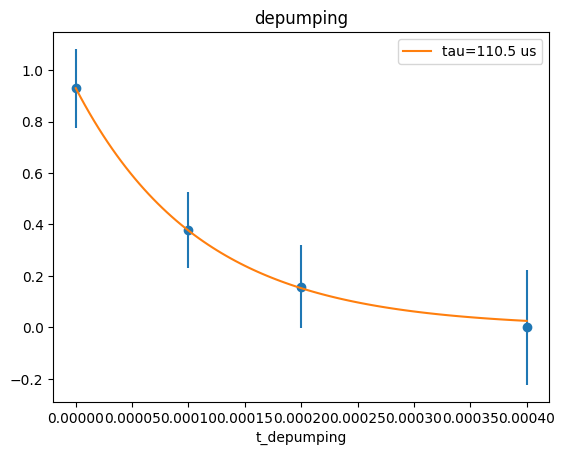

fidelity =  0.9899516105988787


In [384]:
def pump_model(t_pts, r0, tau):
    return r0*(1 - np.exp(-t_pts/tau))

def depump_model(t_pts, r0, tau):
    return r0*np.exp(-t_pts/tau)

# guesses for the fit params
# plt.scatter(t_pts_pump, pump_retention)
# plt.plot(t_pts_pump, pump_model(t_pts_pump, 0.95, 5e-6))
# plt.show()


# plt.scatter(t_pts_depump, depump_retention)
# plt.plot(t_pts_depump, depump_model(t_pts_depump, 0.95, 200e-6))
# plt.show()

popt, pcov = curve_fit(pump_model, t_pts_pump, pump_retention, p0=[0.95,2e-6], 
                           bounds=[[0.8,0.5e-6],[1,10e-6]])
r0_pump, tau_pump = popt

popt, pcov = curve_fit(depump_model, t_pts_depump, depump_retention, p0=[0.95,200e-6], 
                           bounds=[[0.8,50e-6],[1,400e-6]])
r0_depump, tau_depump = popt

# guesses for the fit params
plt.scatter(t_pts_pump, pump_retention)
plt.errorbar(t_pts_pump, pump_retention, pump_error, ls='none')
t_pts_fit = np.linspace(t_pts_pump[0], t_pts_pump[-1], 100)
plt.plot(t_pts_fit, pump_model(t_pts_fit, r0_pump, tau_pump),label=f'tau={tau_pump*1e6:.1f} us')
plt.xlabel("t_pumping")
plt.title("pumping")
plt.legend()
plt.show()

plt.scatter(t_pts_depump, depump_retention)
plt.errorbar(t_pts_depump, depump_retention, depump_error, ls='none')
t_pts_fit = np.linspace(t_pts_depump[0], t_pts_depump[-1], 100)
plt.plot(t_pts_fit, depump_model(t_pts_fit, r0_depump, tau_depump),label=f'tau={tau_depump*1e6:.1f} us')
plt.xlabel("t_depumping")
plt.title("depumping")
plt.legend()
plt.show()

# subtract 20us for slow shut off of pumping repump AOM
print("fidelity = ",1-tau_pump/(tau_depump-20e-6))

## 2024.04.29

## computing pumping fidelity
The pumping seems to be good after fixing the chopping sequence and optimizing the shims with the optimizer.

In [323]:
fnames = get_files_by_criteria(date_filters=["2024-04-29"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

# only_show_i_greater_than = -1
only_show_i_greater_than = 18

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 21 files
file 19 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\17\000012701-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 20 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\17\000012703-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping


experiment: optical_pumping_experiment
Pumping light off? False


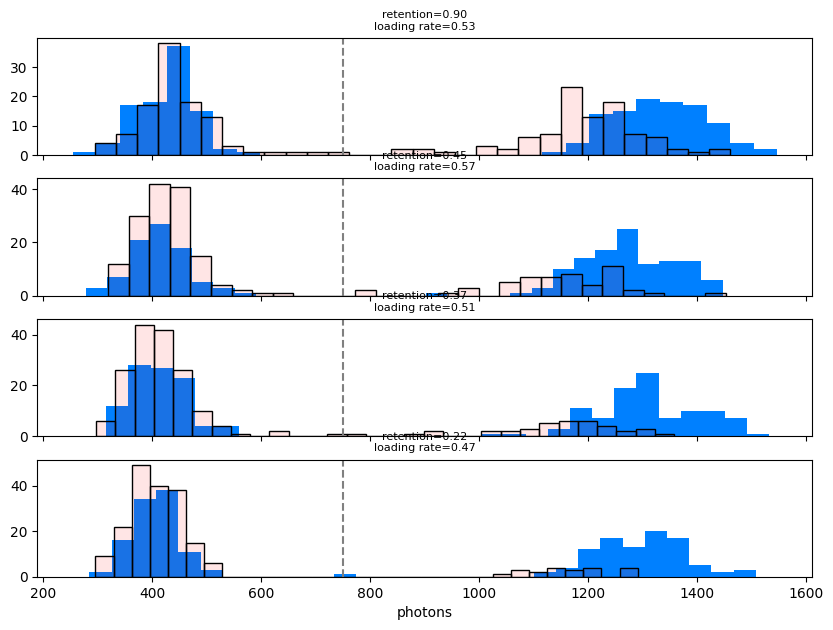

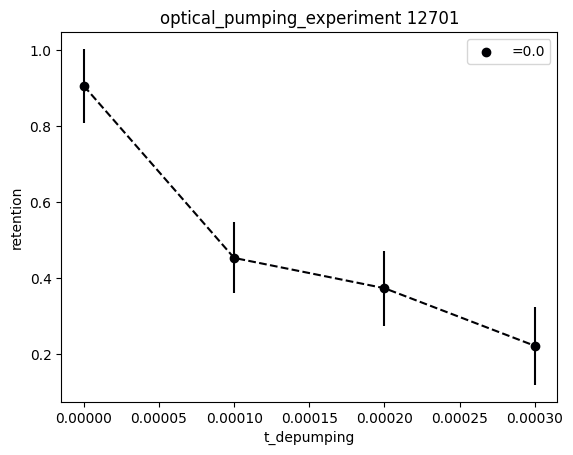

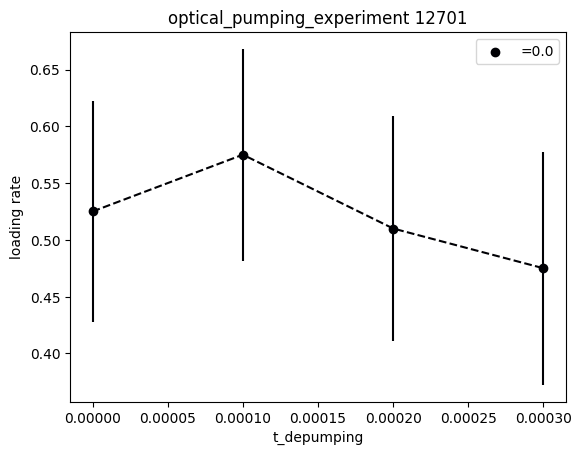

experiment: optical_pumping_experiment
Pumping light off? False


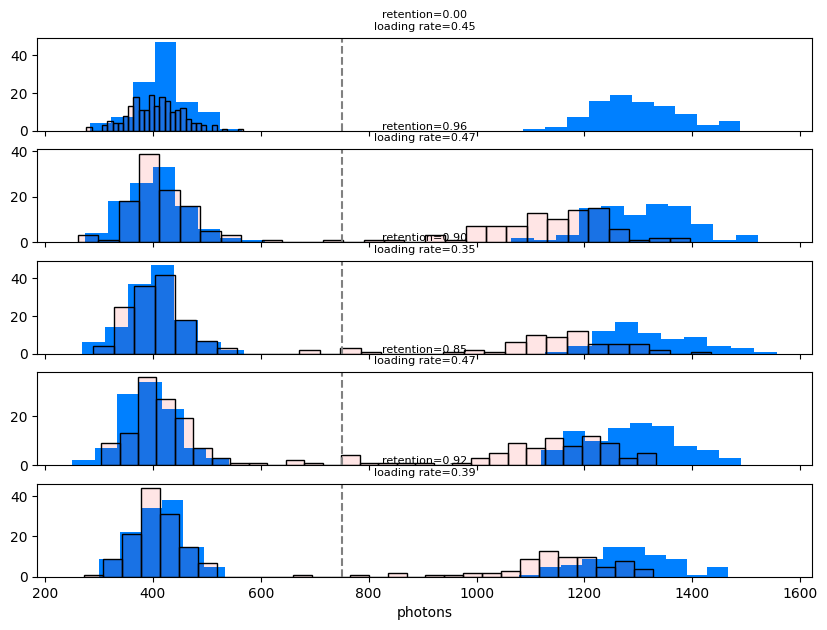

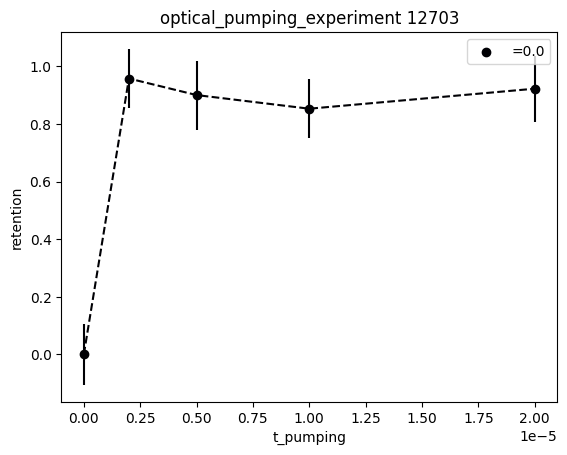

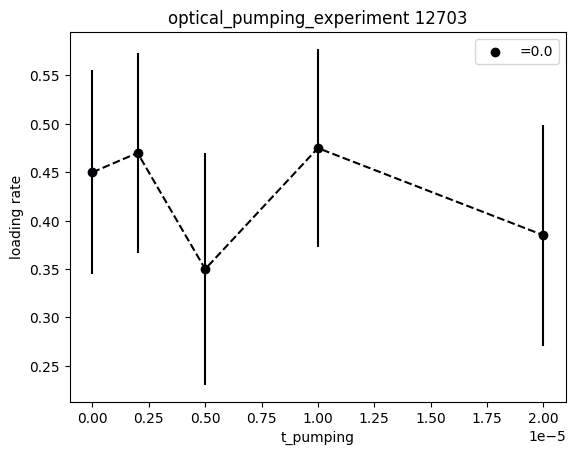

In [377]:
showhist = True
showloading = True

depump_file = fnames[19]
pump_file = fnames[20]

for fidx, fname in enumerate([depump_file,pump_file]):

    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    if t_FORT_drop > 0:
        print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
    scan_is_2D = True if scan_variable2_name != '' else False
    iterations = len(scan_sequence1)*len(scan_sequence2)
    
    # print("MOT AOMs on the whole time?", control_experiment)
    # print("Blow-away light off?", blowaway_light_off)
    print("Pumping light off?", pumping_light_off)
    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    # cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    # cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    
    cutoff1=cutoff2 = 50000*t_SPCM_first_shot
    # units = None
    
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
        for i, ax in enumerate(axes.flat):
            shot1 = photocounts[i*measurements:(i+1)*measurements]
            shot2 = photocounts2[i*measurements:(i+1)*measurements]
            ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
            ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
            ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
            ax.axvline(cutoff1,color='grey',linestyle='--')
            # ax.set_ylabel("occurences")
        ax.set_xlabel("photons")
        plt.show()
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        plt.ylabel("retention")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()
    
    if showloading:
        for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
            plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
            plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
            errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
            plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
            plt.xlabel(scan_variable1_name)
            plt.ylabel("loading rate")
            plt.legend()
            plt.title(experiment_function+f' {rid}')
            plt.show()

    if fidx == 0:
        depump_retention = retention_array
        depump_error = errs
        t_pts_depump = scan_sequence1
    elif fidx == 1:
        pump_retention = retention_array
        t_pts_pump = scan_sequence1
        pump_error = errs


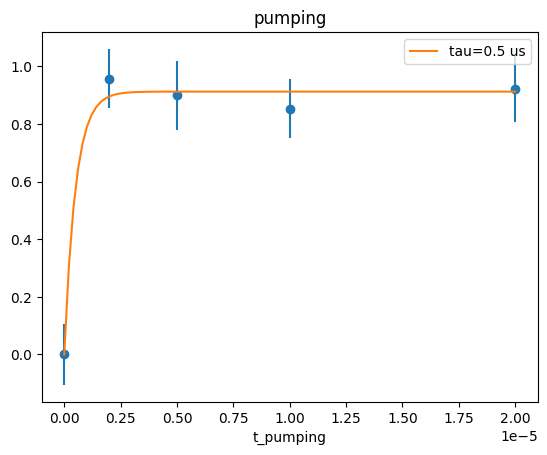

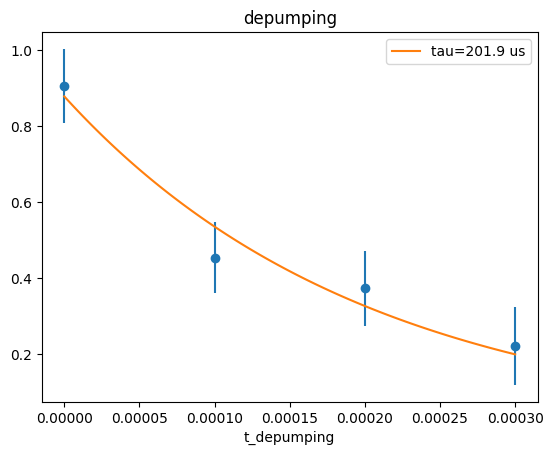

fidelity =  0.9972507546466762


In [381]:
def pump_model(t_pts, r0, tau):
    return r0*(1 - np.exp(-t_pts/tau))

def depump_model(t_pts, r0, tau):
    return r0*np.exp(-t_pts/tau)

# guesses for the fit params
# plt.scatter(t_pts_pump, pump_retention)
# plt.plot(t_pts_pump, pump_model(t_pts_pump, 0.95, 5e-6))
# plt.show()


# plt.scatter(t_pts_depump, depump_retention)
# plt.plot(t_pts_depump, depump_model(t_pts_depump, 0.95, 200e-6))
# plt.show()

popt, pcov = curve_fit(pump_model, t_pts_pump, pump_retention, p0=[0.95,2e-6], 
                           bounds=[[0.8,0.5e-6],[1,10e-6]])
r0_pump, tau_pump = popt

popt, pcov = curve_fit(depump_model, t_pts_depump, depump_retention, p0=[0.95,200e-6], 
                           bounds=[[0.8,50e-6],[1,400e-6]])
r0_depump, tau_depump = popt

# guesses for the fit params
plt.scatter(t_pts_pump, pump_retention)
plt.errorbar(t_pts_pump, pump_retention, pump_error, ls='none')
t_pts_fit = np.linspace(t_pts_pump[0], t_pts_pump[-1], 100)
plt.plot(t_pts_fit, pump_model(t_pts_fit, r0_pump, tau_pump),label=f'tau={tau_pump*1e6:.1f} us')
plt.xlabel("t_pumping")
plt.title("pumping")
plt.legend()
plt.show()

plt.scatter(t_pts_depump, depump_retention)
plt.errorbar(t_pts_depump, depump_retention, depump_error, ls='none')
t_pts_fit = np.linspace(t_pts_depump[0], t_pts_depump[-1], 100)
plt.plot(t_pts_fit, depump_model(t_pts_fit, r0_depump, tau_depump),label=f'tau={tau_depump*1e6:.1f} us')
plt.xlabel("t_depumping")
plt.title("depumping")
plt.legend()
plt.show()

# subtract 20us for slow shut off of pumping repump AOM
print("fidelity = ",1-tau_pump/(tau_depump-20e-6))

## optimizing optical pumping/improving depumping
The blowaway is mostly optimized now, with fewer than 2% of atoms surviving and as much as 97% with and without the blowaway light on, resp. 

First, start with just the pumping repump to see how good the transfer to F=1 is.

In [306]:
fnames = get_files_by_criteria(date_filters=["2024-04-29"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = -1
# only_show_i_greater_than = 16

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

found 19 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\08\000012642-GeneralVariableScan_optical_pumping_scan_over_pumping_light_off.h5) scanned over pumping_light_off
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\08\000012643-GeneralVariableScan_optical_pumping_scan_over_t_depumping.h5) scanned over t_depumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\12\000012655-GeneralVariableScan_optical_pumping_scan_over_dummy_variable.h5) scanned over dummy_variable
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\12\000012663-GeneralVariableScan_optical_pumping_scan_over_dummy_variable.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\12\000012664-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-29\12\

In [ ]:
[('AZ_bottom_volts_OP',-1*V,1*V,'diff'),('AZ_top_volts_OP',-1*V,1*V,'diff'),('AY_volts_OP',-1.*V,1.*V,'diff'),('AX_volts_OP',-1.*V,1.*V,'diff')]

In [320]:
fname = fnames[1] # scan over depump time to check optical pumping fidelity. gives about 150 us depump time, or fidelity 1 - 30/150 = 0.8. Crummy.
# I have now set all OP coils except AY to 0, and am now going to optimize each one.

fname = fnames[10] # after fixing a timing issue with the chopped pumping. this shows the pumping is much faster now, < 20 us, though I had accidentally set a 10 us depump time.
fname = fnames[16] # t_pumping scan. saturates around 10 us, so I'll use 20 us to be safe.
# fname = fnames[17] # depump scan
fname = fnames[18] # depump scan out to longer times



# now I'm 

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

# assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


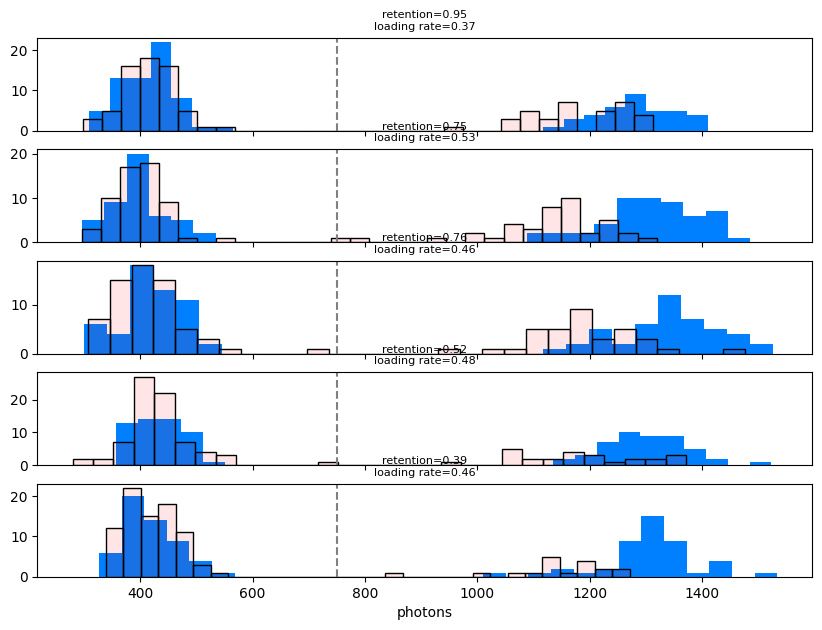

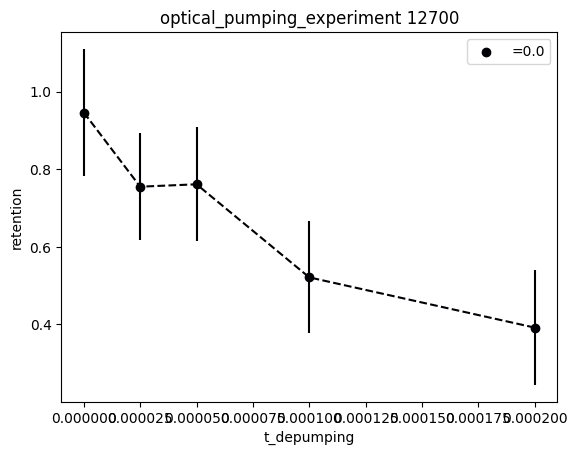

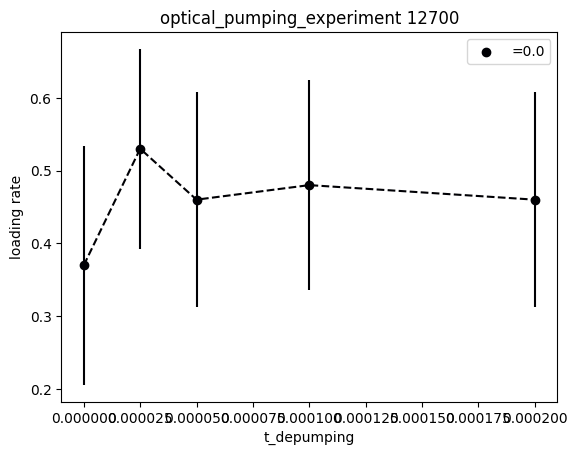

In [321]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

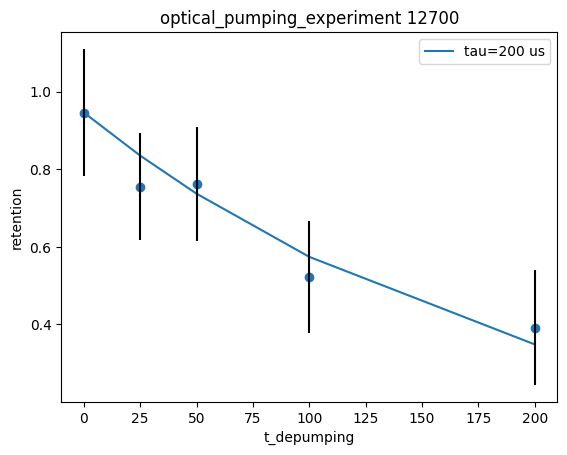

In [322]:
tau = 200*us
plt.title('atom lifetime')
tpts = scan_sequence1*1e6
plt.plot(tpts,retention[0]*np.exp(-scan_sequence1/tau),label=f"tau={tau*1e6:.0f} us")
plt.scatter(tpts,retention)

plt.errorbar(tpts, retention, errs, ls='none',color=cmap(0/len(scan_sequence2)))

plt.xlabel(scan_variable1_name)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_function+f' {rid}')
plt.show()

In [319]:
1 - 10/200

0.95

## 2024.04.27

## optimizing optical pumping
The blowaway is mostly optimized now, with fewer than 2% of atoms surviving and as much as 97% with and without the blowaway light on, resp. 

First, start with just the pumping repump to see how good the transfer to F=1 is.

In [271]:
fnames = get_files_by_criteria(date_filters=["2024-04-27"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

only_show_i_greater_than = 16

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:
            print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\14\000012597-GeneralVariableScan_optical_pumping_scan_over_t_BA_chop_period.h5, which is corrupt
found 24 files
file 17 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\16\000012614-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 18 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\16\000012615-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 19 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\16\000012619-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 20 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\16\000012620-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 21 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\16\000012621-GeneralVariableScan_opt

In [272]:
fname = fnames[17] 
fname = fnames[19] # shows fairly fast transfer to F=1
fname = fnames[22] # look at pumping times up to 10 us

# now I've plugged in the D1 fiber to GRIN 2 and locked the laser. I expect the time to populate F=1 is longer now, as D1 light pumps us into F=2 as well


f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

# assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


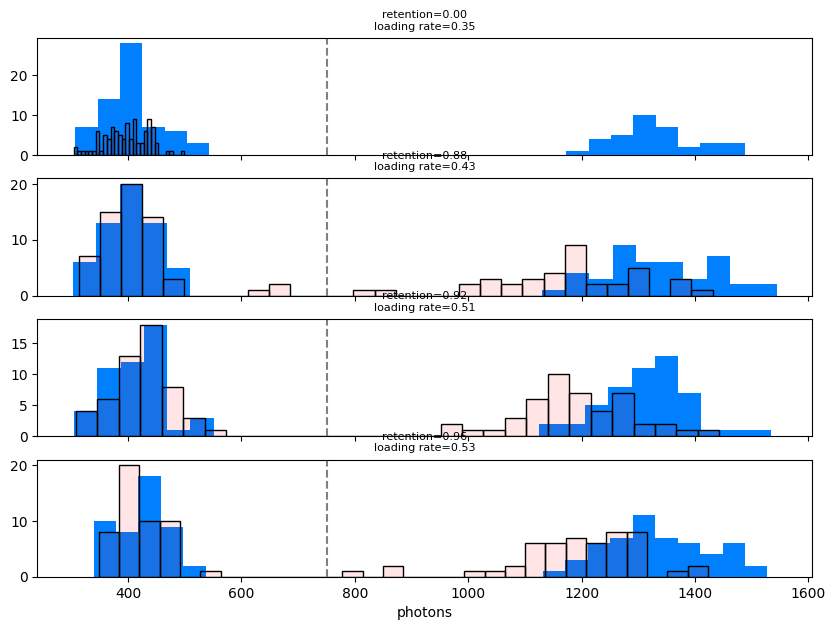

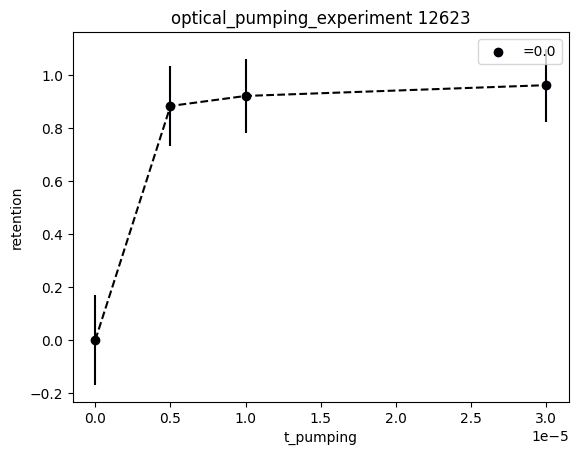

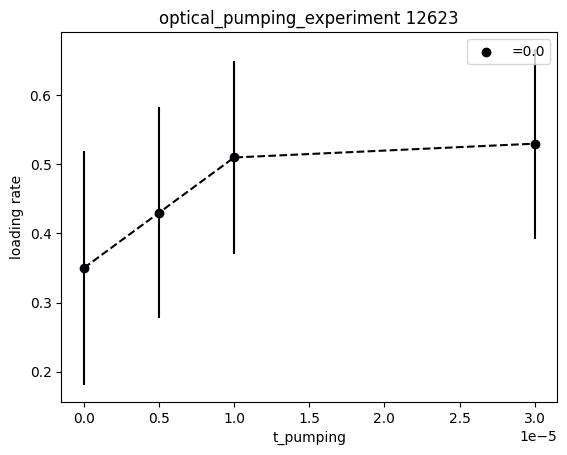

In [273]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

In [270]:
retention

array([0.        , 0.89189189, 0.86111111, 0.94594595])

## debugging heating, retention, and blowaway. no pumping light
Yesterday I mitigated heating from the chopping phase, and it seems that this is no longer causing heating (atom survival is independent of chopping period), most of which was probably caused by turning the trap up.

Reproduce the pumping to F=1 in the last experiment of yesterday, then go from there.

The main conclusion from this session is that there seems to be marginal improvement going to slightly longer chopping periods, and doing chopped blowaway allows us to 

In [251]:
fnames = get_files_by_criteria(date_filters=["2024-04-27"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    try:
        ds = h5py.File(os.path.join(results, f))['datasets']
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\14\000012597-GeneralVariableScan_optical_pumping_scan_over_t_BA_chop_period.h5, which is corrupt
found 17 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\12\000012579-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\13\000012581-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5) scanned over t_pumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\13\000012583-GeneralVariableScan_optical_pumping_scan_over_t_blowaway.h5) scanned over t_blowaway
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\13\000012586-GeneralVariableScan_optical_pumping_scan_over_dummy_variable.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-27\14\000012587-GeneralVariableS

In [253]:
fname = fnames[0] # scanning over t_pumping reproduces pumping seen last night. D1 light is blocked, so we're just getting pumping repump. 
# the pumping we're getting is only 80%, but the second shot histogram is not super clean, so there is likely some heating induced loss
# the heating doesn't get worse with longer pumping though, so it's not due to the pumping repump light

# scan over t_pumping again, but turn off blowaway light and pumping light, which shows that the loss we see
# is not related to photoscatter heating from the pumping or blowaway light
fname = fnames[1]
fname = fnames[2] # shows that blowaway length even without light is causing atom loss
fname = fnames[3] # I implemented a chopped blowaway. this is a dummy variable scan, but statistics aren't great
fname = fnames[4] # scan over t_blowaway to see how bad the chopping loss is
fname = fnames[5] # scan over t_blowaway to see how bad the chopping loss is, longer timescales. this shows even 400 us doesn't necessarily lose the atoms
fname = fnames[6] # scan over t_BA_chop_period, Looks like 1.2*us does better than 1
fname = fnames[8] # scan over t_BA_chop_period. see if going to 1.5 helps here too
fname = fnames[9] # scan over t_blowaway with the BA light on now, and light on bare resonance 2-3. scope shows that the light can't keep up though
fname = fnames[10] # showsthat being close to resonance is important for the blowaway. 
fname = fnames[11] # t_blowaway scan to find a good blowaway time, but now I'm just keeping the cooling DP AOM on continuously during BA. 50 us seems sufficient
fname = fnames[14] # t_blowaway scan to find a good blowaway time again because I can probably go faster. 30 us looks good
fname = fnames[15] # check blowaway light on/off
fname = fnames[16] # check blowaway light on/off with 0, 1, 0, 1 to see consistency

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? True


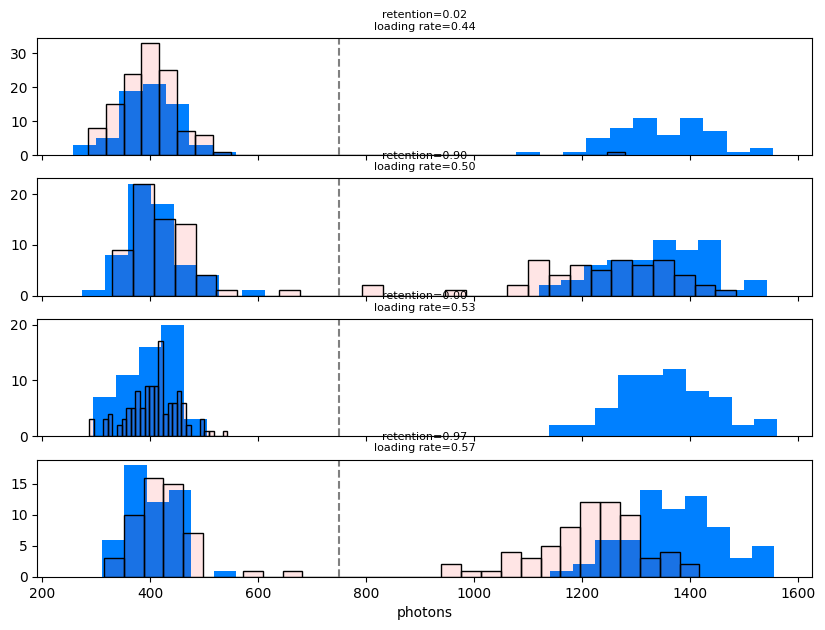

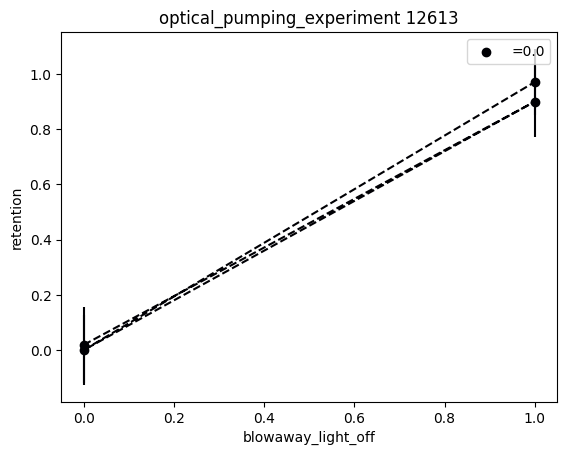

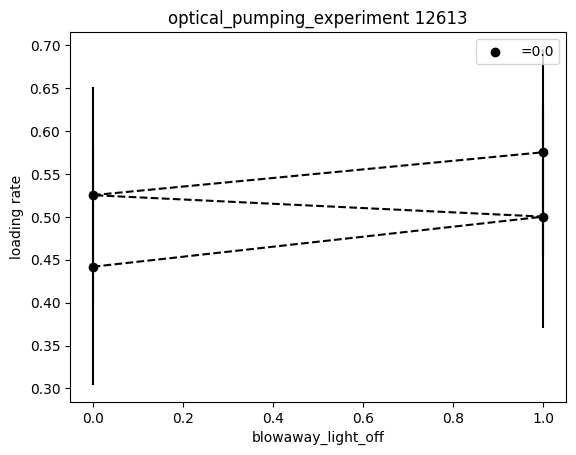

In [254]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot
# units = None

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function+f' {rid}')
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

In [255]:
retention, loading

(array([0.01886792, 0.9       , 0.        , 0.97101449]),
 array([0.44166667, 0.5       , 0.525     , 0.575     ]))

## 2024.04.26

## debugging optical pumping
It seemed like the chopping phase was causing some loss earlier, so I need to diagnose that.

In [213]:
fnames = get_files_by_criteria(date_filters=["2024-04-26"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    try:
        ds = h5py.File(os.path.join(results, f))['datasets']
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

skipping C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\21\000012566-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5, which is corrupt
found 21 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012491-GeneralVariableScan_optical_pumping.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012494-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012495-GeneralVariableScan_optical_pumping.h5) scanned over pumping_light_off
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012497-GeneralVariableScan_optical_pumping.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\17\000012535-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 5 (C:\Netwo

In [172]:
fnames[17]

'C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\2024-04-26\\20\\000012564-GeneralVariableScan_optical_pumping_scan_over_t_pumping.h5'

In [184]:
fname = fnames[15] # scanning over t_pumping with pumping and blowaway light off. should be able to see if the chopping is inducing loss. oops, had blowaway on by mistake.
fname = fnames[17] # blowaway and pumping off, testing whether the chopping induces heating. any amount of t_pumping > 0 results in ~ 60% retention, independent of t_pumping. The FORT is reset to the stabilizer value at the end of OP.
fname = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\2024-04-26\\21\\000012566-GeneralVariableScan.h5" # same as above but I set the FORT power to the RO value at the end of the pumping sequence. retention is much better, and again, independent of time.
# after this, I verified that retention is perfect for the atom_loading_experiment, so the atoms haven't gotten severely hotter or something.
fname = fnames[19] # compare a 20 us chopping sequence with p_FORT_OP = 1 (what I have had previously) to 0.8, which is the readout value. Possible marginal improvement with not turning up the FORT, and the histogram definitely looks better
fname = fnames[20] # pumping scan with pumping light and blowaway on. the D1 isn't plugged into GRIN2 but we should still get transfer to F=1. this will test that

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


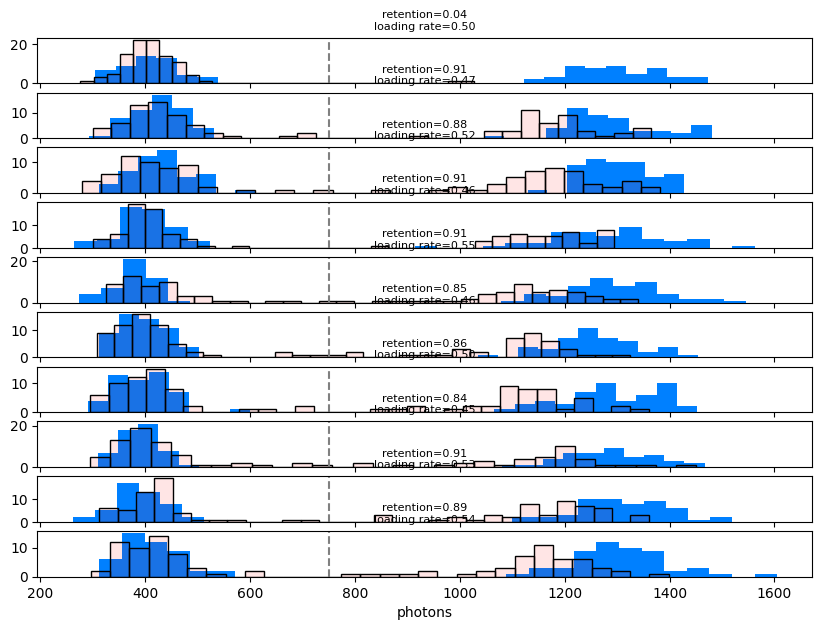

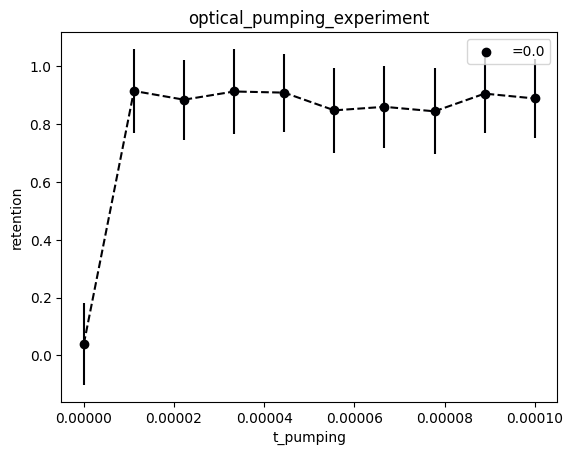

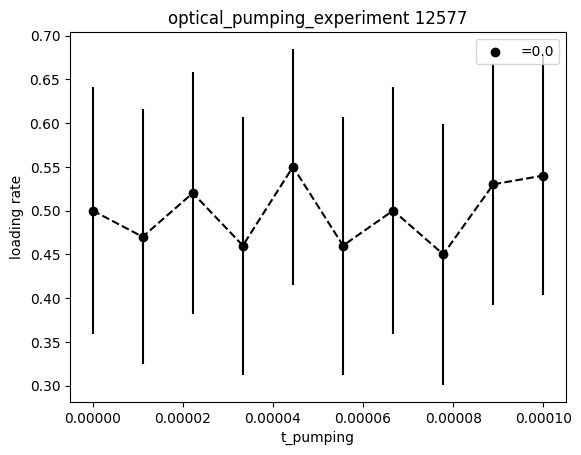

In [185]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

## tuning blow-away again, after I found a bug
I think the mechanism for ejecting all of the atoms because I was pushing them out during the second readout. By mistake, I was not resetting the RF power to AOM 6 after the blowaway.

From this it seems that the best result is obtained if the FORT is lowered during the blowaway as we have been doing, AOM A6 power is turned to -7 dBm for blowaway, and the FORT power is reset to the readout level at the end of the blowaway phase.

In [157]:
fnames = get_files_by_criteria(date_filters=["2024-04-26"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 16 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012491-GeneralVariableScan_optical_pumping.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012494-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012495-GeneralVariableScan_optical_pumping.h5) scanned over pumping_light_off
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012497-GeneralVariableScan_optical_pumping.h5) scanned over dummy_variable
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\17\000012535-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\17\000012536-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 6 (C:\Networking 

In [159]:
fname = fnames[5] # check blowaway contrast. it's terrible, but I also realized that pumping_light_off only affected the D1 light, but the pumping repump was still on
fname = fnames[7] # pumping light is off now but blowaway is bad. the survival probability without the blowaway light is terrible
fname = fnames[9] # pumping light is off now but blowaway is bad. the survival probability without the blowaway light is terrible
fname = fnames[11] # pumping light is off, and t_pumping = 0 now. now when the blowaway light is off, the atoms mostly survive
fname = fnames[12] # pumping light is off, and t_pumping = 0 now. don't change the power in AOM A6. this doesn't do nearly as well.
fname = fnames[13] # pumping light is off, and t_pumping = 0 now. turn blowaway light all the way up. no more proportional factor, just set the AOM to -7 dBm. works much better, but retention not amazing with BA light off
fname = fnames[14] # same as above, but now the FORT is set to the RO power level at the end of the blowaway phase.
fname = fnames[15] # see if blowaway is any different with the FORT power kept at the readout level instead of being lowered. blow-away is a lot worse. could be preferable to go to chopped blowaway.

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? True


In [152]:
AZ_bottom_volts_OP,AZ_top_volts_OP,AX_volts_OP,AY_volts_OP

(-0.16324191913646907,
 -0.9035471067817706,
 0.145791964894871,
 -0.9711953016069096)

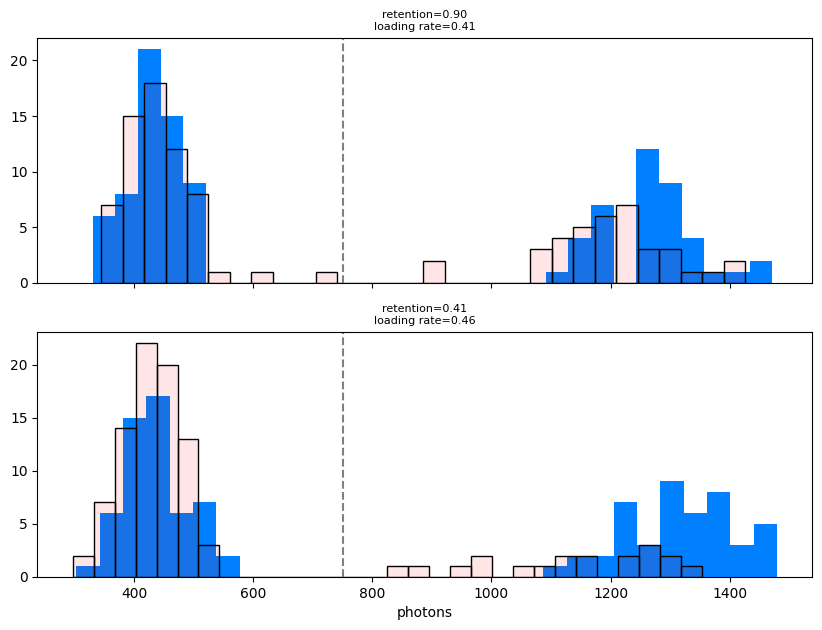

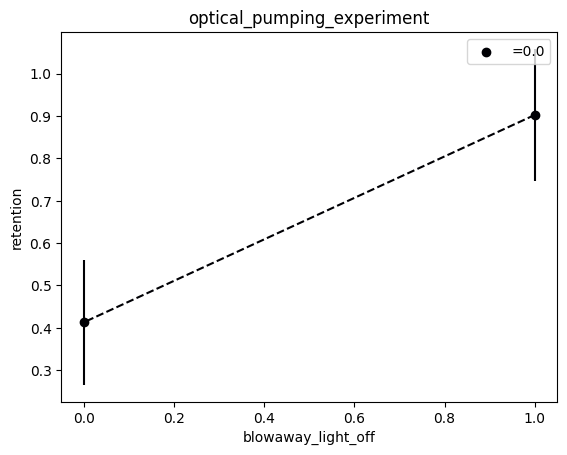

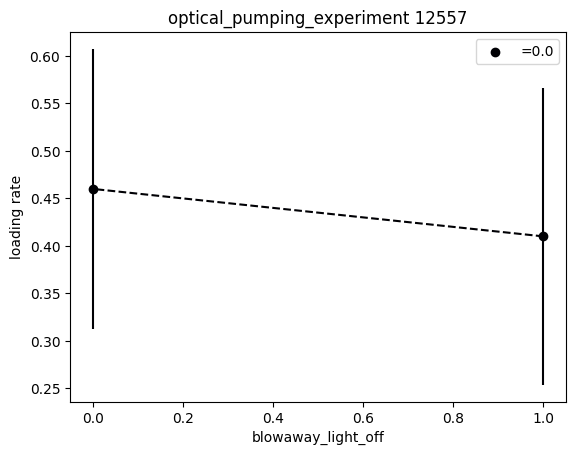

In [160]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
# cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot

cutoff1=cutoff2 = 50000*t_SPCM_first_shot

retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

## debugging pumping sequence
the perfect optical pumping found by the optimizer yesterday seems to have been a fluke. two identical scans over pumping time (see files 11,12 in yesterday's analysis below) showed good pumping despite the coil values having not been updated by the optimizer (that's another issue).

In [110]:
fnames = get_files_by_criteria(date_filters=["2024-04-26"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 3 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012491-GeneralVariableScan_optical_pumping.h5) scanned over dummy_variable
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012494-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-26\10\000012495-GeneralVariableScan_optical_pumping.h5) scanned over pumping_light_off


In [122]:
fname = fnames[1] # check blowaway contrast.
# fname = fnames[2] # check retention with/without the pumping light on-- no difference. wth

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


In [120]:
AZ_bottom_volts_OP,AZ_top_volts_OP,AX_volts_OP,AY_volts_OP

(-0.16324191913646907,
 -0.9035471067817706,
 0.145791964894871,
 -0.9711953016069096)

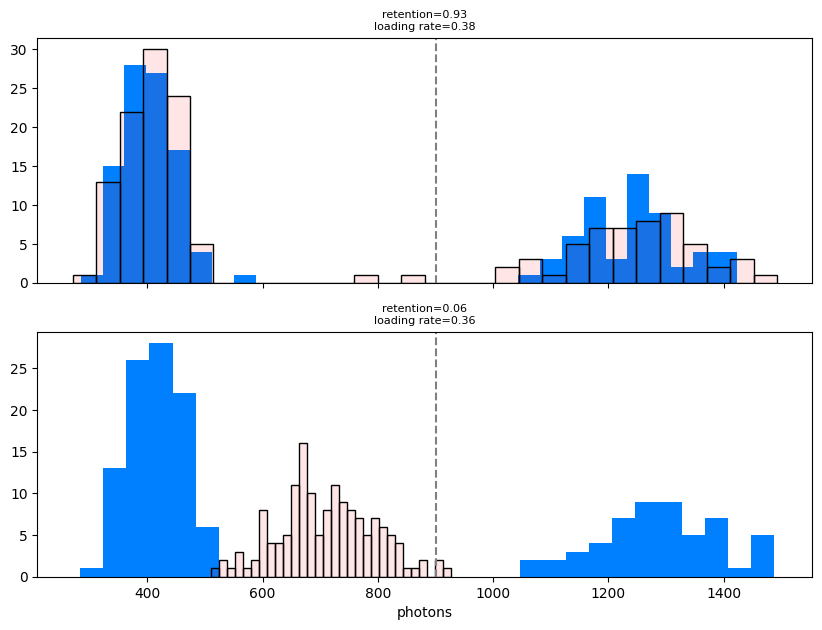

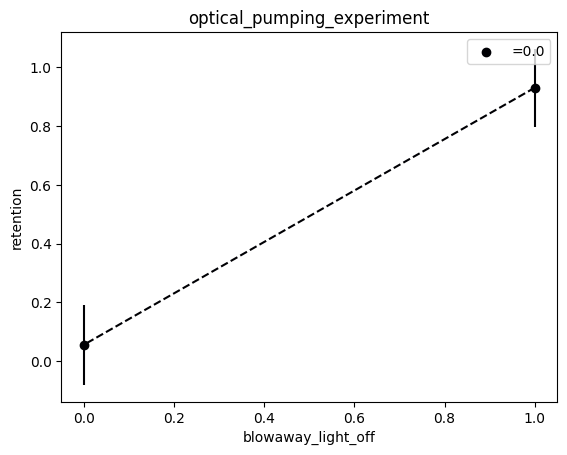

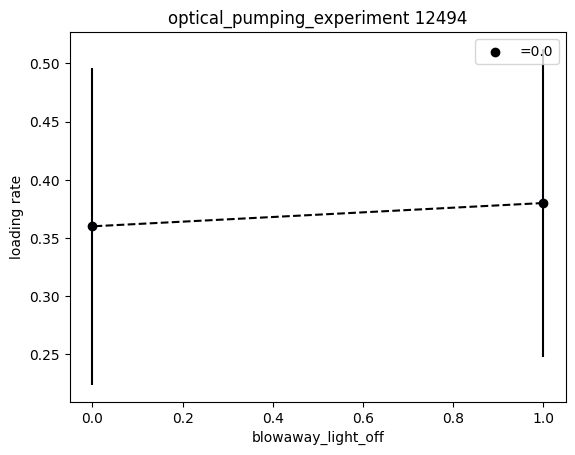

In [123]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

## 2024.04.25

## analyzing optimizer run

> 80% retained for both of these settings of the coils
> [('AZ_bottom_volts_OP',-1*V,1*V,'abs'),('AZ_top_volts_OP',-1*V,1*V,'diff'),('AY_volts_OP',-1.*V,1.*V,'diff'),('AX_volts_OP',-1.*V,1.*V,'diff')]
[ 0.04655464 -0.06081525  1.42029335  0.5652737 ] # run 18
[ 0.03636118 -0.08987305  1.43129602  0.57706167] # run 23

See the section below, file 8 for what the pumping scan looks like after the optimizer's values from step 23 were used.

## debugging pumping sequence
The pumping repump power to the atoms was drifting yesterday, likely because the polarization was badly misaligned. Akbar fixed the polarization alignment with a test fiber. I also coupled the pumping repump more directly over to the chamber, by sending a fiber from the AOM breadboard to the input of the MOT5/6 fiber. Previously we were going through a couple additional fiber splitters. I have also turned up AOMs A5/6 to run at -7 dBm during the pumping phase to have more repump. 

I ran GeneralVariableOptimizer this afternoon to tune the coils, and it got 100% optical pumping with t_pumping=20 us. Files 11 and 12 below are identical scans over t_pumping to test the consistency of the result found by the optimizer.

In [70]:
fnames = get_files_by_criteria(date_filters=["2024-04-25"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 13 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\08\000012443-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\13\000012462-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\13\000012463-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\14\000012464-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\14\000012465-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-25\14\000012466-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 6 (C:\Networking Experiment\artiq codes\artiq-master\results\2

In [104]:
fname = fnames[0] # shows high contrast retention with/without blowaway light. not perfect but good enough for now

# it's clear that after improving the fiber coupling in steady state, the fiber coupling has drifted and acquiesced at maybe 40% of what we acheived in 
fname = fnames[2] # turning pumping RP on at beginning of the pumping function, cranking up AOM A6 only during the puming phase (to see which AOM was mostly responsible for the observed slow rise time)
fname = fnames[3] # turning pumping RP on and cranking up AOM A6 at beginning of the pumping function. there is a small sign of pumping at ~ 50 us.
# fname = fnames[4] # course scan. pumping ~50% at 150 us, but ~0 again by 300 us. see if this is reproducible
fname = fnames[5] # same as above, no pumping signature now.
fname = fnames[6] # same as above, but I unplugged the pumping fiber from GRIN2 so I can monitor the light on a TTI while the experiment runs. we should see perfect blowaway.
fname = fnames[7] # check that blowaway on/off still shows good contrast (the optical pumping fiber is still unplugged). really good still.
fname = fnames[8] # after running M-LOOP, it's clear there is a big improvement, but the amount of pumping at longer times oscillates. I think this might be related to thermal effects changing the fiber coupling
fname = fnames[9] # consistency check shows the pumping is real, but varies from 70% to >90%
fname = fnames[11] # 11 and 12 were scans to show that result found by the optimizer was real, but the coil datasets were actually not updated with the best values. not clear what happened.
# fname = fnames[12] # this means that the pumping here was good for some other reason.

f = h5py.File(os.path.join(results, fname))
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


In [103]:
AZ_bottom_volts_OP,AZ_top_volts_OP,AX_volts_OP,AY_volts_OP

(-0.08686024086237906,
 -0.02364830739942203,
 0.8020618295009376,
 -0.1552467230595802)

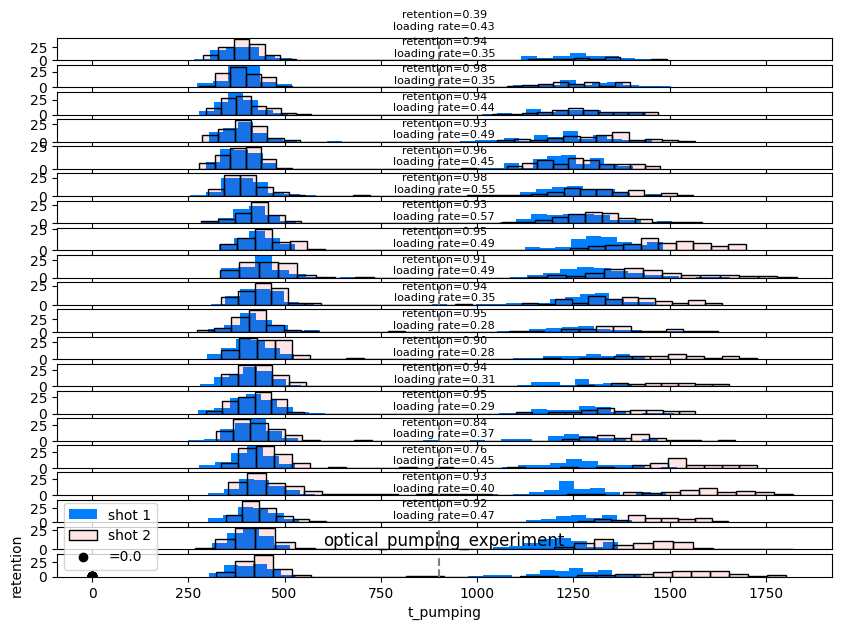

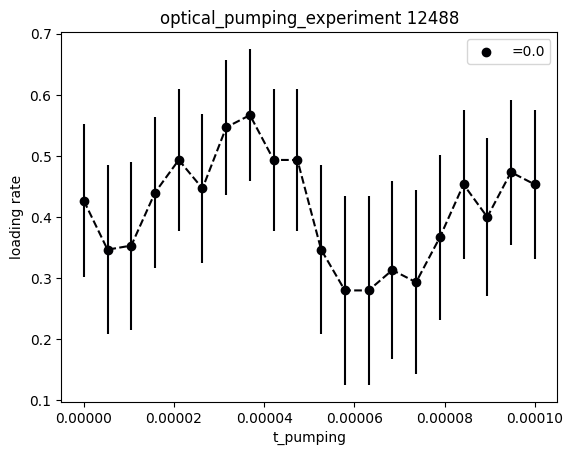

In [100]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7),sharex=True)
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        ax.axvline(cutoff1,color='grey',linestyle='--')
        # ax.set_ylabel("occurences")
    ax.set_xlabel("photons")

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function+f' {rid}')
        plt.show()

In [101]:
AZ_bottom_volts_OP,AZ_top_volts_OP,AX_volts_OP,AY_volts_OP

(-0.08686024086237906,
 -0.02364830739942203,
 0.8020618295009376,
 -0.1552467230595802)

In [82]:
f['rid'][()],us

(12489, 1e-06)

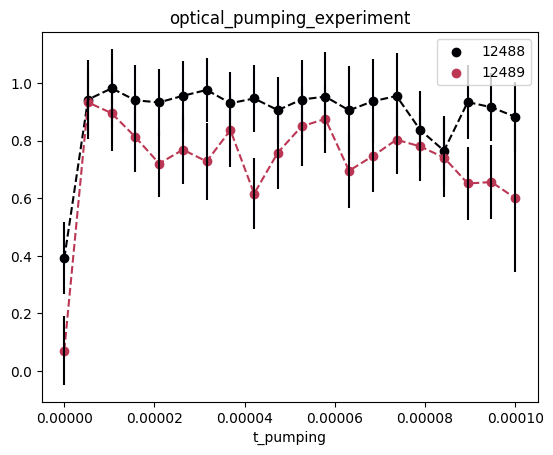

In [81]:
# compare several files
filelist = [fnames[11],fnames[12]]
units = us

scan_offset = 0 # for adjusting x axis values for clarity (e.g. subtracting off 6.834 GHz in a microwave freq scan)
for f_idx, fname in enumerate(filelist):
    f = h5py.File(os.path.join(results, fname))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    iterations = len(scan_sequence1)*len(scan_sequence2)

    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
    cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
    retention_array = np.zeros(iterations)
    loading_rate_array = np.zeros(iterations)
    n_atoms_loaded_array = np.zeros(iterations)
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    
    dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
    if scan_is_2D:
        dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])
    
    measurements = n_measurements #if not control_experiment else n_measurements//2
    
    for i in range(iterations):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1 for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    # plot a retention curve vs variable 1 for each variable 2 value
    cmap = mpl.colormaps['inferno']
    for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
        if scan_is_2D:
            color=cmap(i/len(scan_sequence2))
            label=scan_variable2_name+"="+str(var2)
        else:
            color=cmap(f_idx/len(filelist))
            label=str(rid)
        
        plt.plot(scan_sequence1-scan_offset, retention,color=color,linestyle='--')
        plt.scatter(scan_sequence1-scan_offset, retention,color=color,label=label)
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1-scan_offset, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))
    
        plt.xlabel(scan_variable1_name)
        # plt.ylabel("retention")
        # plt.xlabel(r"$f - f_{\rm clock} (\rm Hz)$")
        # plt.xlim((-7500,-2500))
        # plt.savefig("")
    
        if len(scan_sequence2)>1 or len(filelist)>1:
            plt.legend()
        plt.title(experiment_function)
        # plt.title("microwave spectroscopy")
        # plt.savefig("first_microwave_spectroscopy_signal_expid000012164.png",bbox_inches='tight')
        # plt.show()
plt.show()

In [34]:
fname = fnames[0] # shows high contrast retention with/without blowaway light. not perfect but good enough for now
fname = fnames[2] # about 80% pumping, plateaus after 20 us so we're probably not heating or losing atoms
# fname = fnames[3] # lots of variation and atoms look hot. this is even after the GeneralVariableOptimizer
# fname = fnames[4] # ~ 100% retention for -14 dBm D1 pumping SP, 20 us
# fname = fnames[6] # dummy variable scan. looks like atoms are being heated out of the second shot, and the pumping fidelity is terrible for the same settings that were optimal above


f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


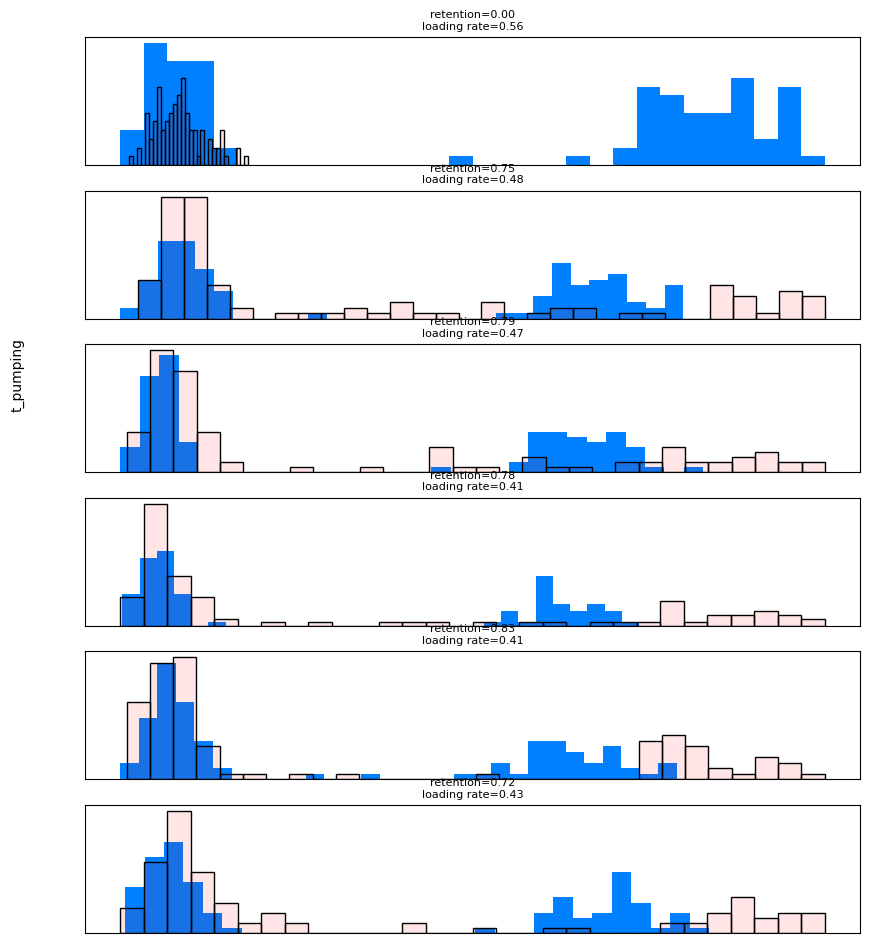

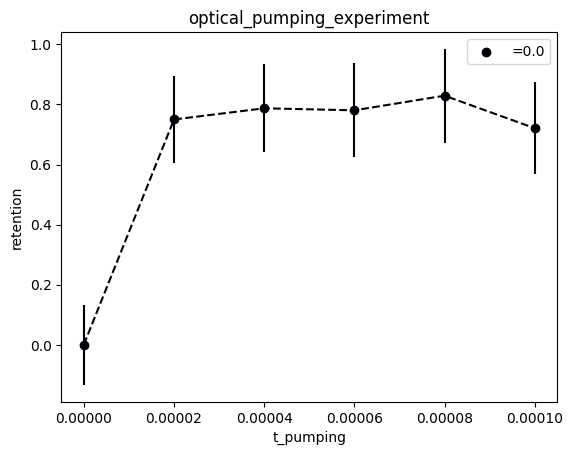

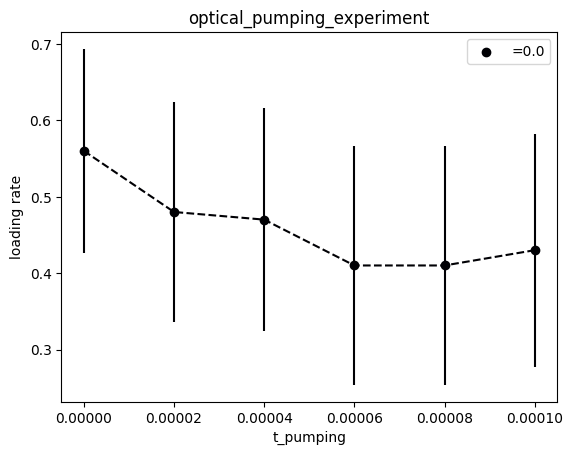

In [29]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2_name)
    fig.text(0.05,0.35, scan_variable1_name,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_function)
    ax.set_xlabel(scan_variable1_name)
    ax.set_ylabel(scan_variable2_name)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function)
        plt.show()

## 2024.04.24

## choptical pumping (chopped opti.. yeah you get it)
to remove uncertainty in the FORT AC Stark shift

the blowaway is tuned now, but let's verify that the atoms pass the blowaway light on/off check with the optical pumping experiment.

In [31]:
fnames = get_files_by_criteria(date_filters=["2024-04-24"], # only find files from these date directories
                               name_filters=["optical_pumping", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 7 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\08\000012413-GeneralVariableScan_optical_pumping.h5) scanned over blowaway_light_off
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\08\000012416-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\08\000012417-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\14\000012424-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\14\000012425-GeneralVariableScan_optical_pumping.h5) scanned over p_D1_pumping_SP
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-24\15\000012428-GeneralVariableScan_optical_pumping.h5) scanned over t_pumping
file 6 (C:\Networking Experiment\artiq codes\artiq-ma

In [28]:
fname = fnames[0] # shows high contrast retention with/without blowaway light. not perfect but good enough for now
fname = fnames[2] # about 80% pumping, plateaus after 20 us so we're probably not heating or losing atoms
# fname = fnames[3] # lots of variation and atoms look hot. this is even after the GeneralVariableOptimizer
# fname = fnames[4] # ~ 100% retention for -14 dBm D1 pumping SP, 20 us
# fname = fnames[6] # dummy variable scan. looks like atoms are being heated out of the second shot, and the pumping fidelity is terrible for the same settings that were optimal above


f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
print("experiment:",experiment_function)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")
scan_is_2D = True if scan_variable2_name != '' else False
iterations = len(scan_sequence1)*len(scan_sequence2)

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(photocounts) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
Pumping light off? False


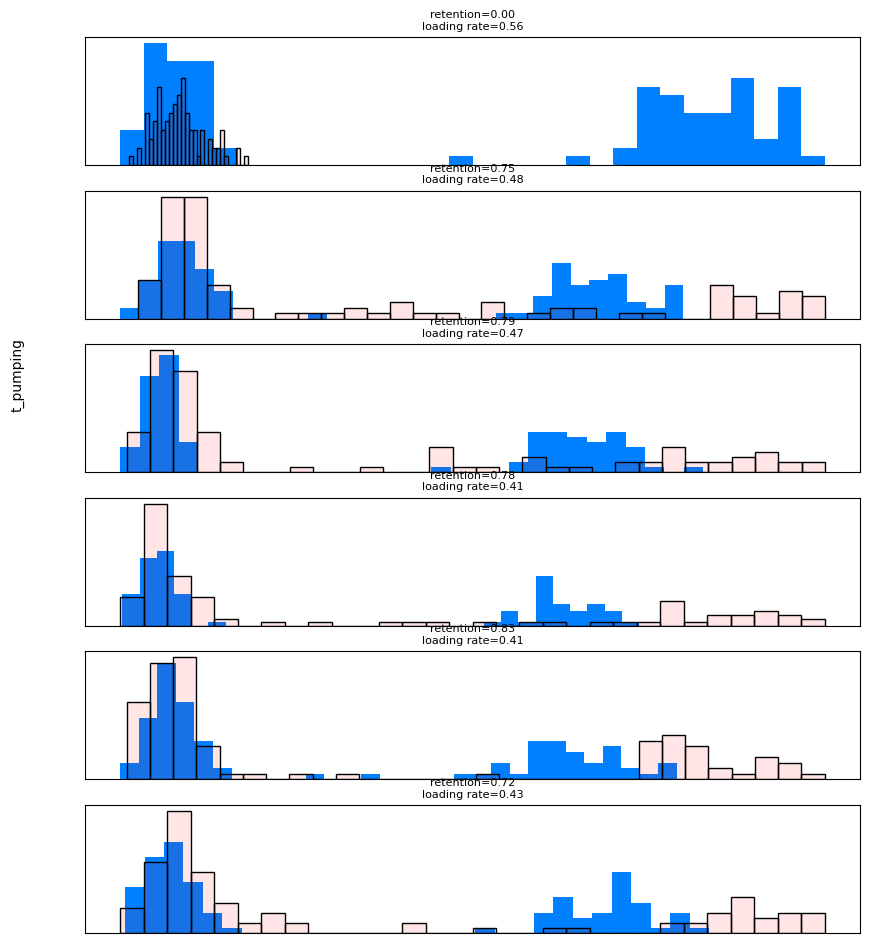

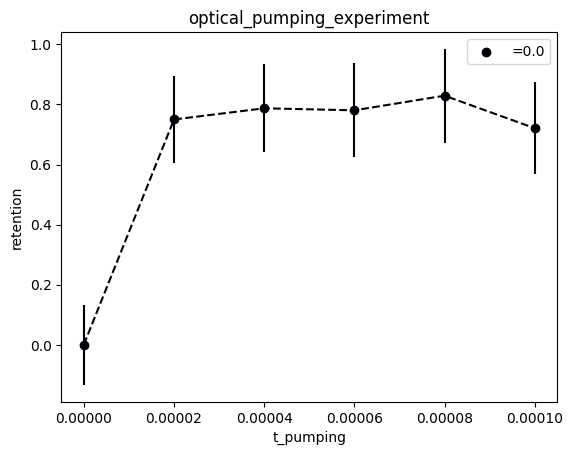

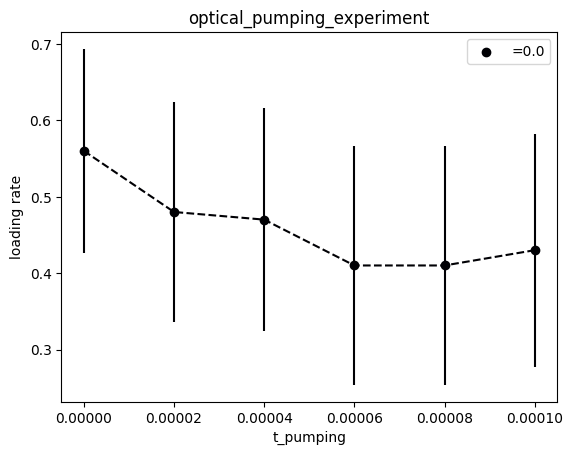

In [29]:
showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = photocounts[i*measurements:(i+1)*measurements]
    shot2 = photocounts2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = photocounts[i*measurements:(i+1)*measurements]
        shot2 = photocounts2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2_name)
    fig.text(0.05,0.35, scan_variable1_name,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_function)
    ax.set_xlabel(scan_variable1_name)
    ax.set_ylabel(scan_variable2_name)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1_name)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_function)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2_name+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1_name)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_function)
        plt.show()

## 2024.04.17

## checking for any signs of optical pumping
the atoms are hot, and we want to zero the B fields at the atoms with microwaves, but finding the microwave dip when the atoms have not been pumped into a single hyperfine state (at least partially) is going to be tough

In [10]:
fnames = get_files_by_criteria(date_filters=["2024-04-17"], # only find files from these date directories
                               name_filters=["microwave_Rabi", "GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    try:
        scan_str = str_from_h5(ds['scan_variable1_name'])
        if str_from_h5(ds['scan_variable2_name']) != '':
            scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
        # print(f"file {i} ({f[72:]}) scanned over "+scan_str)
        print(f"file {i} ({f}) scanned over "+scan_str)
    except:
        print(f"oops... something wrong with {f}")

found 16 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012060-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012061-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\10\000012063-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012066-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012067-GeneralVariableScan_microwave_Rabi.h5) scanned over t_blowaway
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-04-17\11\000012070-GeneralVariableScan_microwave_Rabi.h5) scanned over p_FORT_blowaway
file 6 (C:\Networking Experiment\artiq codes\artiq-m

In [12]:
fname = fnames[13] # shows pumping light off and on. not sure if it is correctly locked.
fname = fnames[14] # probably shows some very weak OP

f = h5py.File(os.path.join(results, fname))
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)
if t_FORT_drop > 0:
    print(f"ATTENTION: retention may be low because of {t_FORT_drop/us} us FORT drop")

if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: microwave_Rabi_experiment


NameError: name 'scan_variable2' is not defined

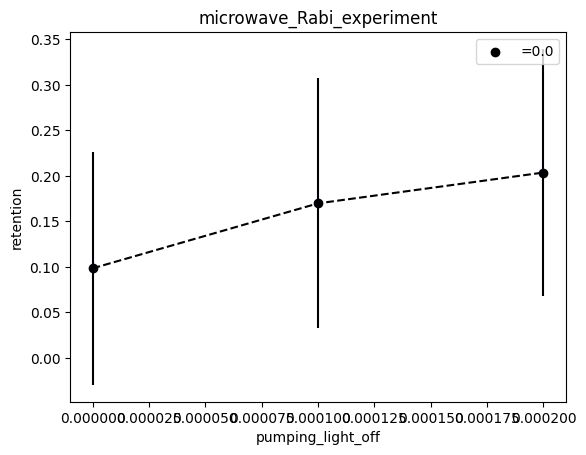

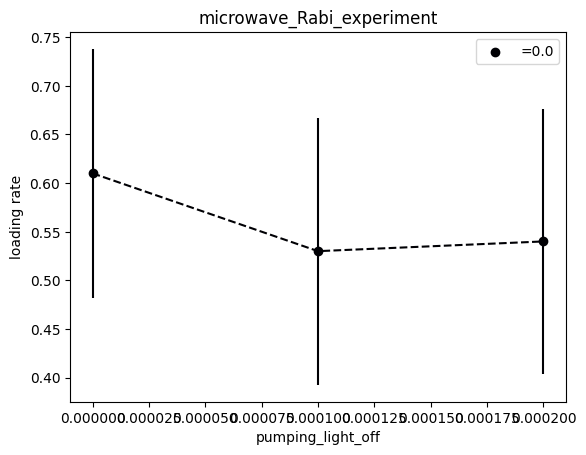

In [37]:
showhist = False
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

## 2024.04.10

In [21]:
fnames = get_files_by_criteria(date_filters=["2024-04-10"], # only find files from these date directories
                               name_filters=["atom_loading"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    scan_str = str_from_h5(ds['scan_variable1_name'])
    if str_from_h5(ds['scan_variable2_name']) != '':
        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
    print(f"file {i} scanned over "+scan_str)

found 18 files
file 0 scanned over f_cooling_DP_RO
file 1 scanned over f_cooling_DP_RO
file 2 scanned over f_cooling_DP_RO
file 3 scanned over f_cooling_DP_RO
file 4 scanned over f_cooling_DP_RO
file 5 scanned over f_cooling_DP_RO
file 6 scanned over f_cooling_DP_RO
file 7 scanned over f_cooling_DP_RO
file 8 scanned over f_cooling_DP_RO
file 9 scanned over t_SPCM_first_shot
file 10 scanned over t_SPCM_first_shot
file 11 scanned over t_SPCM_first_shot
file 12 scanned over p_cooling_DP_RO
file 13 scanned over p_cooling_DP_RO
file 14 scanned over t_MOT_dissipation
file 15 scanned over dummy_variable
file 16 scanned over AX_volts_RO
file 17 scanned over AY_volts_RO


In [22]:
fname = fnames[9]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: atom_loading_experiment
t_SPCM_first_shot [0.007      0.00844444 0.00988889 0.01133333 0.01277778 0.01422222
 0.01566667 0.01711111 0.01855556 0.02      ]
 [0.]


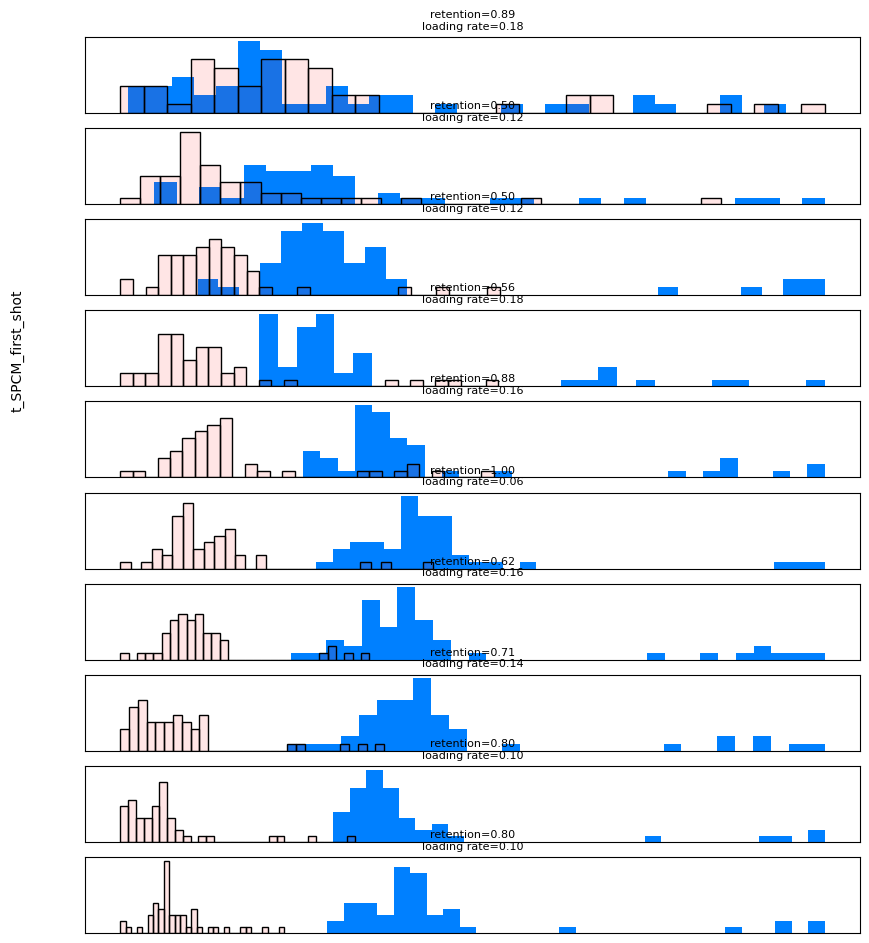

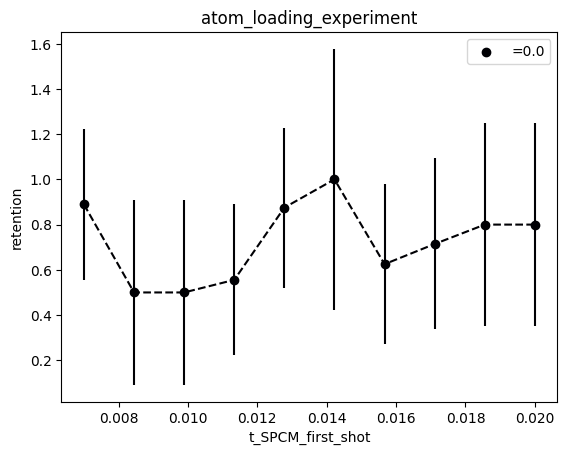

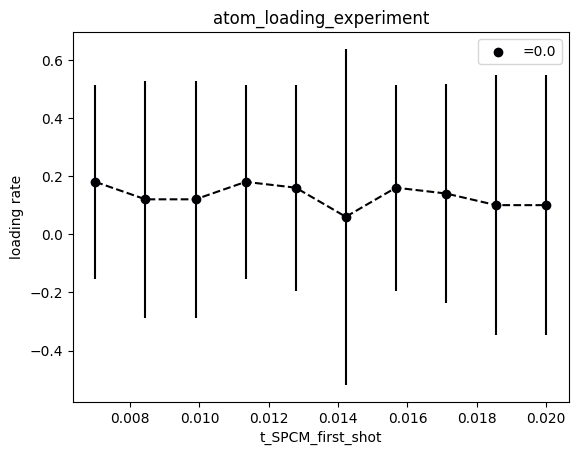

In [23]:
# caution: don't copy the cell below for other variable scans, since the readout time t_SCPM_first_shot changes how we calculate the atom theshold for each step

showhist = True
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
# cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]

    # THIS IS ONLY VALID IF WE ARE SCANNING THE FIRST READOUT TIME
    cutoff1 = single_atom_counts_per_s*scan_sequence1[i]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

## scan over readout detuning - just testing this notebook

In [16]:
fname = fnames[7]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
t_SPCM_first_shot = np.float64(f['archive']['t_SPCM_first_shot'])
t_SPCM_second_shot = np.float64(f['archive']['t_SPCM_second_shot'])
single_atom_counts_per_s = np.uint(f['archive']['single_atom_counts_per_s'])

scan_variable1 = str_from_h5(f['datasets']['scan_variable1_name'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

try:
    scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
except:
    scan_sequence1 = np.array(f['datasets']['scan_sequence1'])

scan_variable2 = str_from_h5(f['datasets']['scan_variable2_name'])
if scan_variable2 != '':
    try:
        scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    except:
        scan_sequence2 = np.array(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: atom_loading_experiment
f_cooling_DP_RO [1.20e+08 1.21e+08 1.22e+08 1.23e+08 1.24e+08 1.25e+08]
 [0.]


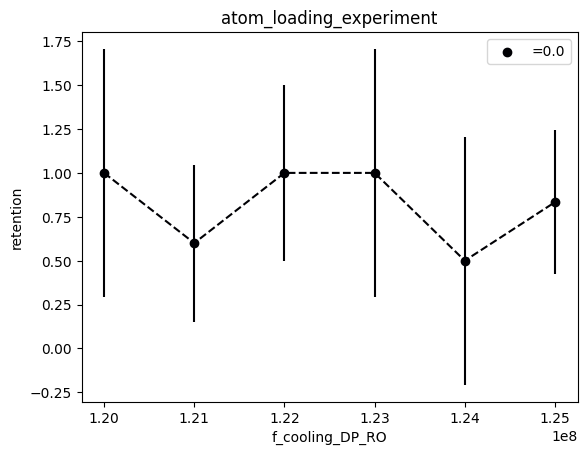

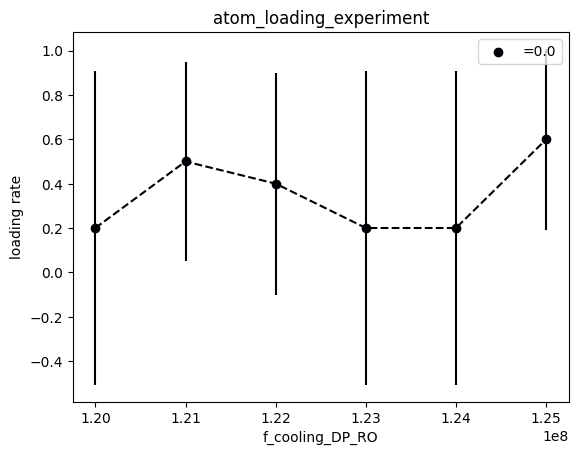

In [17]:
showhist = False
showloading = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = single_atom_counts_per_s*t_SPCM_first_shot
cutoff2 = single_atom_counts_per_s*t_SPCM_second_shot
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))

    plt.xlabel(scan_variable1)
    plt.ylabel("retention")
    plt.legend()
    plt.title(experiment_name)
    plt.show()

if showloading:
    for i, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        plt.plot(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, loading,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, loading, errs, ls='none',color=cmap(i/len(scan_sequence2)))

        plt.xlabel(scan_variable1)
        plt.ylabel("loading rate")
        plt.legend()
        plt.title(experiment_name)
        plt.show()

## January 2024

In [15]:
fnames = get_files_by_criteria(date_filters=["2024-01-22"], # only find files from these date directories
                               name_filters=["optical_pumping"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    scan_str = str_from_h5(ds['scan_variable1'])
    if str_from_h5(ds['scan_variable2']) != '':
        scan_str += ", " +str_from_h5(ds['scan_variable2'])
    print(f"file {i} scanned over "+scan_str)

found 2 files
file 0 scanned over p_FORT_OP, t_pumping
file 1 scanned over p_FORT_OP, t_pumping


In [16]:
fname = fnames[1]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
if scan_variable2 != '':
    scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
p_FORT_OP [0.4 0.6 0.8 1. ]
t_pumping [0.00e+00 5.00e-05 1.25e-04]


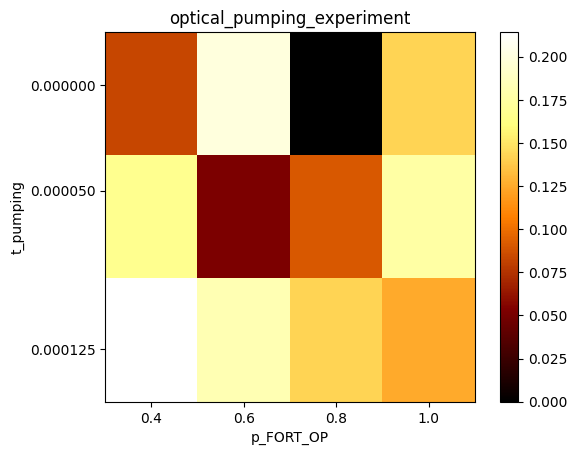

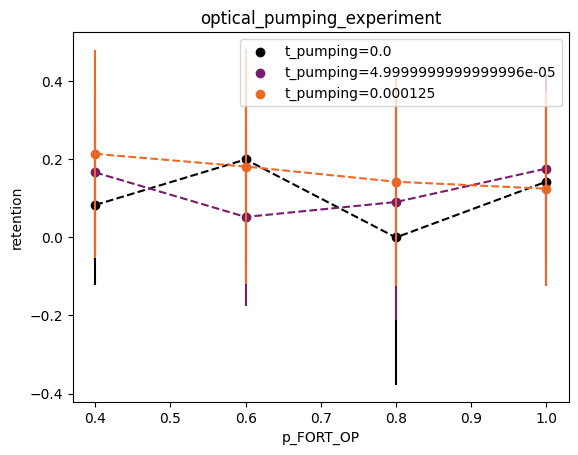

In [17]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 270
cutoff2 = 270
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

### 2024.01.20

In [10]:
fnames = get_files_by_criteria(date_filters=["2024-01-20"], # only find files from these date directories
                               name_filters=["optical_pumping"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    ds = h5py.File(os.path.join(results, f))['datasets']
    scan_str = str_from_h5(ds['scan_variable1'])
    if str_from_h5(ds['scan_variable2']) != '':
        scan_str += ", " +str_from_h5(ds['scan_variable2'])
    print(f"file {i} scanned over "+scan_str)

found 4 files
file 0 scanned over t_pumping
file 1 scanned over t_pumping, p_D1_pumping_SP
file 2 scanned over f_D1_pumping_SP, p_D1_pumping_SP
file 3 scanned over p_FORT_OP, t_pumping


#### D1 AOM frequency scan (1D)

In [13]:
fname = fnames[3]

f = h5py.File(os.path.join(results, fname))

experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
if scan_variable2 != '':
    scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping_experiment
p_FORT_OP [0.2  0.35 0.5  0.65 0.8 ]
t_pumping [5.00e-05 7.50e-05 1.00e-04 1.25e-04]


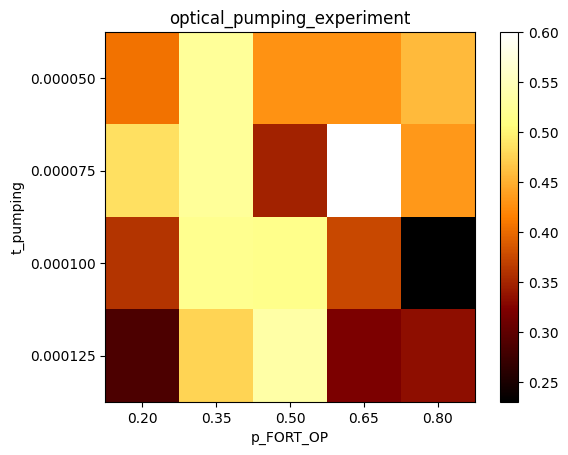

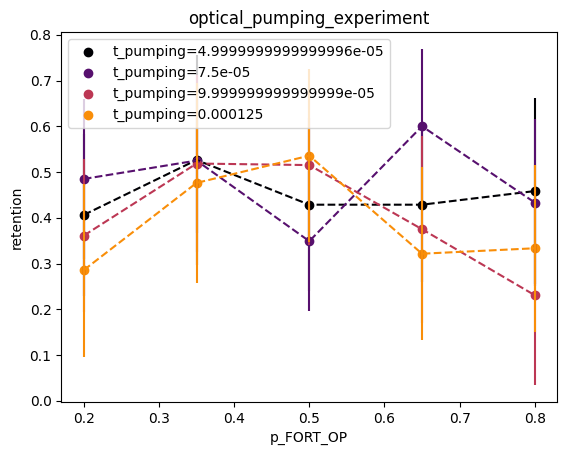

In [14]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 270
cutoff2 = 270
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

## December 2023

### 2023.12.22

#### D1 AOM frequency scan (1D)

In [273]:
fname = "2023-12-22\\17\\000008907-GeneralVariableScan.h5"

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [274]:
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
if scan_variable2 != '':
    scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])
    scan_is_2D = True
else:
    scan_sequence2 = np.zeros(1)
    scan_is_2D = False

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping
t_pumping [1.e-06 5.e-05]
 [0.]
MOT AOMs on the whole time? False
Blow-away light off? False
Pumping light off? False


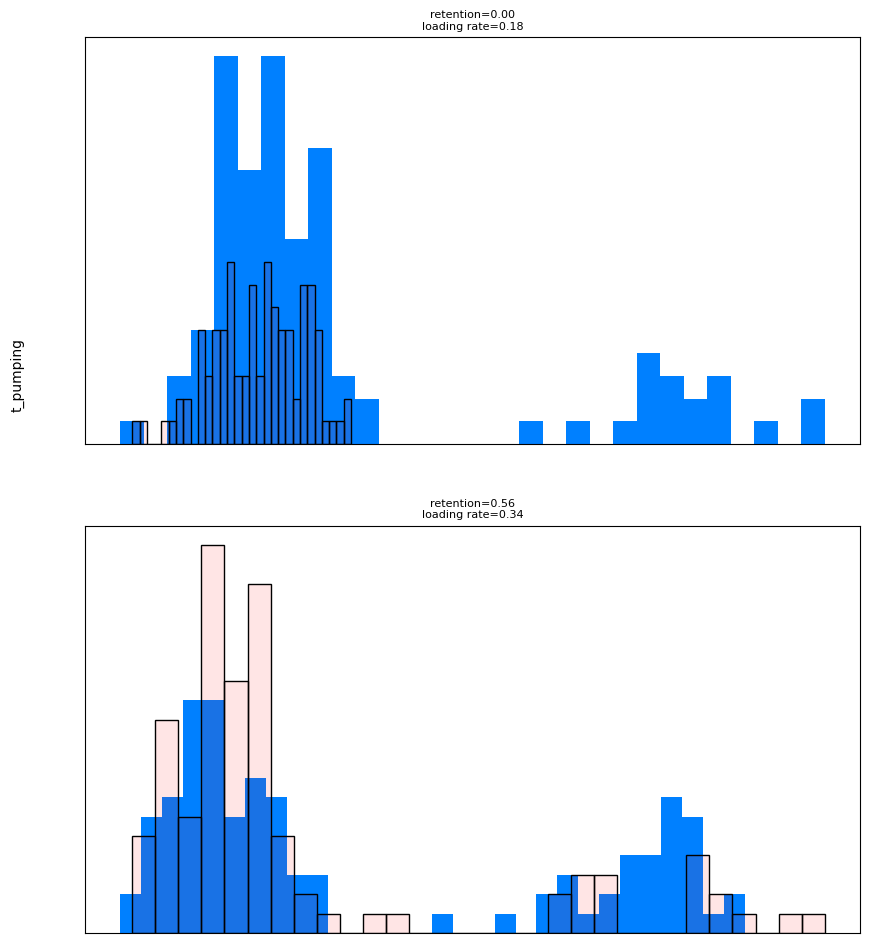

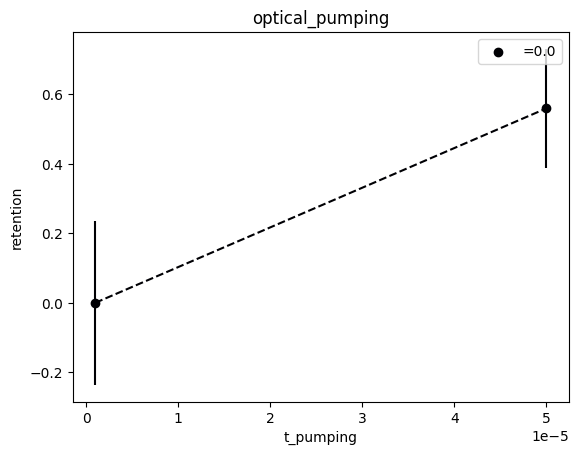

In [275]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 270
cutoff2 = 270
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
if scan_is_2D:
    dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    if scan_is_2D: # todo
        axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
        [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
        [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
        [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

if scan_is_2D:
    # plot a colormap of the retention
    fig,ax = plt.subplots()
    cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
                  extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
    im = ax.get_images()
    extent =  im[0].get_extent()
    # plt.setp(ax.spines.values(), linewidth=0.1)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
    ax.set_xticks(scan_sequence1)
    ax.set_yticks(scan_sequence2)
    ax.set_title(experiment_name)
    ax.set_xlabel(scan_variable1)
    ax.set_ylabel(scan_variable2)
    # ax.tick_params(axis='both', labelsize=10)
    fig.colorbar(cax)
    # plt.clim(0,1)
    plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

#### timing and D1 AOM frequency scan

In [256]:
fname = "2023-12-22\\16\\000008903-GeneralVariableScan.h5"

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [259]:
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping
t_pumping [5.0e-05 1.0e-04 1.5e-04]
f_D1_pumping_SP [85000000. 87500000. 90000000. 92500000. 95000000.]
MOT AOMs on the whole time? False
Blow-away light off? False
Pumping light off? False


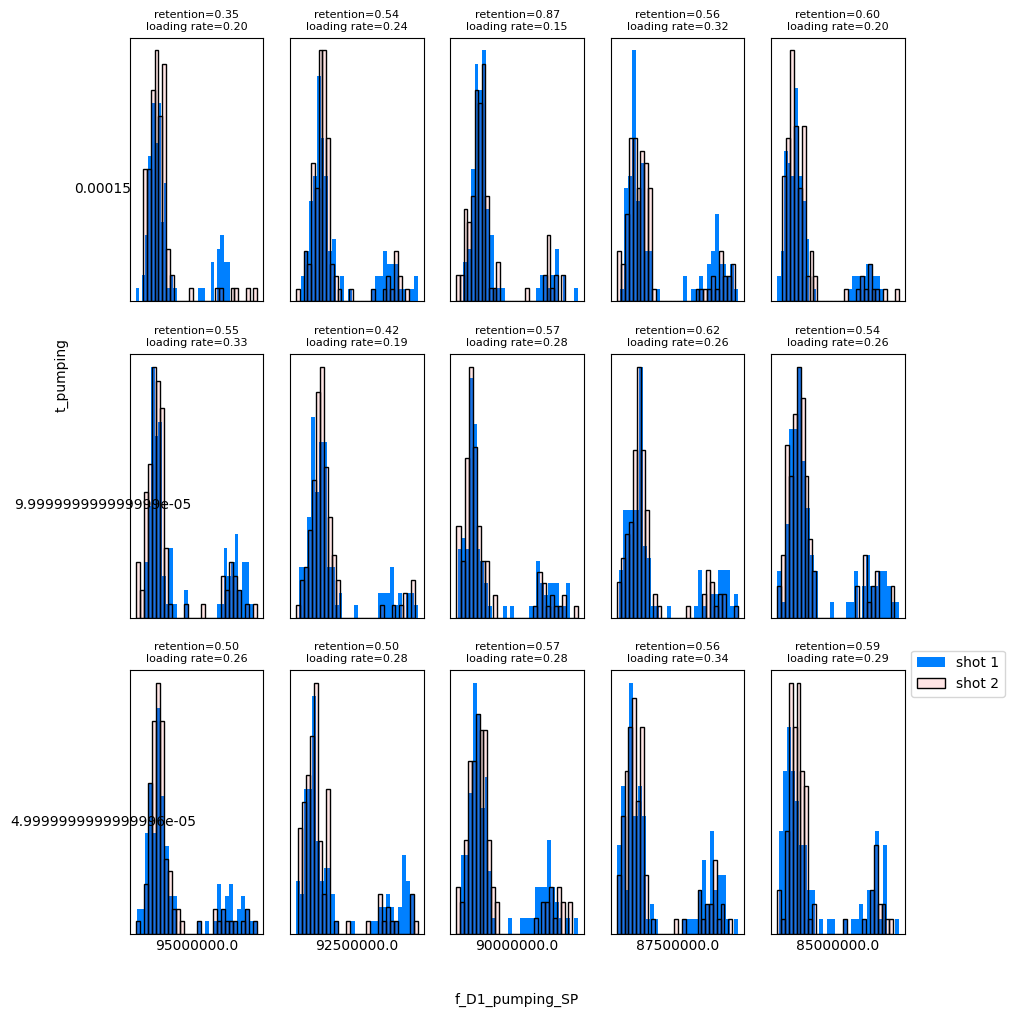

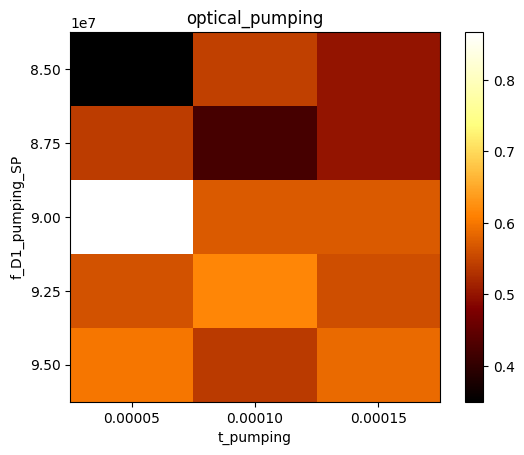

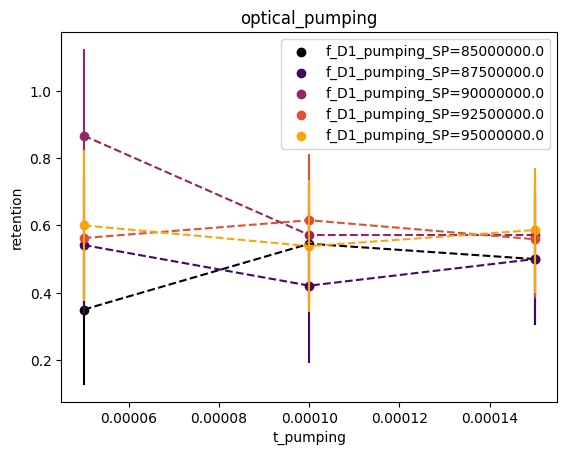

In [260]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 270
cutoff2 = 270
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
    [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
    [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
    [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

# plot a colormap of the retention
fig,ax = plt.subplots()
cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
              extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
im = ax.get_images()
extent =  im[0].get_extent()
# plt.setp(ax.spines.values(), linewidth=0.1)
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
ax.set_xticks(scan_sequence1)
ax.set_yticks(scan_sequence2)
ax.set_title(experiment_name)
ax.set_xlabel(scan_variable1)
ax.set_ylabel(scan_variable2)
# ax.tick_params(axis='both', labelsize=10)
fig.colorbar(cax)
# plt.clim(0,1)
plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

In [261]:
max(retention_array)

0.8666666666666667

#### D1 AOM power and FORT AOM power scan

In [242]:
fname = "2023-12-22\\16\\000008901-GeneralVariableScan.h5"

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [243]:
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping
p_FORT_OP [0.2, 0.3, 0.4, 0.5]
p_D1_pumping_SP [-11, -9, -7]
MOT AOMs on the whole time? False
Blow-away light off? False
Pumping light off? False


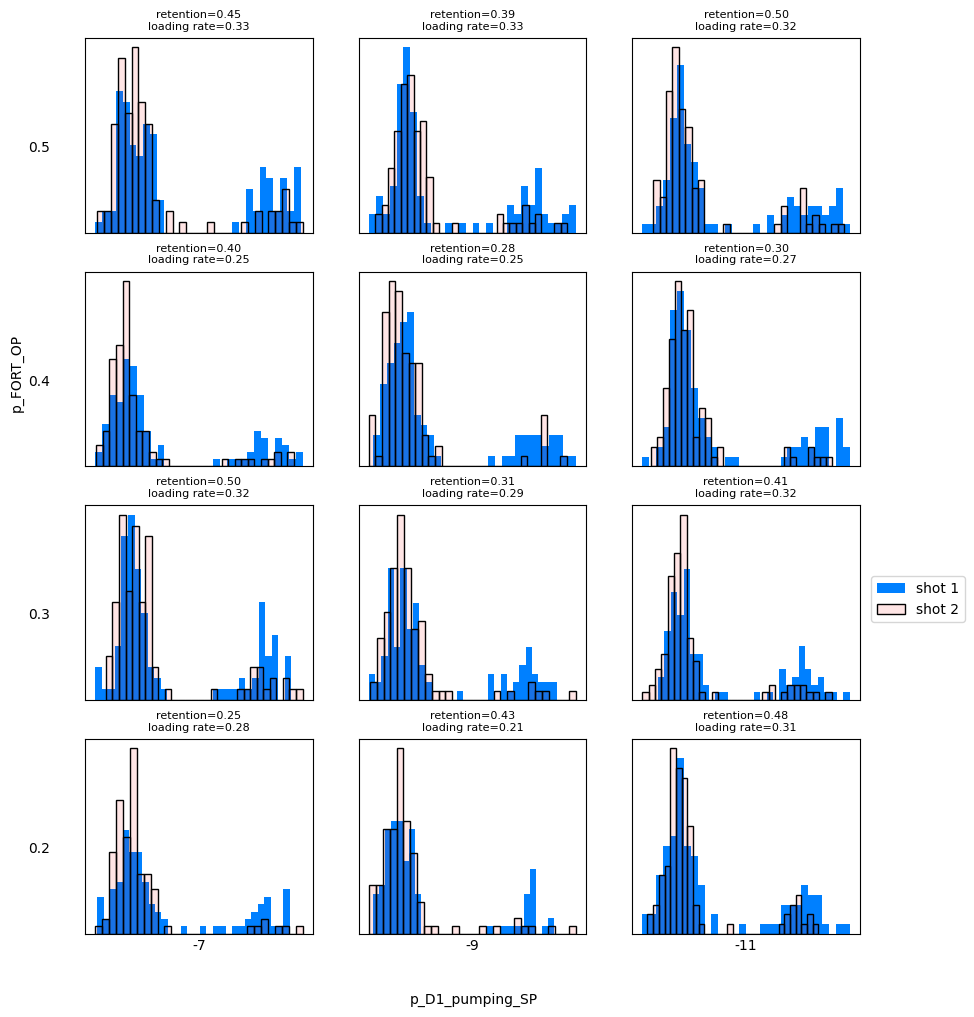

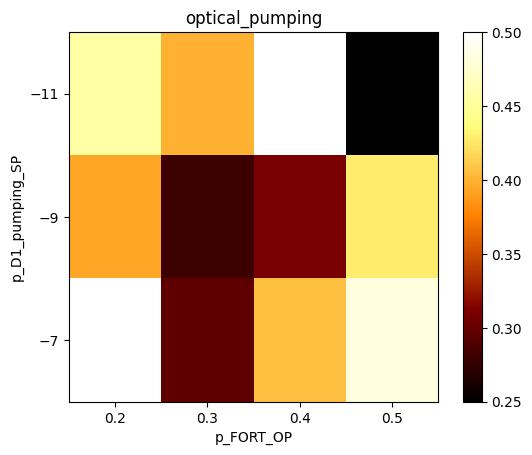

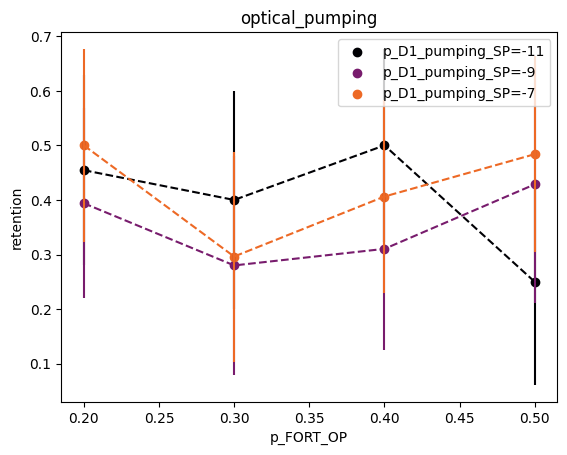

In [251]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 260
cutoff2 = 260
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
    [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
    [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
    [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

# plot a colormap of the retention
fig,ax = plt.subplots()
cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
              extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
im = ax.get_images()
extent =  im[0].get_extent()
# plt.setp(ax.spines.values(), linewidth=0.1)
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
ax.set_xticks(scan_sequence1)
ax.set_yticks(scan_sequence2)
ax.set_title(experiment_name)
ax.set_xlabel(scan_variable1)
ax.set_ylabel(scan_variable2)
# ax.tick_params(axis='both', labelsize=10)
fig.colorbar(cax)
# plt.clim(0,1)
plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

#### X and Z coil scan

In [2]:
fname = "2023-12-21\\18\\000008878-GeneralVariableScan.h5" # 2D scan over Z top coil and X coil voltage
fname = "2023-12-22\\11\\000008894-GeneralVariableScan.h5" # 2D scan over Z top coil and X coil voltage
# fname = "2023-12-22\\12\\000008896-GeneralVariableScan.h5" # corrupt file
# fname = "2023-12-22\\13\\000008897-GeneralVariableScan.h5" # corrupt file
fname = "2023-12-22\\14\\000008898-GeneralVariableScan.h5"

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [7]:
experiment_name = str_from_h5(f['datasets']['experiment_function'])
print("experiment:",experiment_name)

n_measurements = np.uint(f['datasets']['n_measurements'])
scan_variable1 = str_from_h5(f['datasets']['scan_variable1'])
# scan_variable1_unit = str_from_h5(f['datasets']['scan_sequence1'])[] # todo

scan_sequence1 = eval_str_from_h5(f['datasets']['scan_sequence1'])
scan_variable2 = str_from_h5(f['datasets']['scan_variable2'])
scan_sequence2 = eval_str_from_h5(f['datasets']['scan_sequence2'])

print(scan_variable1,scan_sequence1)
print(scan_variable2,scan_sequence2)

iterations = len(scan_sequence1)*len(scan_sequence2)

counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

# print("MOT AOMs on the whole time?", control_experiment)
# print("Blow-away light off?", blowaway_light_off)
# print("Pumping light off?", pumping_light_off)

assert len(counts_shot1) == (iterations*n_measurements), "warning: the experiment may have ended prematurely"

experiment: optical_pumping
AX_volts_OP [2.    2.125 2.25  2.375 2.5  ]
AZ_top_volts_OP [-1.25  -1.125 -1.    -0.875 -0.75 ]


In [14]:
np.float64(f['archive']['AZ_bottom_volts_MOT']), np.float64(f['archive']['AZ_top_volts_MOT']),np.float64(f['archive']['AX_volts_MOT']),np.float64(f['archive']['AY_volts_MOT'])

(4.055, 4.501, 0.428, 0.141)

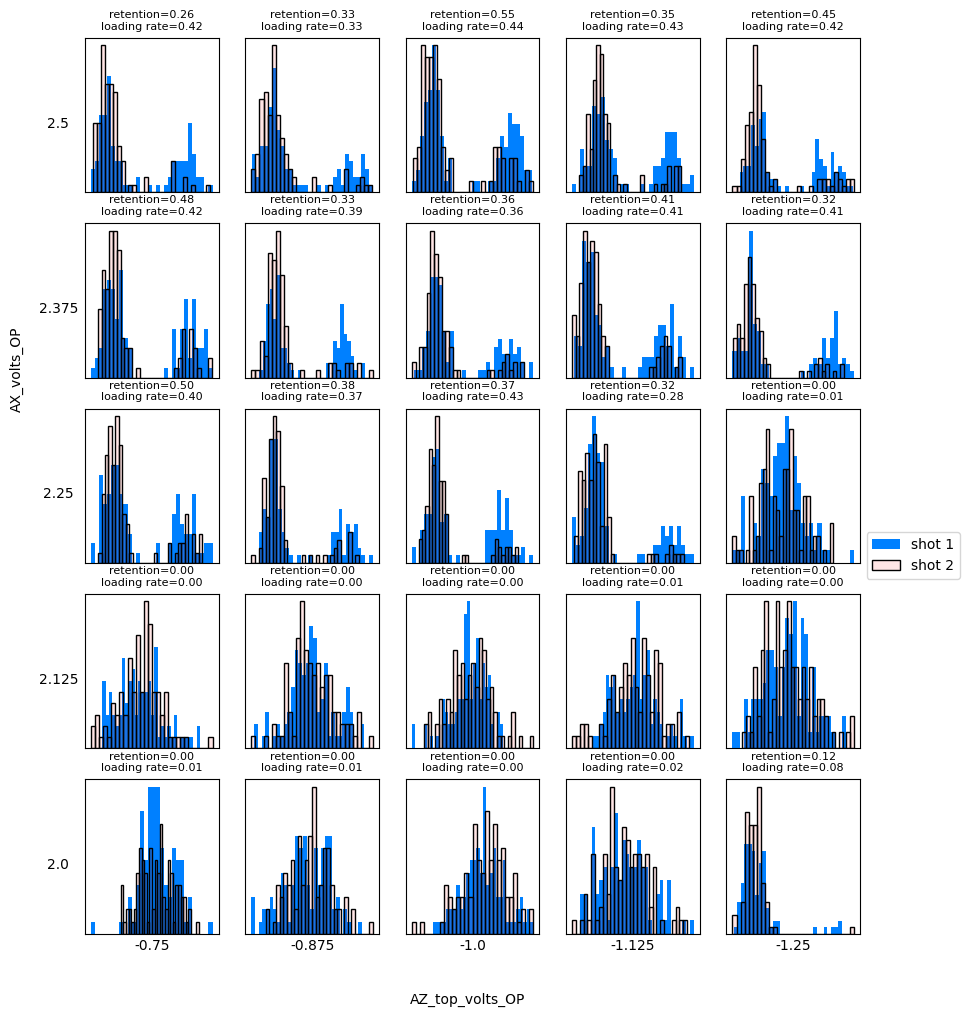

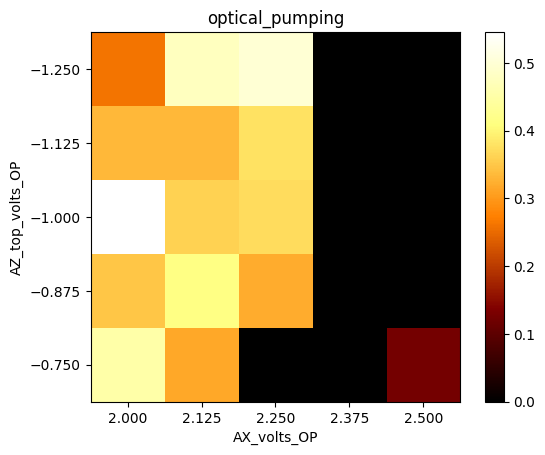

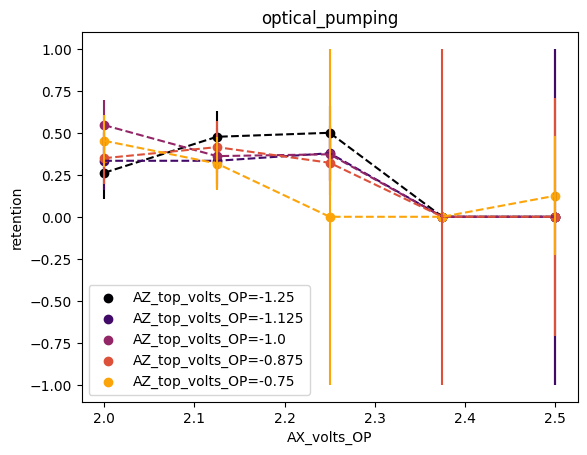

In [6]:
showhist = True

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = 260
cutoff2 = 260
retention_array = np.zeros(iterations)
loading_rate_array = np.zeros(iterations)
n_atoms_loaded_array = np.zeros(iterations)

ncols = len(scan_sequence2)
nrows = len(scan_sequence1)

dvar1 = abs(scan_sequence1[1]-scan_sequence1[0])
dvar2 = abs(scan_sequence2[1]-scan_sequence2[0])

measurements = n_measurements #if not control_experiment else n_measurements//2

for i in range(iterations):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1 for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2 and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

shape = (len(scan_sequence2),len(scan_sequence1))
loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

if showhist:
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,7))
    for i, ax in enumerate(axes.flat):
        shot1 = counts_shot1[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2[i*measurements:(i+1)*measurements]
        ax.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        ax.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        ax.set_title(f"retention={retention_array[i]:.2f}\nloading rate={loading_rate_array[i]:.2f}",fontsize=8)
        # ax.set_ylabel("occurences")
        # ax.set_xlabel("photons")
        ax.set_xticks([])
        ax.set_yticks([])
    axes.flat[ncols-1].legend(loc=(1.05,-nrows/2))
    [axes[-1,ncols-i-1].set_xlabel(var2) for i,var2 in enumerate(scan_sequence2)]
    [axes[nrows-i-1,0].set_ylabel(var1,rotation=0) for i,var1 in enumerate(scan_sequence1)]
    [axes[nrows-i-1,0].yaxis.set_label_coords(-0.2,0.4) for i in range(nrows)]
    fig.text(0.45,-0.5, scan_variable2)
    fig.text(0.05,0.35, scan_variable1,rotation=90)
    plt.subplots_adjust(bottom=-0.4)
    plt.show()

# plot a colormap of the retention
fig,ax = plt.subplots()
cax=ax.imshow(retention_raveled,cmap='afmhot',interpolation='none',
              extent=[scan_sequence1[0]-dvar1/2,scan_sequence1[-1]+dvar1/2,scan_sequence2[-1]+dvar2/2,scan_sequence2[0]-dvar2/2])
im = ax.get_images()
extent =  im[0].get_extent()
# plt.setp(ax.spines.values(), linewidth=0.1)
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2])))
ax.set_xticks(scan_sequence1)
ax.set_yticks(scan_sequence2)
ax.set_title(experiment_name)
ax.set_xlabel(scan_variable1)
ax.set_ylabel(scan_variable2)
# ax.tick_params(axis='both', labelsize=10)
fig.colorbar(cax)
# plt.clim(0,1)
plt.show()

# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):
    plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
    plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
    plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

[0.54545455 0.36111111 0.37209302 0.         0.        ]


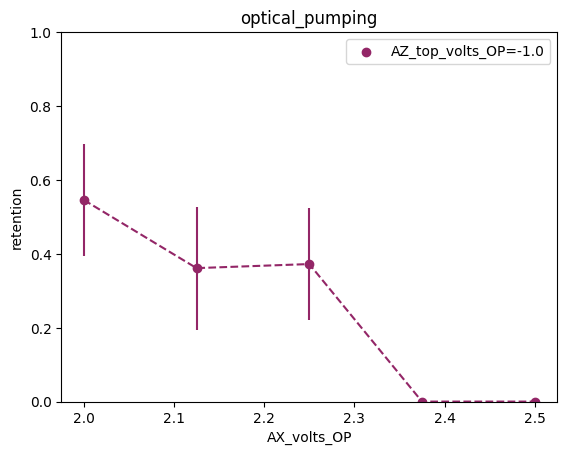

In [255]:
# plot a retention curve vs variable 1 for each variable 2 value
cmap = mpl.colormaps['inferno']
for i, retention, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, n_atoms_loaded_raveled, scan_sequence2):

    # data = np.transpose(scan_sequence1, retention)
    if i == 2:
        print(retention)
        plt.plot(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),linestyle='--')
        plt.scatter(scan_sequence1, retention,color=cmap(i/len(scan_sequence2)),label=scan_variable2+"="+str(var2))
        errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded]
        plt.errorbar(scan_sequence1, retention, errs, ls='none',color=cmap(i/len(scan_sequence2)))


plt.xlabel(scan_variable1)
plt.ylim((0,1))
plt.ylabel("retention")
plt.legend()
plt.title(experiment_name)
plt.show()

In [237]:
np.transpose([[1,3,3],[1,3,3]])

array([[1, 1],
       [3, 3],
       [3, 3]])

### 2023.12.20

In [2]:
# fname = "2023-12-19\\22\\000008718-SingleAtomOpticalPumpingScan.h5" # control with no OP or BA. clear evidence for pumping but only ~ 0.5 transfer. no bias field applied
fname = "2023-12-20\\09\\000008723-SingleAtomOpticalPumpingScan.h5" # control with BA but no OP. ~ 1 G bias along Y (mirror axis) but no fine tuning.
# fname = "2023-12-20\\10\\000008725-SingleAtomOpticalPumpingScan.h5" # same. I add an experiment variable for the FORT power during the OP
fname = "2023-12-20\\11\\000008728-SingleAtomOpticalPumpingScan.h5" # I physically blocked the pumping repump


f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [3]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])

blowaway_light_off = np.bool_(f['datasets']['blowaway_light_off'])
pumping_light_off = np.bool_(f['datasets']['only_exclude_pumping_light'])

print("control experiment?", control_experiment)
if control_experiment:
    print("only excluded pumping light?", pumping_light_off)

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

t_arr = eval_str_from_h5(f['datasets']['t_pumping_sequence'])
print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

control experiment? True
only excluded pumping light? True
MOT AOMs on the whole time? True
Blow-away light off? False
Pumping light off? True
PGC phase? False


In [5]:
t_arr

array([0.e+00, 1.e-06, 5.e-06, 2.e-05, 5.e-05])

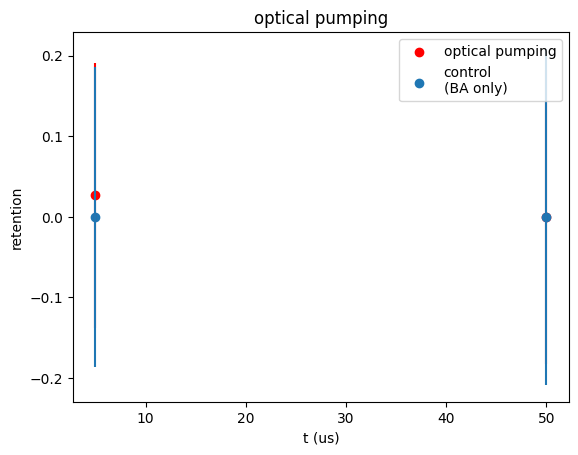

In [4]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = [260]*len(t_arr)
cutoff2 = [260]*len(t_arr)
retention_array = np.zeros(len(t_arr))
loading_rate_array = np.zeros(len(t_arr))

n_atoms_loaded_array = np.zeros(len(t_arr))

measurements = n_measurements if not control_experiment else n_measurements//2

for i,t in enumerate(t_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

# tau = 30 # us
# tpts = np.linspace(t_arr[0],t_arr[-1],100)/us
# plt.plot(tpts, 0.9*(1-np.exp(-tpts/tau)),color='r',linestyle='--',label=r'$\tau=$'+f'{tau}'+r'$\mu$s')

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(t_arr/us, retention_array, label='optical pumping',color='r')
t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('optical pumping')
plt.errorbar(t_arr/us,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("t (us)")

if control_experiment:
    retention_array = np.zeros(len(t_arr))
    loading_rate_array = np.zeros(len(t_arr))
    
    n_atoms_loaded_array = np.zeros(len(t_arr))
    
    for i,t in enumerate(t_arr):
        shot1 = counts_shot1_control[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2_control[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1[i] for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2[i] and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded
    
    lbl = 'control'
    if pumping_light_off:
        lbl += '\n(BA only)'
    else:
        lbl += '\n(no OP or BA)'
    
    plt.scatter(t_arr/us, retention_array, label=lbl)
    t_pts = np.linspace(t_arr[0],t_arr[-1],100)
    # plt.title('blow away')
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
    plt.errorbar(t_arr/us,retention_array,errs,ls='none')
    plt.legend()
    # plt.ylabel("retention")
    # plt.xlabel("t (us)")

In [67]:
loading_rate_array

array([0.24 , 0.185, 0.21 , 0.22 , 0.195, 0.235])

### 2023.12.19

In [34]:
fname = "2023-12-19\\16\\000008695-SingleAtomOpticalPumpingScan.h5" # controlled experiment with the blow-away light off
fname = "2023-12-19\\17\\000008704-SingleAtomOpticalPumpingScan.h5" # accidentally had different 1st/2nd shot readout times
fname = "2023-12-19\\22\\000008716-SingleAtomOpticalPumpingScan.h5" # control, only exclude pumping light. looks like all controls are blown away (good) and pumping is acheived in only 1 us. conflicts with 8695 data

f = h5py.File(os.path.join(results, fname))
# [x for x in f['datasets']]

In [40]:
n_measurements = np.uint(f['datasets']['n_measurements'])
control_experiment = np.bool_(f['datasets']['control_experiment'])

blowaway_light_off = np.bool_(f['datasets']['blowaway_light_off'])
pumping_light_off = np.bool_(f['datasets']['only_exclude_pumping_light'])

print("control experiment?", control_experiment)
if control_experiment:
    print("only excluded pumping light?", pumping_light_off)

if control_experiment:
    counts_shot1_all = list(f['datasets']['photocounts'])[1:]
    counts_shot1_control = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot1 = [counts_shot1_all[i] for i in range(len(counts_shot1_all)) if i%2==1]

    counts_shot2_all = list(f['datasets']['photocounts2'])[1:]
    counts_shot2_control = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==0]
    counts_shot2 = [counts_shot2_all[i] for i in range(len(counts_shot1_all)) if i%2==1]
else:
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]

t_arr = eval_str_from_h5(f['datasets']['t_pumping_sequence'])
print("MOT AOMs on the whole time?", control_experiment)
print("Blow-away light off?", blowaway_light_off)
print("Pumping light off?", pumping_light_off)

print("PGC phase?", np.bool_(f['datasets']['do_PGC_in_MOT']))

control experiment? True
only excluded pumping light? True
MOT AOMs on the whole time? True
Blow-away light off? False
Pumping light off? True
PGC phase? False


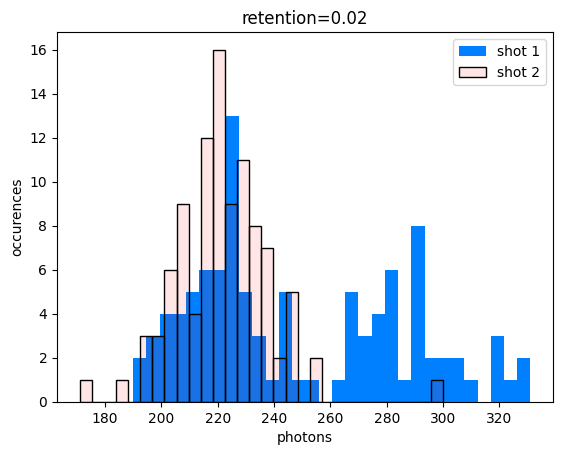

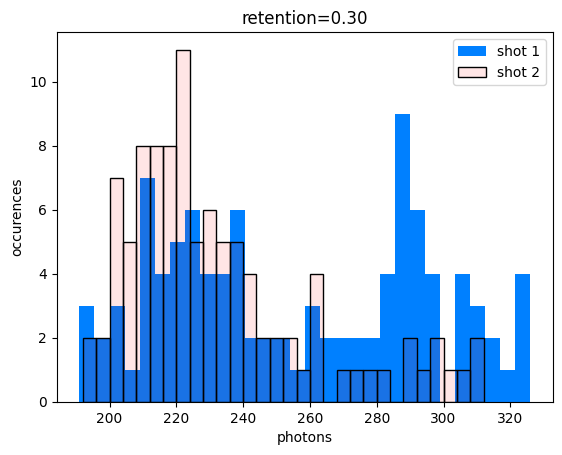

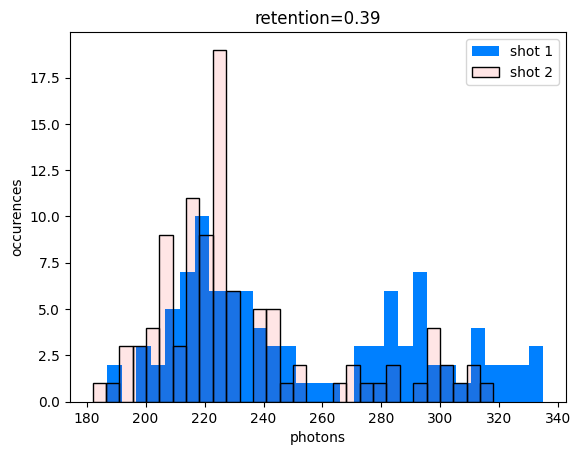

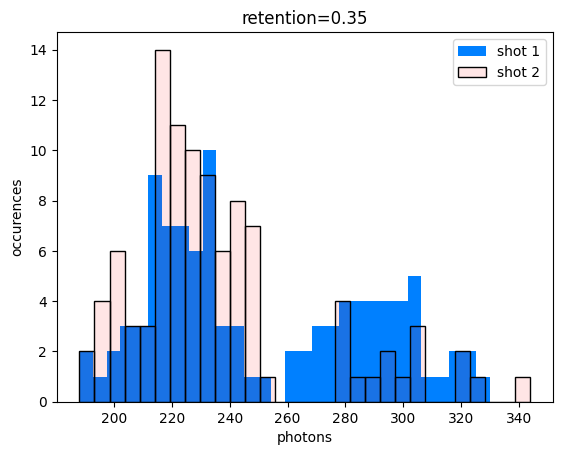

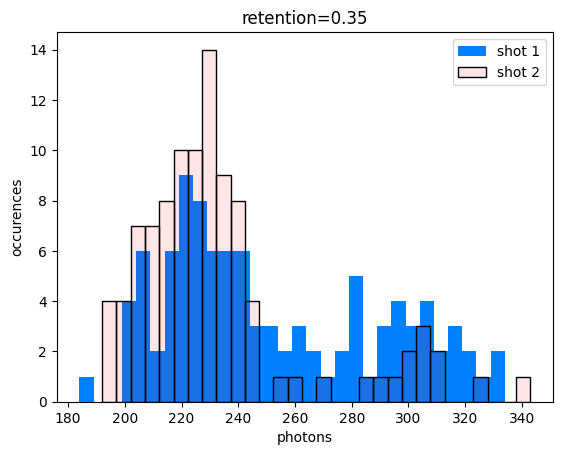

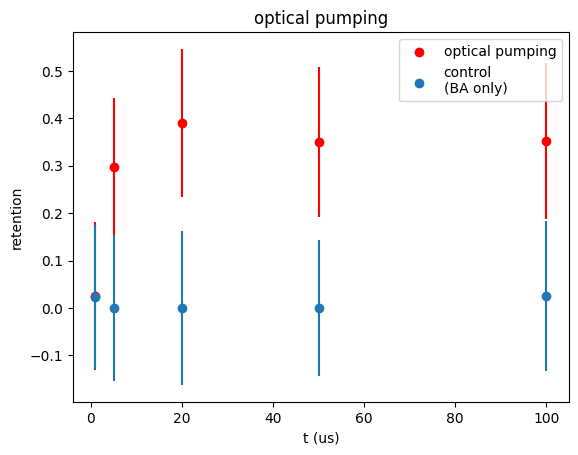

In [41]:
showhist = False

# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff1 = [260]*len(t_arr)
cutoff2 = [260]*len(t_arr)
retention_array = np.zeros(len(t_arr))
loading_rate_array = np.zeros(len(t_arr))

n_atoms_loaded_array = np.zeros(len(t_arr))

measurements = n_measurements if not control_experiment else n_measurements//2

for i,t in enumerate(t_arr):
    shot1 = counts_shot1[i*measurements:(i+1)*measurements]
    shot2 = counts_shot2[i*measurements:(i+1)*measurements]
    
    atoms_loaded = [x > cutoff1[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff2[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    if showhist:
        plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
        plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
        plt.title(f"retention={retention_fraction:.2f}")
        plt.ylabel("occurences")
        plt.xlabel("photons")
        plt.legend()
        plt.show()

# tau = 30 # us
# tpts = np.linspace(t_arr[0],t_arr[-1],100)/us
# plt.plot(tpts, 0.9*(1-np.exp(-tpts/tau)),color='r',linestyle='--',label=r'$\tau=$'+f'{tau}'+r'$\mu$s')

errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
plt.scatter(t_arr/us, retention_array, label='optical pumping',color='r')
t_pts = np.linspace(t_arr[0],t_arr[-1],100)
plt.title('optical pumping')
plt.errorbar(t_arr/us,retention_array, errs, ls='none',color='r')
plt.ylabel("retention")
plt.xlabel("t (us)")

if control_experiment:
    retention_array = np.zeros(len(t_arr))
    loading_rate_array = np.zeros(len(t_arr))
    
    n_atoms_loaded_array = np.zeros(len(t_arr))
    
    for i,t in enumerate(t_arr):
        shot1 = counts_shot1_control[i*measurements:(i+1)*measurements]
        shot2 = counts_shot2_control[i*measurements:(i+1)*measurements]
        
        atoms_loaded = [x > cutoff1[i] for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff2[i] and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements
        n_atoms_loaded_array[i] = n_atoms_loaded

    lbl = 'control'
    if pumping_light_off:
        lbl += '\n(BA only)'
    else:
        lbl += '\n(no OP or BA)'
    
    plt.scatter(t_arr/us, retention_array, label=lbl)
    t_pts = np.linspace(t_arr[0],t_arr[-1],100)
    # plt.title('blow away')
    errs = [1/np.sqrt(n) if n > 0 else np.inf for n in n_atoms_loaded_array]
    plt.errorbar(t_arr/us,retention_array,errs,ls='none')
    plt.legend()
    # plt.ylabel("retention")
    # plt.xlabel("t (us)")